# Joint Intent Detection and Slot Filling

We are going to load pre-trained BERT model and fine-tune it for an intent detection.

# Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [1]:
import torch
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name())

In [2]:
device = 'cuda'

In [3]:
import pandas as pd

# Processed and Overview Dataset

## 1- Intents With Slot

In [3]:
!pwd

/Users/precioux/Documents/NLU/Eunoia/NLU


In [4]:
df_with_slots = pd.read_excel(f"dataset/intents_with_slots/all_data_inOnePlace/data-intent-with-slots-all-final_14030321.xlsx",
                             header=None, names=['a','b','c','pattern_id','e','text','slots','intent'])[['pattern_id','text','slots','intent']]
df_with_slots

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
24997,519540,ذکر ماه ذیقعده چیست؟,o o b-islamic_months o,zekr
24998,519556,بعد نماز ظهر و عصر چه ذکری می‌گن,o o o o o o o o,zekr
24999,519496,میخاهیم برای ذکر امروز آماده شوم لطفاً به اطلا...,o o o b-date o o o o o o,zekr
25000,519531,ذکر امروز رو یادم رفت تو میدونی چیه؟,o b-date o o o o o o,zekr


In [99]:
# df_with_slots[df_with_slots['pattern_id']==1140]

,pattern_id,text,slots,intent
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
44,1140,لطفا دعای عهد رو بیار بخونم,o b-prayer_name i-prayer_name o o o,adie
274,1140,لطفا جوشن صغیر رو بیار بخونم,o b-prayer_name i-prayer_name o o o,adie
464,1140,لطفا مشلول رو بیار بخونم,o b-prayer_name o o o,adie


In [18]:
# df_with_slots = pd.read_excel(f"dataset/intents_with_slots/all_data_inOnePlace/data-intent-with-slots-all-final_14030321.xlsx", usecols=['text','slots','intent','pattern_id'])

In [5]:
# import os
# dir_path = "dataset/intents_with_slots"
# dir_list = []
# for file in os.listdir(dir_path):
#     if file.endswith('.xlsx'):
#         dir_list.append(file)
# dir_list = sorted(dir_list)
# print(dir_list)

['output-data12-8.5.xlsx', 'output-data4-8.5.xlsx', 'output-data6-8.5.xlsx', 'output-data8-8.5.xlsx', 'output-data9-8.5.xlsx']


In [6]:
# import pandas as pd
# pd.set_option('display.max_colwidth',300)

# subdataset = []
# for path in dir_list:
#     dataset_with_slot = pd.read_excel(f"{dir_path}/{path}", usecols=['text','slots','intent','pattern_id'])
#     dataset_with_slot['file_name'] = path
#     subdataset.append(dataset_with_slot)  
    
# df_with_slots = pd.concat(subdataset,axis=0).reset_index(drop=True)
# df_with_slots

,pattern_id,text,slots,intent,file_name
0,1137,15 به علاوه 129267 چند میشه,b-num1 b-plus i-plus b-num2 o o,ask_math,output-data12-8.5.xlsx
1,1137,6 به علاوه 391504 چند میشه,b-num1 b-plus i-plus b-num2 o o,ask_math,output-data12-8.5.xlsx
2,1138,به 19 تا 980509 تا اضافه کنی چقدر میشه,o b-num1 o b-num2 o b-plus o o o,ask_math,output-data12-8.5.xlsx
3,1138,به 53 تا 909104 تا اضافه کنی چقدر میشه,o b-num1 o b-num2 o b-plus o o o,ask_math,output-data12-8.5.xlsx
4,1138,به 32 تا 916108 تا اضافه کنی چقدر میشه,o b-num1 o b-num2 o b-plus o o o,ask_math,output-data12-8.5.xlsx
...,...,...,...,...,...
11749,2029,چی میشه 12 شهریور از قمری به شمسی؟,o o b-date i-date o o o o,calendar_convert,output-data9-8.5.xlsx
11750,2029,چی میشه 15 بهمن از قمری به شمسی؟,o o b-date i-date o o o o,calendar_convert,output-data9-8.5.xlsx
11751,2029,چی میشه 5 آبان از قمری به شمسی؟,o o b-date i-date o o o o,calendar_convert,output-data9-8.5.xlsx
11752,2030,7 اسفند از میلادی به شمسی چه تاریخی میشه؟,b-date i-date o o o o o o o,calendar_convert,output-data9-8.5.xlsx


### Checking & Preprocessing

In [5]:
df_with_slots.shape   #8875 -> 11781 -> 11755 -> 25002

(25002, 4)

In [6]:
# محاسبه تکراریها با حذف .,?! از ابتدا انتهای هر متن
# df_with_slots['text'] = df_with_slots.text.apply(lambda x: x.strip(",.!:;? ؟،؛"))
'اسمتون چیه  ؟          !.:;'.strip(",.!:;? ؟،؛")

'اسمتون چیه'

In [7]:
df_with_slots [ df_with_slots.duplicated(subset=['text'],keep=False) == True ]

,pattern_id,text,slots,intent


In [8]:
df_with_slots [ df_with_slots.duplicated(subset=['text'],keep=False) == True ].drop(['slots','pattern_id'],axis=1).reset_index(drop=True).to_excel('df_withslot_171duplicates_0807.xlsx')

In [9]:
# df_without_slots
#deleting duplicates in text
if df_with_slots.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_with_slots.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_with_slots = df_with_slots.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_with_slots.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [10]:
df_with_slots.shape

(25002, 4)

In [11]:
df_with_slots.intent.nunique()  # 50 -> 52

52

In [12]:
df_with_slots.intent.value_counts()#.to_excel('data_with_slots_intent_statistics.xlsx')

intent
user_introduce        1008
ask_azan               916
city_population        793
price_gold             772
get_recipe             746
book_info              724
ask_weather            721
movie_score            699
ask_math               679
ask_currency           625
dictation              621
calendar_convert       597
city_sightseeing       594
get_ingredients        591
get_cooktime           585
president              576
movie_info             566
complaints             564
word_meaning           562
unit_convert           536
translate_it           517
find_cinama            514
adie                   497
sing_a_song            484
sheer                  470
danestani              454
city_distance          449
next_event_date        442
quran_info             439
ask_capital            438
movie_genre            437
bot_favorites          427
ask_restaurant         422
ask_sendpic            410
birth_things           409
telephone              403
convert_currency     

In [13]:
df_with_slots = df_with_slots.drop(df_with_slots[df_with_slots['intent'] == 'intent'].index)
df_with_slots

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
24997,519540,ذکر ماه ذیقعده چیست؟,o o b-islamic_months o,zekr
24998,519556,بعد نماز ظهر و عصر چه ذکری می‌گن,o o o o o o o o,zekr
24999,519496,میخاهیم برای ذکر امروز آماده شوم لطفاً به اطلا...,o o o b-date o o o o o o,zekr
25000,519531,ذکر امروز رو یادم رفت تو میدونی چیه؟,o b-date o o o o o o,zekr


In [15]:
pd.Series(" ".join(df_with_slots.slots).split()).value_counts().to_excel('./report/data_with_slots_slot_statistics.xlsx')

In [16]:
from collections import Counter
Counter(" ".join(df_with_slots.slots).split())

Counter({'o': 161514,
         'b-city': 3217,
         'i-food_name': 2830,
         'i-movie': 2639,
         'b-food_name': 2450,
         'b-date': 2097,
         'b-movie': 2025,
         'b-country': 1430,
         'i-date': 1425,
         'i-holiday': 1262,
         'b-word': 1197,
         'b-num1': 1179,
         'b-currency': 1025,
         'i-book_name': 1013,
         'i-coin_type': 951,
         'i-sentence': 943,
         'b-prayer_time': 891,
         'i-food_volume': 871,
         'i-currency': 778,
         'b-book_name': 718,
         'b-dest_calender': 613,
         'b-num2': 609,
         'i-city': 606,
         'b-coin_type': 606,
         'b-month': 593,
         'i-telephone': 552,
         'b-destination_language': 541,
         'b-food_volume': 526,
         'b-sentence': 510,
         'b-holiday': 507,
         'b-input': 501,
         'b-complaint_subject': 500,
         'b-prayer_name': 497,
         'b-dest_city': 458,
         'b-ingredient': 449,
        

In [17]:
pd.Series(" ".join(df_with_slots.slots).split()).value_counts()[-30:]

i-divide               26
b-direction            22
i-district             19
i-unit_mass2           18
i-unit_mass1           18
i-movie_genre          18
i-direction            17
b-radical              16
i-rest_type            16
i-minus                15
i-poem_genre           14
i-origin_language      13
i-unit_length1         13
i-esm_famil_subject    13
i-islamic_months       12
i-street               12
i-redical              11
i-sore_name            10
i-unit_length2          8
i-month                 7
i-year                  6
i-user_name             4
b-ingredient1           3
b-ingredient2           3
b-ingredient3           2
i-radical               1
i-writer_name           1
b-writer_name           1
i-ingredient1           1
ه-food_name             1
Name: count, dtype: int64

In [18]:
misspelling_slot_map_dictionary = {
    "ه-food_name": "i-food_name",
    "b-ingredient1": "b-ingredient",
    "b-ingredient2": "b-ingredient",
    "b-ingredient3": "b-ingredient",
    "i-ingredient1": "i-ingredient",
    "i-redical": "i-radical",
}

In [19]:
def misspelling_slot_mapping(text):
    current_slots = text.split(" ")
    new_slots = []
    for slot in current_slots:
        new_slots.append(misspelling_slot_map_dictionary.get(slot, slot))

    return " ".join(new_slots)

In [20]:
misspelling_slot_mapping("b-ingredient1 o o o b-radical")

'b-ingredient o o o b-radical'

In [21]:
df_with_slots["slots"] = df_with_slots["slots"].apply(misspelling_slot_mapping)

In [22]:
df_with_slots

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
24997,519540,ذکر ماه ذیقعده چیست؟,o o b-islamic_months o,zekr
24998,519556,بعد نماز ظهر و عصر چه ذکری می‌گن,o o o o o o o o,zekr
24999,519496,میخاهیم برای ذکر امروز آماده شوم لطفاً به اطلا...,o o o b-date o o o o o o,zekr
25000,519531,ذکر امروز رو یادم رفت تو میدونی چیه؟,o b-date o o o o o o,zekr


In [23]:
pd.Series(" ".join(df_with_slots.slots).split()).value_counts().to_excel('./report/data_with_slots_slot_statistics_v2.xlsx')

In [24]:
# تعداد تکرار اینتنتها با شماره فایل
intent2filename_dict = {}
for index, row in df_with_slots.iterrows():
    intent2filename_dict[row['intent']]= row['file_name']
    
data_noslot_frequency = pd.DataFrame(df_with_slots.intent.value_counts())
data_noslot_frequency['file name'] = data_noslot_frequency.index
data_noslot_frequency['file name'] = data_noslot_frequency['file name'].map(intent2filename_dict)
data_noslot_frequency.rename(columns={'intent':'counts'}, inplace = True)
data_noslot_frequency.to_excel('data_withslot-v1_frequency_0806.xlsx')
data_noslot_frequency

KeyError: 'file_name'

In [25]:
df_with_slots.drop(['file_name'], axis = 1 ,inplace=True)

KeyError: "['file_name'] not found in axis"

In [26]:
df_with_slots

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
24997,519540,ذکر ماه ذیقعده چیست؟,o o b-islamic_months o,zekr
24998,519556,بعد نماز ظهر و عصر چه ذکری می‌گن,o o o o o o o o,zekr
24999,519496,میخاهیم برای ذکر امروز آماده شوم لطفاً به اطلا...,o o o b-date o o o o o o,zekr
25000,519531,ذکر امروز رو یادم رفت تو میدونی چیه؟,o b-date o o o o o o,zekr


In [27]:
df_with_slots.to_excel('intent_with_slots.xlsx')

## 2- Intents Without Slots

In [28]:
df_without_slots = pd.read_excel(f"dataset/intents_without_slots/data-intents-without-slots_14030321.xlsx", usecols=['text','slots','intent','pattern_id'])
df_without_slots

,text,intent,slots,pattern_id
0,اسمتون چیه؟,ask_botname,o o,2000000
1,ممکنه اسمتون رو به من بگید؟,ask_botname,o o o o o o,2000001
2,من با کی صحبت میکنم؟,ask_botname,o o o o o,2000002
3,اگر ممکن هست اسمتان را به من بگید,ask_botname,o o o o o o o o,2000003
4,اسمت چیه؟,ask_botname,o o,2000004
...,...,...,...,...
13303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,whatever,o o o o o o o o o o,2013303
13304,بهتره تو بگی,whatever,o o o,2013304
13305,تو بگو که خوب میگی,whatever,o o o o o,2013305
13306,ایده های تو رو دوست دارم,whatever,o o o o o o,2013306


In [29]:
# import os
# dir_path = "dataset/intents_without_slots"
# dir_list = []
# for file in os.listdir(dir_path):
#     if file.endswith('.xlsx'):
#         dir_list.append(file)
# dir_list = sorted(dir_list)
# print(dir_list)

In [30]:
# import pandas as pd
# pd.set_option('display.max_colwidth',300)

# subdataset = []
# # for path in ['data1-E-M.xlsx', 'data2-1-M-E-SH.xlsx', 'data2-2-M-E.xlsx', 'data3.xlsx', 'data7-e.xlsx']:
# for path in dir_list:
#     dataset_without_slot = pd.read_excel(f"{dir_path}/{path}", usecols=['Sample Question','Intent - Eng'])
#     dataset_without_slot['file_name'] = path
#     subdataset.append(dataset_without_slot)    
    
# df_without_slots = pd.concat(subdataset, axis=0).reset_index(drop=True)

In [31]:
df_without_slots.dropna(inplace=True)

In [32]:
# df_without_slots.rename(columns = {"Sample Question": "text", "Intent - Eng": "intent"}, inplace=True)

In [33]:
def text_to_o_without_slots_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_without_slots" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [34]:
df_without_slots["slots"] = df_without_slots["text"].apply(text_to_o_slots)

In [35]:
df_without_slots["pattern_id"] = [ (i + 2_000_000) for i in range(len(df_without_slots))]

In [36]:
df_without_slots.reset_index(drop=True, inplace=True)

### Checking & Preprocessing

In [37]:
df_without_slots.shape

(13308, 4)

In [38]:
# محاسبه تکراریها با حذف .,?! از ابتدا انتهای هر متن
# df_without_slots['text'] = df_without_slots.text.apply(lambda x: x.strip(",.!:;? ؟،؛"))
'اسمتون چیه  ؟          !.:;'.strip(",.!:;? ؟،؛")

'اسمتون چیه'

In [39]:
# df_without_slots [ df_without_slots.duplicated(subset=['text'], keep=False) == True ].drop(['slots','pattern_id'],axis=1).reset_index(drop=True).to_excel('data-noslot_duplicates_0806.xlsx')

In [40]:
# df_without_slots
#deleting duplicates in text
if df_without_slots.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_without_slots.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_without_slots = df_without_slots.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_without_slots.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [41]:
df_without_slots.shape

(13308, 4)

In [42]:
df_without_slots.intent.nunique()

124

In [43]:
df_without_slots.intent.value_counts().to_excel('./report/data_without_slots_intent_statistics.xlsx')

In [44]:
df_without_slots

,text,intent,slots,pattern_id
0,اسمتون چیه؟,ask_botname,o o,2000000
1,ممکنه اسمتون رو به من بگید؟,ask_botname,o o o o o o,2000001
2,من با کی صحبت میکنم؟,ask_botname,o o o o o,2000002
3,اگر ممکن هست اسمتان را به من بگید,ask_botname,o o o o o o o o,2000003
4,اسمت چیه؟,ask_botname,o o,2000004
...,...,...,...,...
13303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,whatever,o o o o o o o o o o,2013303
13304,بهتره تو بگی,whatever,o o o,2013304
13305,تو بگو که خوب میگی,whatever,o o o o o,2013305
13306,ایده های تو رو دوست دارم,whatever,o o o o o o,2013306


In [45]:
df_without_slots

,text,intent,slots,pattern_id
0,اسمتون چیه؟,ask_botname,o o,2000000
1,ممکنه اسمتون رو به من بگید؟,ask_botname,o o o o o o,2000001
2,من با کی صحبت میکنم؟,ask_botname,o o o o o,2000002
3,اگر ممکن هست اسمتان را به من بگید,ask_botname,o o o o o o o o,2000003
4,اسمت چیه؟,ask_botname,o o,2000004
...,...,...,...,...
13303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,whatever,o o o o o o o o o o,2013303
13304,بهتره تو بگی,whatever,o o o,2013304
13305,تو بگو که خوب میگی,whatever,o o o o o,2013305
13306,ایده های تو رو دوست دارم,whatever,o o o o o o,2013306


In [46]:
# تعداد تکرار اینتنتها با شماره فایل
intent2filename_dict = {}
for index, row in df_without_slots.iterrows():
    intent2filename_dict[row['intent']]= row['file_name']
    
data_noslot_frequency = pd.DataFrame(df_without_slots.intent.value_counts())
data_noslot_frequency['file name'] = data_noslot_frequency.index
data_noslot_frequency['file name'] = data_noslot_frequency['file name'].map(intent2filename_dict)
data_noslot_frequency.rename(columns={'intent':'counts'}, inplace = True)
data_noslot_frequency.to_excel('data_noslot-v4_frequency_0806.xlsx')
data_noslot_frequency

KeyError: 'file_name'

In [47]:
df_without_slots.drop(['file_name'], axis = 1 ,inplace=True)

KeyError: "['file_name'] not found in axis"

In [48]:
df_without_slots

,text,intent,slots,pattern_id
0,اسمتون چیه؟,ask_botname,o o,2000000
1,ممکنه اسمتون رو به من بگید؟,ask_botname,o o o o o o,2000001
2,من با کی صحبت میکنم؟,ask_botname,o o o o o,2000002
3,اگر ممکن هست اسمتان را به من بگید,ask_botname,o o o o o o o o,2000003
4,اسمت چیه؟,ask_botname,o o,2000004
...,...,...,...,...
13303,اگه لازم به فکر کردن بود از تو نمیپرسیدم که,whatever,o o o o o o o o o o,2013303
13304,بهتره تو بگی,whatever,o o o,2013304
13305,تو بگو که خوب میگی,whatever,o o o o o,2013305
13306,ایده های تو رو دوست دارم,whatever,o o o o o o,2013306


In [49]:
df_without_slots.to_excel('intents_without_slots.xlsx')

##  3- Intent Offensive

In [53]:
df_offensive_general = pd.read_excel(f"./dataset/offensive_general.xlsx") #,header=None) #0,names=['text'])
df_offensive_general

FileNotFoundError: [Errno 2] No such file or directory: './dataset/offensive_general.xlsx'

In [51]:
df_offensive_general_hate1 = pd.read_excel(f"./dataset/offensive/Data-hate-2-1.xlsx",header=None) #0,names=['text'])
# Stack all columns vertically
stacked_df1 = df_offensive_general_hate1.melt(value_name='text')['text']

# Convert the stacked data to a DataFrame
df_offensive_general_hate1 = pd.DataFrame(stacked_df1)
df_offensive_general_hate1 = df_offensive_general_hate1.dropna().reset_index(drop=True)
df_offensive_general_hate1

FileNotFoundError: [Errno 2] No such file or directory: './dataset/offensive/Data-hate-2-1.xlsx'

In [52]:
df_offensive_general_hate2 = pd.read_excel(f"./dataset/offensive/Data-hate-2-2-f.xlsx",header=None) #0,names=['text'])
# Stack all columns vertically
stacked_df2 = df_offensive_general_hate2.melt(value_name='text')['text']

# Convert the stacked data to a DataFrame
df_offensive_general_hate2 = pd.DataFrame(stacked_df2)

df_offensive_general_hate2 = df_offensive_general_hate2.dropna().reset_index(drop=True)
df_offensive_general_hate2

FileNotFoundError: [Errno 2] No such file or directory: './dataset/offensive/Data-hate-2-2-f.xlsx'

In [10]:
df_offensive_general_hate22 = pd.read_excel(f"dataset/offensive/Copy of Data-hate-2-1-2-f.xlsx",header=None) #0,names=['text'])
# Stack all columns vertically
stacked_df22 = df_offensive_general_hate22.melt(value_name='text')['text']

# Convert the stacked data to a DataFrame
df_offensive_general_hate22 = pd.DataFrame(stacked_df22)
df_offensive_general_hate22 = df_offensive_general_hate22.dropna().reset_index(drop=True)
df_offensive_general_hate22

,text
0,مريم_رجوی_گه_خورد
1,من اگه کون ورزش کردن داشتم قاچاقچی میشدم.
2,چقدر ما ابله بودیم که این همه مدت نفهمیدم
3,خودت ابلهی که سرتو کردی توی برف
4,بدبختی‌هایی که خودشون عاملش هستن کم نیست
...,...
1132,؛ تو که نهایتا خایه مالش باشی
1133,افصوص میخورم واصت ک خایه نداری
1134,مردا مثله تپه عن میشینن فقط میخورن و زر میزنن
1135,گوه زياد ميخواهى بخورى بخور


In [18]:
df_offensive_general_6250 = pd.read_excel(f"dataset/offensive/data-hate-general(a,1,2,3,4,5,6,7,8).xlsx",header=0,names=['text'])
df_offensive_general_972 = pd.read_excel(f"dataset/offensive/offensive_duplicate_edited.xlsx",header=0,names=['text'])

df_offensive_general = pd.concat([df_offensive_general_6250,df_offensive_general_972, df_offensive_general_hate1,
                                  df_offensive_general_hate2, df_offensive_general_hate22]).reset_index(drop=True)

df_offensive_general

,text
0,آسمون جل
1,آشغال
2,آشغال کله
3,آویزون
4,ابله
...,...
11796,؛ تو که نهایتا خایه مالش باشی
11797,افصوص میخورم واصت ک خایه نداری
11798,مردا مثله تپه عن میشینن فقط میخورن و زر میزنن
11799,گوه زياد ميخواهى بخورى بخور


In [19]:
print(len(df_offensive_general_6250))

6250


In [20]:
df_offensive_general["intent"] = "offensive"  #"offensive_general"

In [21]:
def text_to_o_offensive_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_offensive" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [22]:
df_offensive_general["slots"] = df_offensive_general["text"].apply(text_to_o_slots)

In [23]:
df_offensive_general["pattern_id"] = [ (i + 3_000_000) for i in range(len(df_offensive_general))]

In [24]:
df_offensive_general

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
3,آویزون,offensive,o,3000003
4,ابله,offensive,o,3000004
...,...,...,...,...
11796,؛ تو که نهایتا خایه مالش باشی,offensive,o o o o o o o,3011796
11797,افصوص میخورم واصت ک خایه نداری,offensive,o o o o o o,3011797
11798,مردا مثله تپه عن میشینن فقط میخورن و زر میزنن,offensive,o o o o o o o o o o,3011798
11799,گوه زياد ميخواهى بخورى بخور,offensive,o o o o o,3011799


### Checking & Preprocessing

In [136]:
df_offensive_general.shape

(10694, 5)

In [137]:
df_offensive_general [ df_offensive_general.duplicated(subset=['text']) == True ]

,Unnamed: 0,text,intent,slots,pattern_id


In [27]:
# df_offensive_general[ df_offensive_general.duplicated(subset=['text']) == True ].to_csv("dataset/offensive/offensive_duplicate_data.csv")

In [138]:
#deleting duplicates in text
if df_offensive_general.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_offensive_general.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_offensive_general = df_offensive_general.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_offensive_general.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [139]:
# delete nulls
if df_offensive_general.isnull().values.sum():
    print('before NaN rows deleted:',df_offensive_general.shape)
    df_offensive_general = df_offensive_general.dropna()
    print('after NaN rows deleted:' , df_offensive_general.shape)
else:
    print('no null!')

no null!


In [140]:
df_offensive_general = df_offensive_general.reset_index(drop=True)
df_offensive_general.shape

(10694, 5)

In [141]:
df_offensive_general.to_excel('offensive_general.xlsx')

###  Intent Offensive Political

In [149]:
df_offensive_politilcal =  pd.read_excel(f"dataset/offensive/data-hate-siasi-new-combined.xlsx",usecols=['Combined'])
df_offensive_politilcal = df_offensive_politilcal.rename(columns={'Combined':'text'})
df_offensive_politilcal

,text
0,پاکستان و کره شمالي هم حاکماني دارن که تفکرشان مثل تفکر رهبر آن قلاب ايرانه. .
1,پول قمار کمک ب مردم فقیر
2,هنوز در توهم انقلابی
3,اگه مملکت صاحب داشت تو باید تو ديونه خونه باشي نه اينجا جواب منو بدی
4,اگه سپاه نبود این همه برای واکسن کرونا اذیت نمی شدیم
...,...
1630,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو بده زير اعراب
1631,کاملا دستشون براي مردم رو شده
1632,از چند وقت ديگر به لردگان جنسي چيني ها تبديل می‌شیم
1633,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برونئي ، کامبوج ، و چندين کشور ديگر که با چين همچين تفاهم نامه و قرار دادي بستن رو حتما مطالعه کن


In [150]:
df_offensive_politilcal["intent"] = "offensive"  #"offensive_politilcal"
df_offensive_politilcal["slots"] = df_offensive_politilcal["text"].apply(text_to_o_slots)

In [151]:
df_offensive_politilcal["pattern_id"] = [ (i + 3_500_000) for i in range(len(df_offensive_politilcal))]

In [152]:
df_offensive_politilcal.shape

(1635, 4)

In [153]:
#deleting duplicates in text
if df_offensive_politilcal.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_offensive_politilcal.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_offensive_politilcal = df_offensive_politilcal.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_offensive_politilcal.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  8
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [154]:
df_offensive_politilcal.shape

(1627, 4)

In [155]:
df_offensive_politilcal

,text,intent,slots,pattern_id
0,پاکستان و کره شمالي هم حاکماني دارن که تفکرشان مثل تفکر رهبر آن قلاب ايرانه. .,offensive,o o o o o o o o o o o o o o o o,3500000
1,پول قمار کمک ب مردم فقیر,offensive,o o o o o o,3500001
2,هنوز در توهم انقلابی,offensive,o o o o,3500002
3,اگه مملکت صاحب داشت تو باید تو ديونه خونه باشي نه اينجا جواب منو بدی,offensive,o o o o o o o o o o o o o o o,3500003
4,اگه سپاه نبود این همه برای واکسن کرونا اذیت نمی شدیم,offensive,o o o o o o o o o o o,3500004
...,...,...,...,...
1630,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو بده زير اعراب,offensive,o o o o o o o o o o o o o o,3501630
1631,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3501631
1632,از چند وقت ديگر به لردگان جنسي چيني ها تبديل می‌شیم,offensive,o o o o o o o o o o o,3501632
1633,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برونئي ، کامبوج ، و چندين کشور ديگر که با چين همچين تفاهم نامه و قرار دادي بستن رو حتما مطالعه کن,offensive,o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o,3501633


In [156]:
# df_offensive_politilcal.to_csv("dataset/offensive/offensive_politilcal_0802.csv")
df_offensive_politilcal.to_excel('offensive_politilcal.xlsx')

### Merge General and Plitical

In [54]:
df_offensive = pd.concat([pd.read_excel("./processed_dataset/offensive_general.xlsx")[["text", "intent", "slots", "pattern_id"]],
                          pd.read_excel("./processed_dataset/offensive_politilcal.xlsx")[["text", "intent", "slots", "pattern_id"]]])

In [55]:
#deleting duplicates in text
if df_offensive.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_offensive.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_offensive = df_offensive.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_offensive.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  2
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [56]:
df_offensive.reset_index(drop=True, inplace=True)
df_offensive

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
3,آویزون,offensive,o,3000003
4,ابله,offensive,o,3000004
...,...,...,...,...
12314,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو...,offensive,o o o o o o o o o o o o o o,3501630
12315,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3501631
12316,از چند وقت ديگر به لردگان جنسي چيني ها تبديل ...,offensive,o o o o o o o o o o o,3501632
12317,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برو...,offensive,o o o o o o o o o o o o o o o o o o o o o o o ...,3501633


In [57]:
df_offensive["pattern_id"] = [ (i + 3_000_000) for i in range(len(df_offensive))]

In [58]:
df_offensive

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
3,آویزون,offensive,o,3000003
4,ابله,offensive,o,3000004
...,...,...,...,...
12314,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو...,offensive,o o o o o o o o o o o o o o,3012314
12315,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3012315
12316,از چند وقت ديگر به لردگان جنسي چيني ها تبديل ...,offensive,o o o o o o o o o o o,3012316
12317,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برو...,offensive,o o o o o o o o o o o o o o o o o o o o o o o ...,3012317


In [59]:
df_offensive.to_excel('./processed_dataset/offensive.xlsx')

### Refine Offensive based on 3Fold

In [60]:
df_offensive = pd.read_excel("./processed_dataset/offensive.xlsx", index_col=0)

In [61]:
df_offensive

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
3,آویزون,offensive,o,3000003
4,ابله,offensive,o,3000004
...,...,...,...,...
12314,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو...,offensive,o o o o o o o o o o o o o o,3012314
12315,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3012315
12316,از چند وقت ديگر به لردگان جنسي چيني ها تبديل ...,offensive,o o o o o o o o o o o,3012316
12317,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برو...,offensive,o o o o o o o o o o o o o o o o o o o o o o o ...,3012317


In [62]:
df_offensive_refine = pd.read_excel("./dataset/offensive/offensive_wrong_test_14030406_merged_checked.xlsx", index_col=0)

In [63]:
df_offensive_refine

,pattern_id,text,intent,delete,change_text,new_text
0,3000095,برو با,goodbye,1,0,NaN
1,3000216,بیا منو بکن,talk_to_me,0,0,NaN
2,3000219,بیام ترتیبتو بدم,date_me,1,0,NaN
3,3000290,ترکمون,urwelcome,0,0,NaN
4,3000367,جونم مرگ‌شده,user_angry,0,0,NaN
...,...,...,...,...,...,...
878,3011281,شما رئیس جمهوری این مملکتین لطفا جواب بدین,president,1,0,NaN
879,3011554,برادران لاريجاني مثل برادران دالتون به هم پيوس...,oos,1,0,NaN
880,3011556,چهارده آبان هزاروچهارصد روز قيام مردمي سپيد است,todate_is,1,0,NaN
881,3011624,من برای چی پنج ساعت تو صف موندم شما رای دادم ک...,user_waiting,1,0,NaN


In [64]:
from collections import Counter
Counter(df_offensive_refine["change_text"].values)

Counter({0: 880, 1: 3})

In [65]:
from collections import Counter
Counter(df_offensive_refine["delete"].values)

Counter({1: 514, 0: 369})

In [66]:
df_offensive_refine[df_offensive_refine["change_text"]==1]

,pattern_id,text,intent,delete,change_text,new_text
120,3005551,برو زود تا نگاییدمت,hurry,0,1,برو تا نگاییدمت
445,3007546,تمیز کردن گاز با اختلاف تخمی ترین کار خونه است,oos,0,1,چت کردن با تو با اختلاف تخمی ترین کاره
844,3009322,چسنالتو کن برقص شاد شو,happybot,0,1,چسنالتو کن


In [67]:
df_offensive_refine.dropna()

,pattern_id,text,intent,delete,change_text,new_text
120,3005551,برو زود تا نگاییدمت,hurry,0,1,برو تا نگاییدمت
445,3007546,تمیز کردن گاز با اختلاف تخمی ترین کار خونه است,oos,0,1,چت کردن با تو با اختلاف تخمی ترین کاره
844,3009322,چسنالتو کن برقص شاد شو,happybot,0,1,چسنالتو کن


In [68]:
df_offensive_delete_id = df_offensive_refine[df_offensive_refine["delete"]==1]["pattern_id"].values

In [69]:
df_offensive_refine[df_offensive_refine["delete"]==1].sort_values("pattern_id")

,pattern_id,text,intent,delete,change_text,new_text
204,3000003,آویزون,user_compassion,1,0,NaN
205,3000006,از آدم به دور,user_lonely,1,0,NaN
206,3000012,اعصاب خوردکن,user_angry,1,0,NaN
207,3000087,بچه صیغه‌ای,cleverbot,1,0,NaN
0,3000095,برو با,goodbye,1,0,NaN
...,...,...,...,...,...,...
540,3012229,در دوران انتخابات ریاست جمهوری ، برای امکان تم...,oos,1,0,NaN
202,3012243,نباید معترضین رو تنها بگذاریم,user_waiting,1,0,NaN
541,3012268,از اسم سپاه معلومه ايران و مردم براشون مهم نيس...,oos,1,0,NaN
203,3012275,یکم فکرمونا ب کار بندازیم شایدی هاتونا با بقیه...,ask_smile,1,0,NaN


In [70]:
df_offensive = df_offensive[df_offensive["pattern_id"].isin(df_offensive_delete_id) == False]
df_offensive

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
4,ابله,offensive,o,3000004
5,احمق,offensive,o,3000005
...,...,...,...,...
12314,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو...,offensive,o o o o o o o o o o o o o o,3012314
12315,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3012315
12316,از چند وقت ديگر به لردگان جنسي چيني ها تبديل ...,offensive,o o o o o o o o o o o,3012316
12317,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برو...,offensive,o o o o o o o o o o o o o o o o o o o o o o o ...,3012317


In [71]:
df_offensive_refine[df_offensive_refine["pattern_id"]==3005551]["new_text"].array[0]

'برو  تا نگاییدمت '

In [72]:
df_offensive.loc[df_offensive["pattern_id"]==3005551, "text"] = df_offensive_refine[df_offensive_refine["pattern_id"]==3005551]["new_text"].array[0]
df_offensive.loc[df_offensive["pattern_id"]==3007546, "text"] = df_offensive_refine[df_offensive_refine["pattern_id"]==3007546]["new_text"].array[0]
df_offensive.loc[df_offensive["pattern_id"]==3009322, "text"] = df_offensive_refine[df_offensive_refine["pattern_id"]==3009322]["new_text"].array[0]

In [73]:
df_offensive[df_offensive["pattern_id"].isin([3005551, 3007546, 3009322])]

,text,intent,slots,pattern_id
5551,برو تا نگاییدمت,offensive,o o o o,3005551
7546,چت کردن با تو با اختلاف تخمی ترین کاره,offensive,o o o o o o o o o o,3007546
9322,چسنالتو کن,offensive,o o o o o,3009322


In [74]:
df_offensive.reset_index(drop=True, inplace=True)
df_offensive

,text,intent,slots,pattern_id
0,آسمون جل,offensive,o o,3000000
1,آشغال,offensive,o,3000001
2,آشغال کله,offensive,o o,3000002
3,ابله,offensive,o,3000004
4,احمق,offensive,o,3000005
...,...,...,...,...
11800,براي ثوابش به حرف علم الهدی گوش کن و ناموست رو...,offensive,o o o o o o o o o o o o o o,3012314
11801,کاملا دستشون براي مردم رو شده,offensive,o o o o o o,3012315
11802,از چند وقت ديگر به لردگان جنسي چيني ها تبديل ...,offensive,o o o o o o o o o o o,3012316
11803,برو سرگذشت کشورهايي مثل کره شمالي ، کنگو ، برو...,offensive,o o o o o o o o o o o o o o o o o o o o o o o ...,3012317


In [75]:
df_offensive.to_excel('./processed_dataset/offensive_v2.xlsx')

##  4- Intent OOS

In [76]:
df_oos =  pd.read_excel('oos.xlsx')
df_oos

FileNotFoundError: [Errno 2] No such file or directory: 'oos.xlsx'

In [145]:
df_oos['intent'] = 'oos'
df_oos

,Unnamed: 0,pattern_id,text,slots,intent
0,0,4000000,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o o o o o o o o o o o o o o o o o o o o o,oos
1,1,4000001,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o o o o o o o o o o o o o o o o o,oos
2,2,4000002,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir,o o o o o o o o o o o o o,oos
3,3,4000003,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o o o o o o o o o o o o,oos
4,4,4000004,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o o o o o o o,oos
...,...,...,...,...,...
10004,10004,4010020,بی نظیر بوتو نخست وزیر کدام کشور بود؟,o o o o o o o o,oos
10005,10005,4010021,سنندج به چه معناست؟,o o o o,oos
10006,10006,4010022,پرجمعیت ترین شهر جهان کدامست؟,o o o o o,oos
10007,10007,4010023,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,o o o o o o o o,oos


In [8]:
import pandas as pd
import os
dir_path = "dataset/OOS"
dir_list = []
for file in os.listdir(dir_path):
    if file.endswith('.xlsx'):
        dir_list.append(file)
dir_list = sorted(dir_list)
print(dir_list)

['1data-OOS_0904.xlsx', '1data-OOS_deleteNULL_0904.xlsx', 'ATIS.xlsx', 'Bank.xlsx', 'data-OOS-civil_dental_optometrist_sports_stock.xlsx', 'insurance.xlsx', 'stock_market.xlsx']


In [9]:
pd.read_excel('dataset/OOS/1data-OOS_0904.xlsx',sheet_name=None).keys()

dict_keys(['Sheet1', 'Sheet2'])

<div dir='rtl'> توجه:  sheet2 در data-OOS-civil_dental_optometrist_sports_stock.xlsx آمده است.

In [169]:
oos_aut = pd.read_excel('dataset/OOS/1data-OOS_0904.xlsx',sheet_name='Sheet1', usecols=['text','intent'])
# oos_aut["intent"] = 'oos'
oos_aut

,text,intent
0,قند خونم بالا رفته می‌دونی باید چیکار کنم,پزشکی
1,عکس رادیولوژیم یه نقطه سیاه نشون میده. علتش چی می‌تونه باشه.,پزشکی
2,قرص آنتی هیستامین برای چی مفیده؟,پزشکی
3,قرص آسنترا چه مضراتی داره مصرفش؟,پزشکی
4,برای رفلاکس نوزاد باید چیکار کنیم؟,پزشکی
...,...,...
1420,بی نظیر بوتو نخست وزیر کدام کشور بود؟,اطلاعات عمومی
1421,سنندج به چه معناست؟,اطلاعات عمومی
1422,پرجمعیت ترین شهر جهان کدامست؟,اطلاعات عمومی
1423,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,اطلاعات عمومی


In [170]:
print(oos_aut.intent.nunique())
oos_aut.intent.value_counts()

10


محیط هوشمند      151
حیوان خانگی      151
علمی             151
مالیاتی          151
ورزشی            151
هنری             151
پزشکی            149
فنی و خدماتی     149
تاریخی           149
اطلاعات عمومی     72
Name: intent, dtype: int64

In [171]:
# delete nulls
if oos_aut.isnull().values.sum():
    print('before NaN rows deleted:',oos_aut.shape)
    oos_aut = oos_aut.dropna()
    print('after NaN rows deleted:' , oos_aut.shape)
else:
    print('no null!')

before NaN rows deleted: (1425, 2)
after NaN rows deleted: (491, 2)


In [172]:
oos_aut.text.duplicated().values.sum()

0

In [201]:
oos_aut['intent']='oos'

/tmp/ipykernel_535751/3180264825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oos_aut['intent']='oos'


In [202]:
#deleting duplicates
if oos_aut.duplicated().values.sum():
    print('number of duplicated rows: ',oos_aut.duplicated().sum())
    print('deleting duplicates ... ')
    oos_aut = oos_aut.drop_duplicates()
    print('number of duplicated rows after deletion: ',oos_aut.duplicated().sum())
else:
    print('no duplicate!')

no duplicate!


In [203]:
oos_aut.shape

(491, 2)

In [175]:
# oos_aut['text'] = oos_aut.text.apply(lambda x: x.strip(' _.-!؟?'))
# oos_aut.text.duplicated().values.sum()

In [176]:
oos_aut.to_excel('dataset/OOS/1data-OOS_deleteNULL_0904.xlsx',index=False)

In [205]:
import pandas as pd
subdataset = []
sheet_names = list(pd.read_excel('dataset/OOS/data-OOS-civil_dental_optometrist_sports_stock.xlsx',sheet_name=None).keys())
for sheet_name in sheet_names:  # 62 is overall
    subdataset.append(pd.read_excel('dataset/OOS/data-OOS-civil_dental_optometrist_sports_stock.xlsx', usecols=['text','intent'], sheet_name=sheet_name))
    
oos6 = pd.concat(subdataset,axis=0).reset_index(drop=True)
oos6["intent"] = 'oos'
oos6['text'] = oos6.text.apply(lambda x: x.strip(' ۱۲۳۴۵۶۷۸۹۰1234567890.-'))
oos6

,text,intent
0,قانون جدید زندان برای مهریه چیست؟,oos
1,شرایط گرفتن مهریه از پدر شوهر چیست؟,oos
2,حق حبس زن (عام و خاص) به زبان ساده چیست؟,oos
3,حکم قانونی مهریه‌های عجیب چیست؟,oos
4,فرق طلاق توافقی با طلاق خلع و مبارات چیست؟,oos
...,...,...
601,چه شرکت‌هایی امکان عرضه سهام در بورس را دارند؟,oos
602,پذیره‌نویسی چیست؟,oos
603,بازرس کیست و چه مسئولیتی در شرکت دارد؟,oos
604,بازرس علی البدل چه کسی است؟,oos


In [206]:
type(subdataset[0])

pandas.core.frame.DataFrame

In [207]:
df_bank = pd.read_excel(f'{dir_path}/Bank.xlsx')
df_insurance  = pd.read_excel(f'{dir_path}/insurance.xlsx')
df_airplane  = pd.read_excel(f'{dir_path}/ATIS.xlsx')
df_stock_market = pd.read_excel(f'{dir_path}/stock_market.xlsx')

df_bank["intent"] = 'oos' #"bank"
print('length of Bank dataset =', len(df_bank))
df_insurance["intent"] = 'oos' #"insurance"
print('length of insurance dataset =', len(df_insurance))
df_airplane["intent"] = 'oos' #"airplane"
print('length of airplane dataset =', len(df_airplane))
df_stock_market["intent"] = 'oos' #"stock_market"
print('length of stock market dataset =', len(df_stock_market))


length of Bank dataset = 818
length of insurance dataset = 53591
length of airplane dataset = 3982
length of stock market dataset = 61


In [208]:
df_bank.shape 

(818, 6)

In [209]:
df_mobile = pd.read_csv('dataset/OOS/mobile-questions-763.txt',header=0, names=['text'])
df_naghliyeh = pd.read_csv('dataset/OOS/naghliyeh-questions-448.txt', sep='|',header=0, names=['text'])
df_pq_short = pd.read_csv('dataset/OOS/pq-short-list-5251.txt',header=0, names=['text'])


df_mobile["intent"] = 'oos' #"mobile"
print('length of Mobile dataset =', len(df_mobile))
df_naghliyeh["intent"] = 'oos' #"naghliyeh"
print('length of naghliyeh dataset =', len(df_naghliyeh))
df_pq_short["intent"] = 'oos' #"pq_short"
print('length of pq_short dataset =', len(df_pq_short))

length of Mobile dataset = 762
length of naghliyeh dataset = 447
length of pq_short dataset = 5250


In [210]:
oos_questions = pd.concat([df_mobile,df_naghliyeh,df_pq_short],axis=0).reset_index(drop=True)
print(len(oos_questions))
oos_questions

6459


,text,intent
0,یه فروشگاه برای خرید گوشی جی 730 هوآوی بهم پیشنهاد میدی؟,oos
1,یه تبلت با کیفیت تا قیمت 800 با قابلیت تماس و کابل hdmi پیشنهاد بده.,oos
2,یه برنامه مناسب برای افزودن امکان مکالمه و رادیو به تبلتی که خودش این امکان را ندارد بهمه پیشنهاد بده.,oos
3,یه برنامه اندروید برای کاهش کیفیت عکس های سنگین گرفته شده در موبایل بهم معرفی کن,oos
4,یه اپلیکیشن برای ارسال پیامک های گروهی و هم زمان به مخاطبان میخوام. چیزی موجود هست؟,oos
...,...,...
6454,از شمش آلومینیمی برای چه موتورهایی استفاده می‌شود؟,oos
6455,فرمانروایان تیموری خود را چه می‌نامیدند؟,oos
6456,کنوانسیون ایمنی و بهداشت در کشاورزی شامل چیست؟,oos
6457,منابع منقول به چه منابعی گفته می‌شود؟,oos


In [211]:
oos_questions.shape

(6459, 2)

In [212]:
# delete nulls
if oos_questions.isnull().values.sum():
    print('before NaN rows deleted:',oos_questions.shape)
    oos_questions = oos_questions.dropna()
    print('after NaN rows deleted:' , oos_questions.shape)
else:
    print('no null!')

no null!


In [213]:
oos_questions.text.duplicated().values.sum()

10

In [214]:
#deleting duplicates
if oos_questions.duplicated().values.sum():
    print('number of duplicated rows: ',oos_questions.duplicated().sum())
    print('deleting duplicates ... ')
    oos_questions = oos_questions.drop_duplicates()
    print('number of duplicated rows after deletion: ',oos_questions.duplicated().sum())
else:
    print('no duplicate!')

number of duplicated rows:  10
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [215]:
oos_questions.shape

(6449, 2)

In [216]:
oos_questions

,text,intent
0,یه فروشگاه برای خرید گوشی جی 730 هوآوی بهم پیشنهاد میدی؟,oos
1,یه تبلت با کیفیت تا قیمت 800 با قابلیت تماس و کابل hdmi پیشنهاد بده.,oos
2,یه برنامه مناسب برای افزودن امکان مکالمه و رادیو به تبلتی که خودش این امکان را ندارد بهمه پیشنهاد بده.,oos
3,یه برنامه اندروید برای کاهش کیفیت عکس های سنگین گرفته شده در موبایل بهم معرفی کن,oos
4,یه اپلیکیشن برای ارسال پیامک های گروهی و هم زمان به مخاطبان میخوام. چیزی موجود هست؟,oos
...,...,...
6454,از شمش آلومینیمی برای چه موتورهایی استفاده می‌شود؟,oos
6455,فرمانروایان تیموری خود را چه می‌نامیدند؟,oos
6456,کنوانسیون ایمنی و بهداشت در کشاورزی شامل چیست؟,oos
6457,منابع منقول به چه منابعی گفته می‌شود؟,oos


* Concat all OOS datasets

In [235]:
df_oos =  pd.concat([df_bank,df_insurance.sample(n=800),df_airplane.sample(n=800),df_stock_market,
                     oos6,oos_questions,oos_aut] ,axis=0).reset_index(drop=True)  #df_insurance.sample(n=3000)
df_oos

,sample_id,pattern_id,text,slots,intent,dataset_name
0,0.0,3.0,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o b-amount i-amount i-amount o o o o o b-cartnumber o b-bankname o o b-username i-username o o o o o,oos,bank
1,1.0,3.0,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o b-method o o o b-username i-username o o b-amount i-amount i-amount o o o b-iban o,oos,bank
2,2.0,3.0,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir5465120003185674561,o b-amount i-amount b-method o o o b-bankname b-username o o o b-iban,oos,bank
3,3.0,3.0,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o b-amount i-amount i-amount o o o o o o o o,oos,bank
4,4.0,3.0,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o b-bankname b-exprdate o o o o,oos,bank
...,...,...,...,...,...,...
10020,NaN,NaN,بی نظیر بوتو نخست وزیر کدام کشور بود؟,NaN,oos,NaN
10021,NaN,NaN,سنندج به چه معناست؟,NaN,oos,NaN
10022,NaN,NaN,پرجمعیت ترین شهر جهان کدامست؟,NaN,oos,NaN
10023,NaN,NaN,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,NaN,oos,NaN


In [236]:
df_oos.drop(['dataset_name'],axis=1,inplace=True)
df_oos.drop(['sample_id'],axis=1,inplace=True)

In [237]:
df_oos['intent'] = 'oos'


In [238]:
def text_to_o_oos_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_oos" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [239]:
df_oos["slots"] = df_oos["text"].apply(text_to_o_slots)

In [240]:
df_oos["pattern_id"] = [ (i + 4_000_000) for i in range(len(df_oos))]

In [242]:
# df_oos = df_oos.drop(['sample_id'],axis=1)

In [223]:
df_oos['text'] = df_oos.text.apply(lambda x: x.strip(' ۱۲۳۴۵۶۷۸۹۰1234567890.-'))  #"_.-!؟?,:; ،؛"


In [243]:
df_oos

,pattern_id,text,slots,intent
0,4000000,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o o o o o o o o o o o o o o o o o o o o o,oos
1,4000001,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o o o o o o o o o o o o o o o o o,oos
2,4000002,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir5465120003185674561,o o o o o o o o o o o o o,oos
3,4000003,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o o o o o o o o o o o o,oos
4,4000004,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o o o o o o o,oos
...,...,...,...,...
10020,4010020,بی نظیر بوتو نخست وزیر کدام کشور بود؟,o o o o o o o o,oos
10021,4010021,سنندج به چه معناست؟,o o o o,oos
10022,4010022,پرجمعیت ترین شهر جهان کدامست؟,o o o o o,oos
10023,4010023,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,o o o o o o o o,oos


### Checking & Preprocessing

In [225]:
df_oos.shape

(10025, 4)

In [226]:
# df_without_slots
#deleting duplicates in text
if df_oos.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_oos.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_oos = df_oos.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_oos.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  15
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [227]:
df_oos.reset_index(drop=True, inplace=True)
df_oos.shape

(10010, 4)

In [228]:
df_oos

,pattern_id,text,slots,intent
0,4000000,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o o o o o o o o o o o o o o o o o o o o o,oos
1,4000001,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o o o o o o o o o o o o o o o o o,oos
2,4000002,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir,o o o o o o o o o o o o o,oos
3,4000003,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o o o o o o o o o o o o,oos
4,4000004,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o o o o o o o,oos
...,...,...,...,...
10005,4010020,بی نظیر بوتو نخست وزیر کدام کشور بود؟,o o o o o o o o,oos
10006,4010021,سنندج به چه معناست؟,o o o o,oos
10007,4010022,پرجمعیت ترین شهر جهان کدامست؟,o o o o o,oos
10008,4010023,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,o o o o o o o o,oos


In [229]:
df_oos.to_excel('oos.xlsx')

In [230]:
df_oos = pd.read_excel('oos.xlsx')
df_oos

,Unnamed: 0,pattern_id,text,slots,intent
0,0,4000000,من میخوام 5 هزار تومن حساب خودم به شماره کارت 5022443212556989 بانک پاسارگاد به نام مریم شکری واریز کنم ولی خطا میده,o o o o o o o o o o o o o o o o o o o o o o,oos
1,1,4000001,می خوام پایا کنم به حساب علی رضا به مبلغ پنج میلیون تومان که شماره شباش 6356353500007 هست,o o o o o o o o o o o o o o o o o o,oos
2,2,4000002,چجوری 10 ملیون حواله کنم به کارت ملت ممد با شماره شبای ir,o o o o o o o o o o o o o,oos
3,3,4000003,لطفا 20 میلیون ریال را به حساب قرض الحسنه خیریه پرداخت کن,o o o o o o o o o o o o,oos
4,4,4000004,تاریخ انقضای کارت آیندم 05/03 هست میشه مطمئن شین,o o o o o o o o o,oos
...,...,...,...,...,...
10005,10005,4010020,بی نظیر بوتو نخست وزیر کدام کشور بود؟,o o o o o o o o,oos
10006,10006,4010021,سنندج به چه معناست؟,o o o o,oos
10007,10007,4010022,پرجمعیت ترین شهر جهان کدامست؟,o o o o o,oos
10008,10008,4010023,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,o o o o o o o o,oos


## 5- Task Oriented Chatbot

### Intent Avaye Entezar Chatbot

In [ ]:
df_avaye_entezar_chatbot = pd

In [31]:
import pandas as pd
qa = []
for i in range(61):  # 62 is overall
    qa.append(pd.read_excel('dataset/avaye_entezat_chatbot/RBT Chatbot Questions-ver06.xlsx', header = 0 , names=['number','text'], sheet_name=i))
df_avaye_entezar_chatbot = pd.concat(qa, axis=0).reset_index(drop=True)
df_avaye_entezar_chatbot.drop('number', axis = 1, inplace= True)
df_avaye_entezar_chatbot

,text
0,آهنگ پیشواز چیست؟
1,پیشواز چیست؟
2,آهنگ پشت خطی چیست؟
3,پیش آواز چیست؟
4,پیش آوا چیست؟
...,...
605,یه آوای انتظار محلی روی همین شماره فعال میکنی
606,چند تا کد آوای انتظار محلی بهم بده
607,یه چندتایی کد آوای انتظار محلی برام میفرستی
608,میخواستم کد آوای انتظارهای محلیتونو ببینم چی د...


In [32]:
# df_avaye_entezar_chatbot["intent"] = "avaye_entezar_chatbot"
df_avaye_entezar_chatbot["intent"] = "faq_chatbot"

In [33]:
def text_to_o_avaye_entezar_chatbot_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_avaye_entezar_chatbot" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [34]:
df_avaye_entezar_chatbot["slots"] = df_avaye_entezar_chatbot["text"].apply(text_to_o_slots)

In [35]:
df_avaye_entezar_chatbot["pattern_id"] = [ (i + 5_000_000) for i in range(len(df_avaye_entezar_chatbot))]

In [36]:
df_avaye_entezar_chatbot

,text,intent,slots,pattern_id
0,آهنگ پیشواز چیست؟,faq_chatbot,o o o,5000000
1,پیشواز چیست؟,faq_chatbot,o o,5000001
2,آهنگ پشت خطی چیست؟,faq_chatbot,o o o o,5000002
3,پیش آواز چیست؟,faq_chatbot,o o o,5000003
4,پیش آوا چیست؟,faq_chatbot,o o o,5000004
...,...,...,...,...
605,یه آوای انتظار محلی روی همین شماره فعال میکنی,faq_chatbot,o o o o o o o o o,5000605
606,چند تا کد آوای انتظار محلی بهم بده,faq_chatbot,o o o o o o o o,5000606
607,یه چندتایی کد آوای انتظار محلی برام میفرستی,faq_chatbot,o o o o o o o o,5000607
608,میخواستم کد آوای انتظارهای محلیتونو ببینم چی د...,faq_chatbot,o o o o o o o o o o o,5000608


#### Checking & Preprocessing

In [37]:
df_avaye_entezar_chatbot.shape

(610, 4)

In [38]:
# df_without_slots
#deleting duplicates in text
if df_avaye_entezar_chatbot.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_avaye_entezar_chatbot.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_avaye_entezar_chatbot = df_oos.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_avaye_entezar_chatbot.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [39]:
df_avaye_entezar_chatbot.shape

(610, 4)

In [40]:
df_avaye_entezar_chatbot.to_excel('./processed_dataset/faq_chatbot.xlsx')

checking for duplicated intent in 2 diffenret scope

In [1332]:
set(df_with_slots.intent.unique()).intersection(set(df_without_slots.intent.unique()) )

{'esm_famil'}

In [1333]:
# df_without_slots[df_without_slots['intent']=='ask_time']
df_without_slots =  df_without_slots[df_without_slots['intent']!='esm_famil']

### Intent CRM Chatbot

In [71]:
import pandas as pd

# Load the Excel file into a DataFrame
df_crm_chatbot_all_columns = pd.read_excel("dataset/crm_chatbot/CRM_19intents.xlsx")

# Concatenate all columns into one column along axis 0, reset the index to avoid duplication
all_columns_concatenated = pd.concat([df_crm_chatbot_all_columns[col].astype(str) for col in df_crm_chatbot_all_columns.columns], axis=0).reset_index(drop=True)

# Convert the Series to a DataFrame and name the column 'text'
df_crm_chatbot = all_columns_concatenated.to_frame(name='text')

# Display the new DataFrame
df_crm_chatbot

,text
0,از چه روشی در صورت گسترده نشدن اوای پیشواز باید استفاده کنیم ؟
1,از چه طریق مشکل پخش نشدن اهنگ انتظارمو حل کنم ؟
2,از چه طریق مشکل توزیع نشدن اهنگ انتظارمو حل کنم ؟
3,اگر اهنگ پیشواز گسترده نشد باید چکار کنم ؟
4,اگر اوای انتظار پخش نشه چه اقدامی باید انجام بدیم ؟
...,...
185,آوای پیشواز چیه؟
186,پیشاهنگ چیه؟
187,پیش آهنگ چیه؟
188,پشتخطی رو توضیح بده


In [72]:
df_crm_chatbot["intent"] = "crm_chatbot"

In [73]:
def text_to_o_crm_chatbot_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_chatbot_chatbot" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [74]:
df_crm_chatbot["slots"] = df_crm_chatbot["text"].apply(text_to_o_slots)

In [75]:
df_crm_chatbot["pattern_id"] = [ (i + 5_000_610) for i in range(len(df_crm_chatbot))]

In [76]:
df_crm_chatbot

,text,intent,slots,pattern_id
0,از چه روشی در صورت گسترده نشدن اوای پیشواز باید استفاده کنیم ؟,crm_chatbot,o o o o o o o o o o o o o,5000610
1,از چه طریق مشکل پخش نشدن اهنگ انتظارمو حل کنم ؟,crm_chatbot,o o o o o o o o o o o,5000611
2,از چه طریق مشکل توزیع نشدن اهنگ انتظارمو حل کنم ؟,crm_chatbot,o o o o o o o o o o o,5000612
3,اگر اهنگ پیشواز گسترده نشد باید چکار کنم ؟,crm_chatbot,o o o o o o o o o,5000613
4,اگر اوای انتظار پخش نشه چه اقدامی باید انجام بدیم ؟,crm_chatbot,o o o o o o o o o o o,5000614
...,...,...,...,...
185,آوای پیشواز چیه؟,crm_chatbot,o o o,5000795
186,پیشاهنگ چیه؟,crm_chatbot,o o,5000796
187,پیش آهنگ چیه؟,crm_chatbot,o o o,5000797
188,پشتخطی رو توضیح بده,crm_chatbot,o o o o,5000798


#### Checking & Preprocessing

In [77]:
df_crm_chatbot.shape

(190, 4)

In [78]:
# df_without_slots
#deleting duplicates in text
if df_crm_chatbot.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_crm_chatbot.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_crm_chatbot = df_crm_chatbot.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_crm_chatbot.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  1
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [79]:
df_crm_chatbot.shape

(189, 4)

In [80]:
df_crm_chatbot.to_excel('df_crm_chatbot.xlsx')

### Intent Shop Chatbot

In [81]:
import pandas as pd

# Load the Excel file
df_shop_chatbot_4column = pd.read_excel("dataset/shop_chatbot/SHOP_4intents.xlsx")

df_shop_chatbot = pd.concat([df_shop_chatbot_4column['charge'].astype(str), df_shop_chatbot_4column['simcard'].astype(str) , 
                             df_shop_chatbot_4column['package'].astype(str) , df_shop_chatbot_4column['bill'].astype(str)], axis=0).reset_index(drop=True)

# If you want to create a new DataFrame with just the 'text' column
df_shop_chatbot = df_shop_chatbot.to_frame(name='text')
# Display the new DataFrame
df_shop_chatbot


,text
0,2 تومن شارژ کن
1,تا میزان 5 تومن شارژ شه
2,خط 0912-111-11-11 شارژ فوق العاده 20 تومنی بشه
3,شارژ بانوان 5 تومن بفرست
4,ارسال کارت شارژ صدی
...,...
75,صورتحسابمو رد کن بیاد
76,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی ببینم چرا اینطوریه
77,میگی قبضم چنده
78,قبض این ماهو میخوام


In [82]:
df_shop_chatbot["intent"] = "shop_chatbot"

In [83]:
def text_to_o_avaye_entezar_chatbot_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o_shop_chatbot" for token in text.split()])
def text_to_o_slots(text):
    # return ["o" for token in text.split()]
    return " ".join(["o" for token in text.split()])

In [84]:
df_shop_chatbot["slots"] = df_shop_chatbot["text"].apply(text_to_o_slots)

In [86]:
df_shop_chatbot["pattern_id"] = [ (i + 5_000_800) for i in range(len(df_shop_chatbot))]

In [87]:
df_shop_chatbot

,text,intent,slots,pattern_id
0,2 تومن شارژ کن,shop_chatbot,o o o o,5000800
1,تا میزان 5 تومن شارژ شه,shop_chatbot,o o o o o o,5000801
2,خط 0912-111-11-11 شارژ فوق العاده 20 تومنی بشه,shop_chatbot,o o o o o o o o,5000802
3,شارژ بانوان 5 تومن بفرست,shop_chatbot,o o o o o,5000803
4,ارسال کارت شارژ صدی,shop_chatbot,o o o o,5000804
...,...,...,...,...
75,صورتحسابمو رد کن بیاد,shop_chatbot,o o o o,5000875
76,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی ببینم چرا اینطوریه,shop_chatbot,o o o o o o o o o o o,5000876
77,میگی قبضم چنده,shop_chatbot,o o o,5000877
78,قبض این ماهو میخوام,shop_chatbot,o o o o,5000878


#### Checking & Preprocessing

In [88]:
df_shop_chatbot.shape

(80, 4)

In [89]:
# df_without_slots
#deleting duplicates in text
if df_shop_chatbot.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df_shop_chatbot.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df_shop_chatbot = df_shop_chatbot.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df_shop_chatbot.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

no duplicate!


In [90]:
df_shop_chatbot.shape

(80, 4)

In [91]:
df_shop_chatbot.to_excel('df_shop_chatbot.xlsx')

## Concat All

In [2]:
import pandas as pd

In [3]:
df_with_slots = pd.read_excel(f"processed_dataset/intent_with_slots.xlsx")

In [4]:
df_without_slots = pd.read_excel(f"processed_dataset/intent_without_slots.xlsx")

In [5]:
df_offensive_general = pd.read_excel(f"processed_dataset/offensive_general.xlsx")

In [6]:
df_offensive_politilcal = pd.read_excel(f"processed_dataset/offensive_politilcal.xlsx")

In [7]:
df_avaye_entezar_chatbot = pd.read_excel(f"processed_dataset/faq_chatbot.xlsx")

In [8]:
df_oos = pd.read_excel(f"processed_dataset/oos.xlsx")

In [9]:
# df_with_slots, df_without_slots, df_offensive_general
# df = pd.concat([df_with_slots],axis=0).reset_index(drop=True)
df = pd.concat([df_with_slots, df_without_slots, df_offensive_general, df_offensive_politilcal, df_avaye_entezar_chatbot, df_oos],axis=0).reset_index(drop=True)[['pattern_id','text','slots','intent']]
# df = pd.concat([df_with_slots, df_without_slots],axis=0).reset_index(drop=True)

In [10]:
df

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
61245,4010020,بی نظیر بوتو نخست وزیر کدام کشور بود؟,o o o o o o o o,oos
61246,4010021,سنندج به چه معناست؟,o o o o,oos
61247,4010022,پرجمعیت ترین شهر جهان کدامست؟,o o o o o,oos
61248,4010023,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,o o o o o o o o,oos


### Checking & Preprocessing

In [11]:
# delete nulls
if df.isnull().values.sum():
    print('before NaN rows deleted:',df.shape)
    df = df.dropna()
    print('after NaN rows deleted:' , df.shape)
else:
    print('no null!')

no null!


In [12]:
df.text.duplicated().values.sum()

71

In [13]:
#deleting duplicates
if df.duplicated().values.sum():
    print('number of duplicated rows: ',df.duplicated().sum())
    print('deleting duplicates ... ')
    df = df.drop_duplicates()
    print('number of duplicated rows after deletion: ',df.duplicated().sum())
else:
    print('no duplicate!')

no duplicate!


In [14]:
df [ df.intent == 'user_oh']

,pattern_id,text,slots,intent
30967,2005966,اوه!,o,user_oh
30968,2005967,اووه!,o,user_oh
30969,2005968,آه,o,user_oh
30970,2005969,آها,o,user_oh
30971,2005970,آخ,o,user_oh
...,...,...,...,...
31059,2006058,شگفت انگیزه اگر اینطوری باشه,o o o o o,user_oh
31060,2006059,کی باورش میشه؟,o o o,user_oh
31061,2006060,کسی باور نمیکنه,o o o,user_oh
31062,2006061,اصلاً باورکردنی نیست,o o o,user_oh


In [15]:
df [ df.duplicated(subset=['text'], keep=False) == True ]

,pattern_id,text,slots,intent
11720,234618,اسم فامیل بازی خیلی خوبه میای بازی؟,o o o o o o o,esm_famil
11722,234630,تو هم دوست داری مثل من اسم فامیل بازی کنیم؟,o o o o o o o o o o,esm_famil
11733,234596,الان بهترین موقع برای یه بازیه مثل اسم فامیل,o o o o o o o o o,esm_famil
11737,234612,میتونی تو بازی اسم فامیل کمک کنی,o o o o o o o,esm_famil
11741,234631,پایه‌ای اسم فامیل بازی کنیم,o o o o o,esm_famil
...,...,...,...,...
43166,3005767,افتضاح,o,offensive
43291,3005911,ازت متنفرم,o o,offensive
43320,3005945,برید گم شید که جمهوری اسلامی ایران رو این وضع ...,o o o o o o o o o o o,offensive
49923,3500925,برید گم شید که جمهوری اسلامی ایران رو این وضع ...,o o o o o o o o o o o,offensive


In [16]:
df [ df['text'] == 'بیا اسم فامیل بازی کنیم' ]

,pattern_id,text,slots,intent
11799,234640,بیا اسم فامیل بازی کنیم,o o o o o,esm_famil
37531,2012530,بیا اسم فامیل بازی کنیم,o o o o o,esm_famil


In [17]:
df [ df['text'] == 'احمق' ]

,pattern_id,text,slots,intent
30728,2005727,احمق,o,crazybot
38314,3000005,احمق,o,offensive


In [18]:
df [ df['text'] == 'بابا خفن' ]

,pattern_id,text,slots,intent
30592,2005591,بابا خفن,o o,cleverbot
40745,3002625,بابا خفن,o o,offensive


In [19]:
df [ df['text'] == 'ناراضی هستم' ]

,pattern_id,text,slots,intent
9497,183746,ناراضی هستم,o o,complaints


In [20]:
#deleting duplicates in text
if df.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df = df.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  71
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [21]:
if pd.Series([len(i.split()) for i in df.text]).describe()['min'] < 1:
    print(pd.Series([len(i.split()) for i in df.text]).describe())
    df["Sentence"]=df["text"].str.split()
    df["WordsCount"]=df["Sentence"].apply(lambda x: len(x))
    df=df[(df["WordsCount"]>= 1)]# &(df["WordsCount"]<=8)]
    df = df.drop(['Sentence','WordsCount'],axis=1)
else:
    print('CONGRATULATION!!! no zero length =)')
print(pd.Series([len(i.split()) for i in df.text]).describe())

CONGRATULATION!!! no zero length =)
count    61179.000000
mean         7.636395
std          4.797530
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max        141.000000
dtype: float64


In [22]:
df['intent'] = df.intent.apply(lambda x: x.strip())
# df['domain'] = df.domain.apply(lambda x: x.strip())

/var/folders/_m/qyd_78r54hlc3qlgxy6q01qm0000gn/T/ipykernel_1077/3733035500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['intent'] = df.intent.apply(lambda x: x.strip())


In [23]:
df = df.reset_index(drop=True)

In [24]:
df

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
61174,4010020,بی نظیر بوتو نخست وزیر کدام کشور بود؟,o o o o o o o o,oos
61175,4010021,سنندج به چه معناست؟,o o o o,oos
61176,4010022,پرجمعیت ترین شهر جهان کدامست؟,o o o o o,oos
61177,4010023,سازمان جهانی اوپک مربوط به چه فعالیتی است؟,o o o o o o o o,oos


In [25]:
df.to_excel('all_data.xlsx')

# Load Dataset

In [26]:
import pandas as pd

In [27]:
df_with_slots = pd.read_excel("./processed_dataset/intent_with_slots.xlsx", index_col=0)
# df_with_slots

In [28]:
df_without_slots = pd.read_excel("./processed_dataset/intent_without_slots.xlsx", index_col=0)
df_without_slots = df_without_slots[df_without_slots["intent"]!="crazybot"]
# df_without_slots

In [29]:
# df_offensive = pd.read_excel("./processed_dataset/offensive.xlsx", index_col=0)
df_offensive = pd.read_excel("./processed_dataset/offensive_v2.xlsx", index_col=0)
# df_offensive

In [30]:
df_oos = pd.read_excel("./processed_dataset/oos.xlsx", index_col=0)[["text", "intent", "slots", "pattern_id"]]
# df_oos

In [31]:
df_faq_chatbot = pd.read_excel('./processed_dataset/faq_chatbot.xlsx', index_col=0)
# df_faq_chatbot

In [32]:
df_crm_chatbot = pd.read_excel('./processed_dataset/crm_chatbot.xlsx', index_col=0)
# df_crm_chatbot

In [33]:
df_shop_chatbot = pd.read_excel('./processed_dataset/shop_chatbot.xlsx', index_col=0)
# df_shop_chatbot

In [34]:
df = pd.concat([
    df_with_slots, df_without_slots, df_offensive, df_oos,
    df_faq_chatbot, df_crm_chatbot, df_shop_chatbot],axis=0).\
reset_index(drop=True)

In [35]:
df.to_excel('final_data.xlsx')

In [36]:
df

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
60887,5000875,صورتحسابمو رد کن بیاد,o o o o,shop_chatbot
60888,5000876,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی...,o o o o o o o o o o o,shop_chatbot
60889,5000877,میگی قبضم چنده,o o o,shop_chatbot
60890,5000878,قبض این ماهو میخوام,o o o o,shop_chatbot


In [37]:
[len(df_with_slots),
len(df_without_slots),
len(df_offensive),
len(df_oos),
len(df_faq_chatbot),
len(df_crm_chatbot),
len(df_shop_chatbot)]

[25001, 13197, 11805, 10010, 610, 189, 80]

In [38]:
sum([len(df_with_slots),
len(df_without_slots),
len(df_offensive),
len(df_oos),
len(df_faq_chatbot),
len(df_crm_chatbot),
len(df_shop_chatbot)])

60892

In [39]:
#deleting duplicates in text
if df.duplicated(subset=['text']).values.sum():
    print('number of duplicated rows: ', df.duplicated(subset=['text']).sum())
    print('deleting duplicates ... ')
    df = df.drop_duplicates(subset=['text'])
    print('number of duplicated rows after deletion: ',df.duplicated(subset=['text']).sum())
else:
    print('no duplicate!')

number of duplicated rows:  58
deleting duplicates ... 
number of duplicated rows after deletion:  0


In [40]:
df.reset_index(drop=True, inplace=True)
df

,pattern_id,text,slots,intent
0,1183,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,o o o b-prayer_name i-prayer_name o o o o,adie
1,1140,لطفا سحر رو بیار بخونم,o b-prayer_name o o o,adie
2,1131,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
3,1149,دعای عشرات رو بلدی؟,o b-prayer_name o o,adie
4,1222,چهله زیارت آل یاسین رو گذاشتم بخونم بیارش برام,o b-prayer_name i-prayer_name i-prayer_name o ...,adie
...,...,...,...,...
60829,5000875,صورتحسابمو رد کن بیاد,o o o o,shop_chatbot
60830,5000876,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی...,o o o o o o o o o o o,shop_chatbot
60831,5000877,میگی قبضم چنده,o o o,shop_chatbot
60832,5000878,قبض این ماهو میخوام,o o o o,shop_chatbot


# Phase 1 Statistics

## intent

In [41]:
print('df_without_slots:', df_without_slots.intent.nunique(), ', with length of:',df_without_slots.shape[0] )
print('df_with_slots:',df_with_slots.intent.nunique(), ', with length of:', df_with_slots.shape[0])
print('df_offensive_general:',df_offensive_general.intent.nunique(), ', with length of:',df_offensive_general.shape[0])
print('df_oos:',df_oos.intent.nunique(), ', with length of:',df_oos.shape[0])
print('df_avaye_entezar_chatbot:',df_avaye_entezar_chatbot.intent.nunique(), ', with length of:',df_avaye_entezar_chatbot.shape[0])

print('number of total intents:',df.intent.nunique(),', with length of:',df.shape[0])

df_without_slots: 123 , with length of: 13197
df_with_slots: 51 , with length of: 25001
df_offensive_general: 1 , with length of: 10694
df_oos: 1 , with length of: 10010
df_avaye_entezar_chatbot: 1 , with length of: 610
number of total intents: 178 , with length of: 60834


In [42]:
print(df.intent.value_counts().sum()) #largest class 25324/25938 = 97.63
df.intent.value_counts()

60834


intent
offensive            11793
oos                  10010
user_introduce        1008
ask_azan               916
city_population        793
                     ...  
call_disconnected       57
tehran_metro_info       50
user_ask_season         50
dialog_hold_on          50
high_five               48
Name: count, Length: 178, dtype: int64

In [43]:
df.intent.value_counts().to_excel('frequency_of_intents.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'pictures/all_intent_frequency.png'

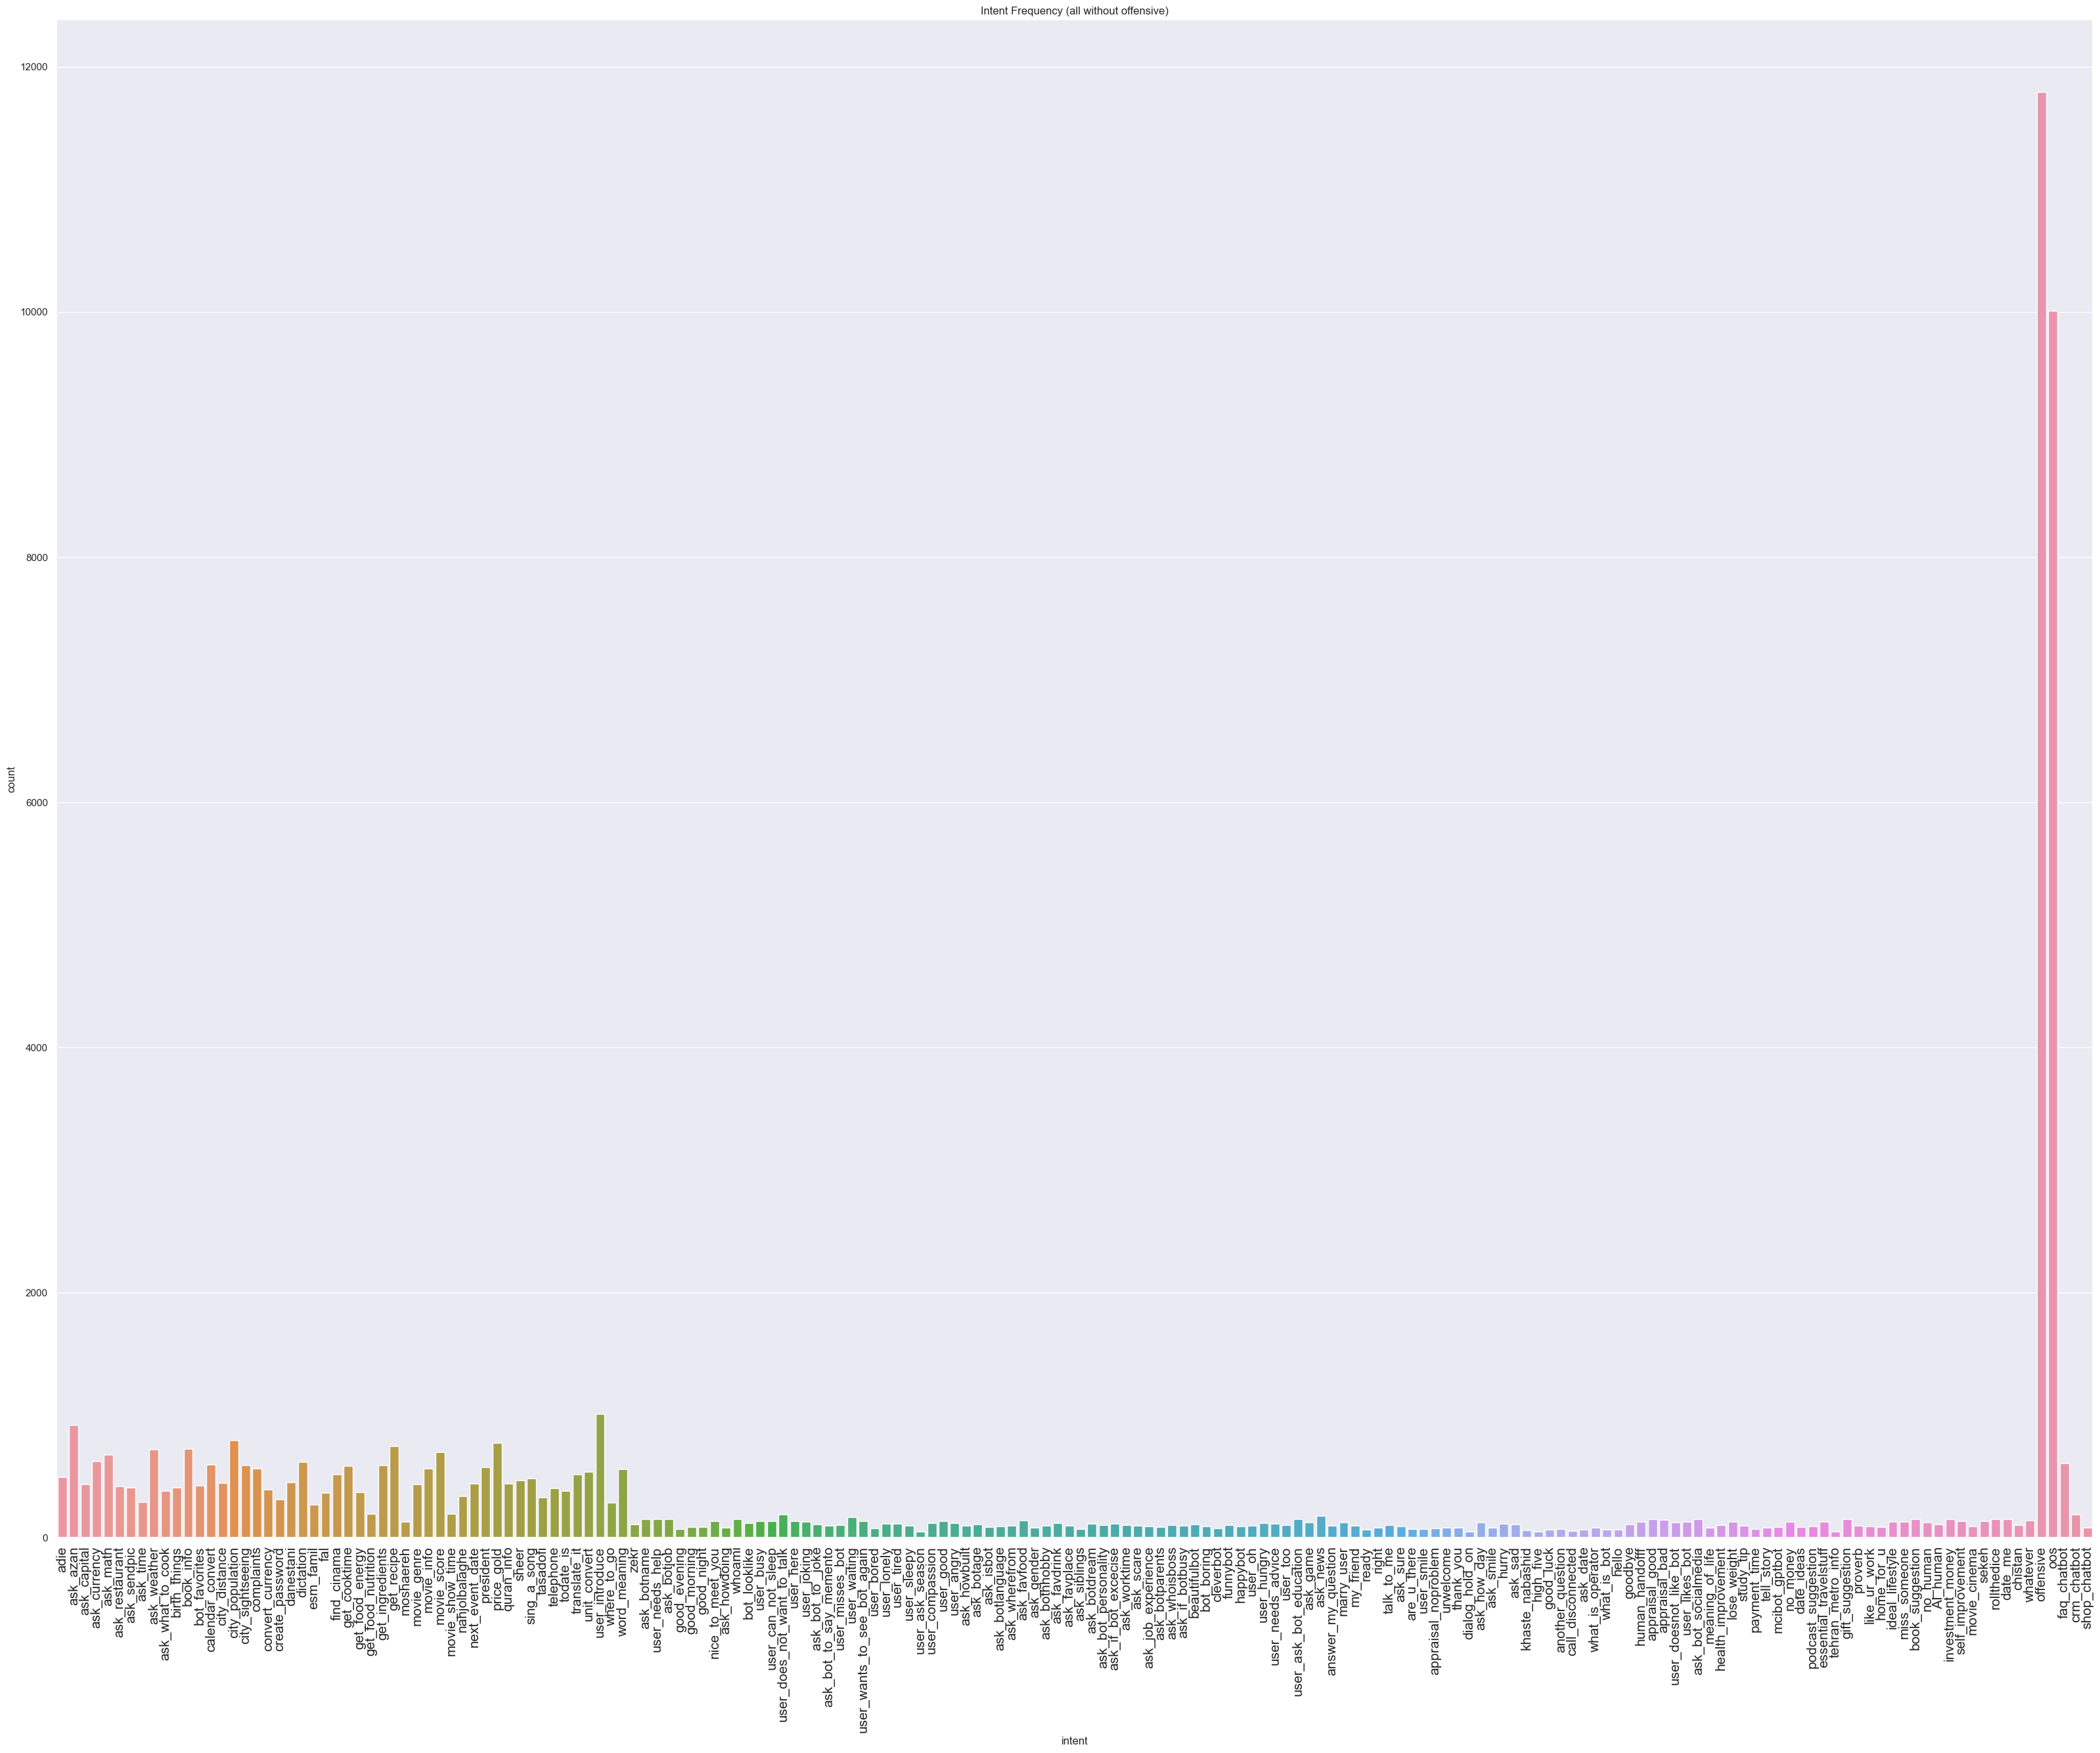

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(40,30)})  #,font_scale=1
g = sns.countplot(data=df,x='intent')
g.set_title('Intent Frequency (all without offensive)')
g.set_xticklabels(labels=df.intent.unique() ,rotation = 90, fontsize=15)
plt.savefig('pictures/all_intent_frequency.png',bbox_inches='tight')#,pad_inches=0)
plt.show()

In [45]:
print("number of labels(classes):",df.intent.nunique())
print(sorted(df.intent.unique()))
df.intent.value_counts()

number of labels(classes): 178
['AI_human', 'adie', 'another_question', 'answer_my_question', 'appraisal_bad', 'appraisal_good', 'appraisal_noproblem', 'are_u_there', 'ask_azan', 'ask_bot_personality', 'ask_bot_socialmedia', 'ask_bot_to _joke', 'ask_bot_to_say_memento', 'ask_botage', 'ask_botdream', 'ask_bothhobby', 'ask_botjob', 'ask_botlanguage', 'ask_botname', 'ask_botparents', 'ask_capital', 'ask_currency', 'ask_date', 'ask_favdrink', 'ask_favfood', 'ask_favplace', 'ask_game', 'ask_gender', 'ask_how_day', 'ask_howbuilt', 'ask_howdoing', 'ask_if_bot_excecise', 'ask_if_botbusy', 'ask_isbot', 'ask_job_experience', 'ask_math', 'ask_news', 'ask_restaurant', 'ask_sad', 'ask_scare', 'ask_sendpic', 'ask_siblings', 'ask_smile', 'ask_sure', 'ask_time', 'ask_weather', 'ask_what_to_cook', 'ask_wherefrom', 'ask_whoisboss', 'ask_worktime', 'beautifulbot', 'birth_things', 'book_info', 'book_suggestion', 'bot_boring', 'bot_favorites', 'bot_looklike', 'calendar_convert', 'call_disconnected', 'chist

intent
offensive            11793
oos                  10010
user_introduce        1008
ask_azan               916
city_population        793
                     ...  
call_disconnected       57
tehran_metro_info       50
user_ask_season         50
dialog_hold_on          50
high_five               48
Name: count, Length: 178, dtype: int64

In [46]:
df.shape

(60834, 4)

## slot

In [47]:
all_slots = []
[all_slots.extend(i.split()) for i in df_with_slots.slots]
pd.Series(all_slots).value_counts()

o                161514
b-city             3217
i-food_name        2831
i-movie            2639
b-food_name        2450
                  ...  
i-month               7
i-year                6
i-user_name           4
i-writer_name         1
b-writer_name         1
Name: count, Length: 139, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: 'pictures/Comparsion_of_slots_frequency.png'

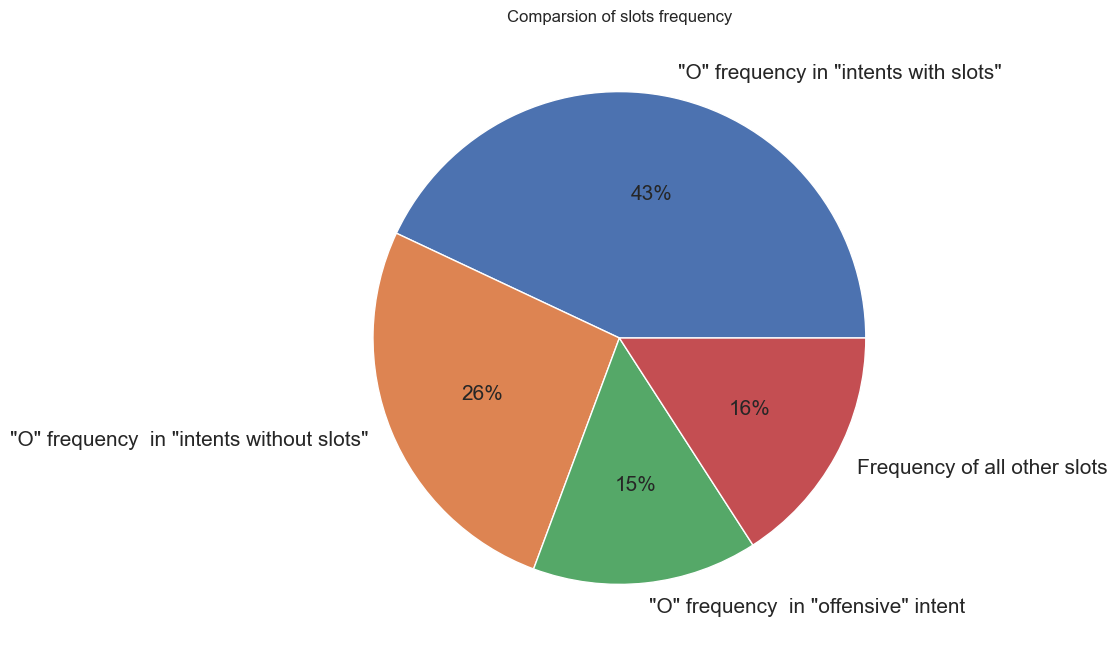

In [48]:
# [33734 , 20651 , 11590, 12458]
# ['o_with_slots', 'o_without_slots', 'o_offensive' , 'all_other_slots']
plt.figure(figsize=(11,8))
plt.pie(x=[33734 , 20651 , 11590, 12458],
        labels=['"O" frequency in "intents with slots"', '"O" frequency  in "intents without slots"', '"O" frequency  in "offensive" intent' , 'Frequency of all other slots'],
       autopct='%.0f%%',
       textprops={'fontsize':15})
# plt.legend(fontsize=10, loc="lower left")
plt.title("Comparsion of slots frequency")
plt.savefig('pictures/Comparsion of slots frequency.png'.replace(" ","_"),bbox_inches='tight')#,pad_inches=0)

plt.show()

In [49]:
pd.Series(all_slots).value_counts().sum() - 33734 - 20651 - 11590

147297

In [50]:
pd.DataFrame(pd.Series(all_slots).value_counts(),columns=['frequency of slots']).to_excel('frequency_of_slots.xlsx')

In [51]:
pd.DataFrame(pd.Series(all_slots).value_counts(),columns=['frequency of slots'])[:30] #.drop('o',axis=0)[:30] #.to_excel('frequency_of_slots.xlsx')

,frequency of slots


FileNotFoundError: [Errno 2] No such file or directory: 'pictures/slots_frequency.png'

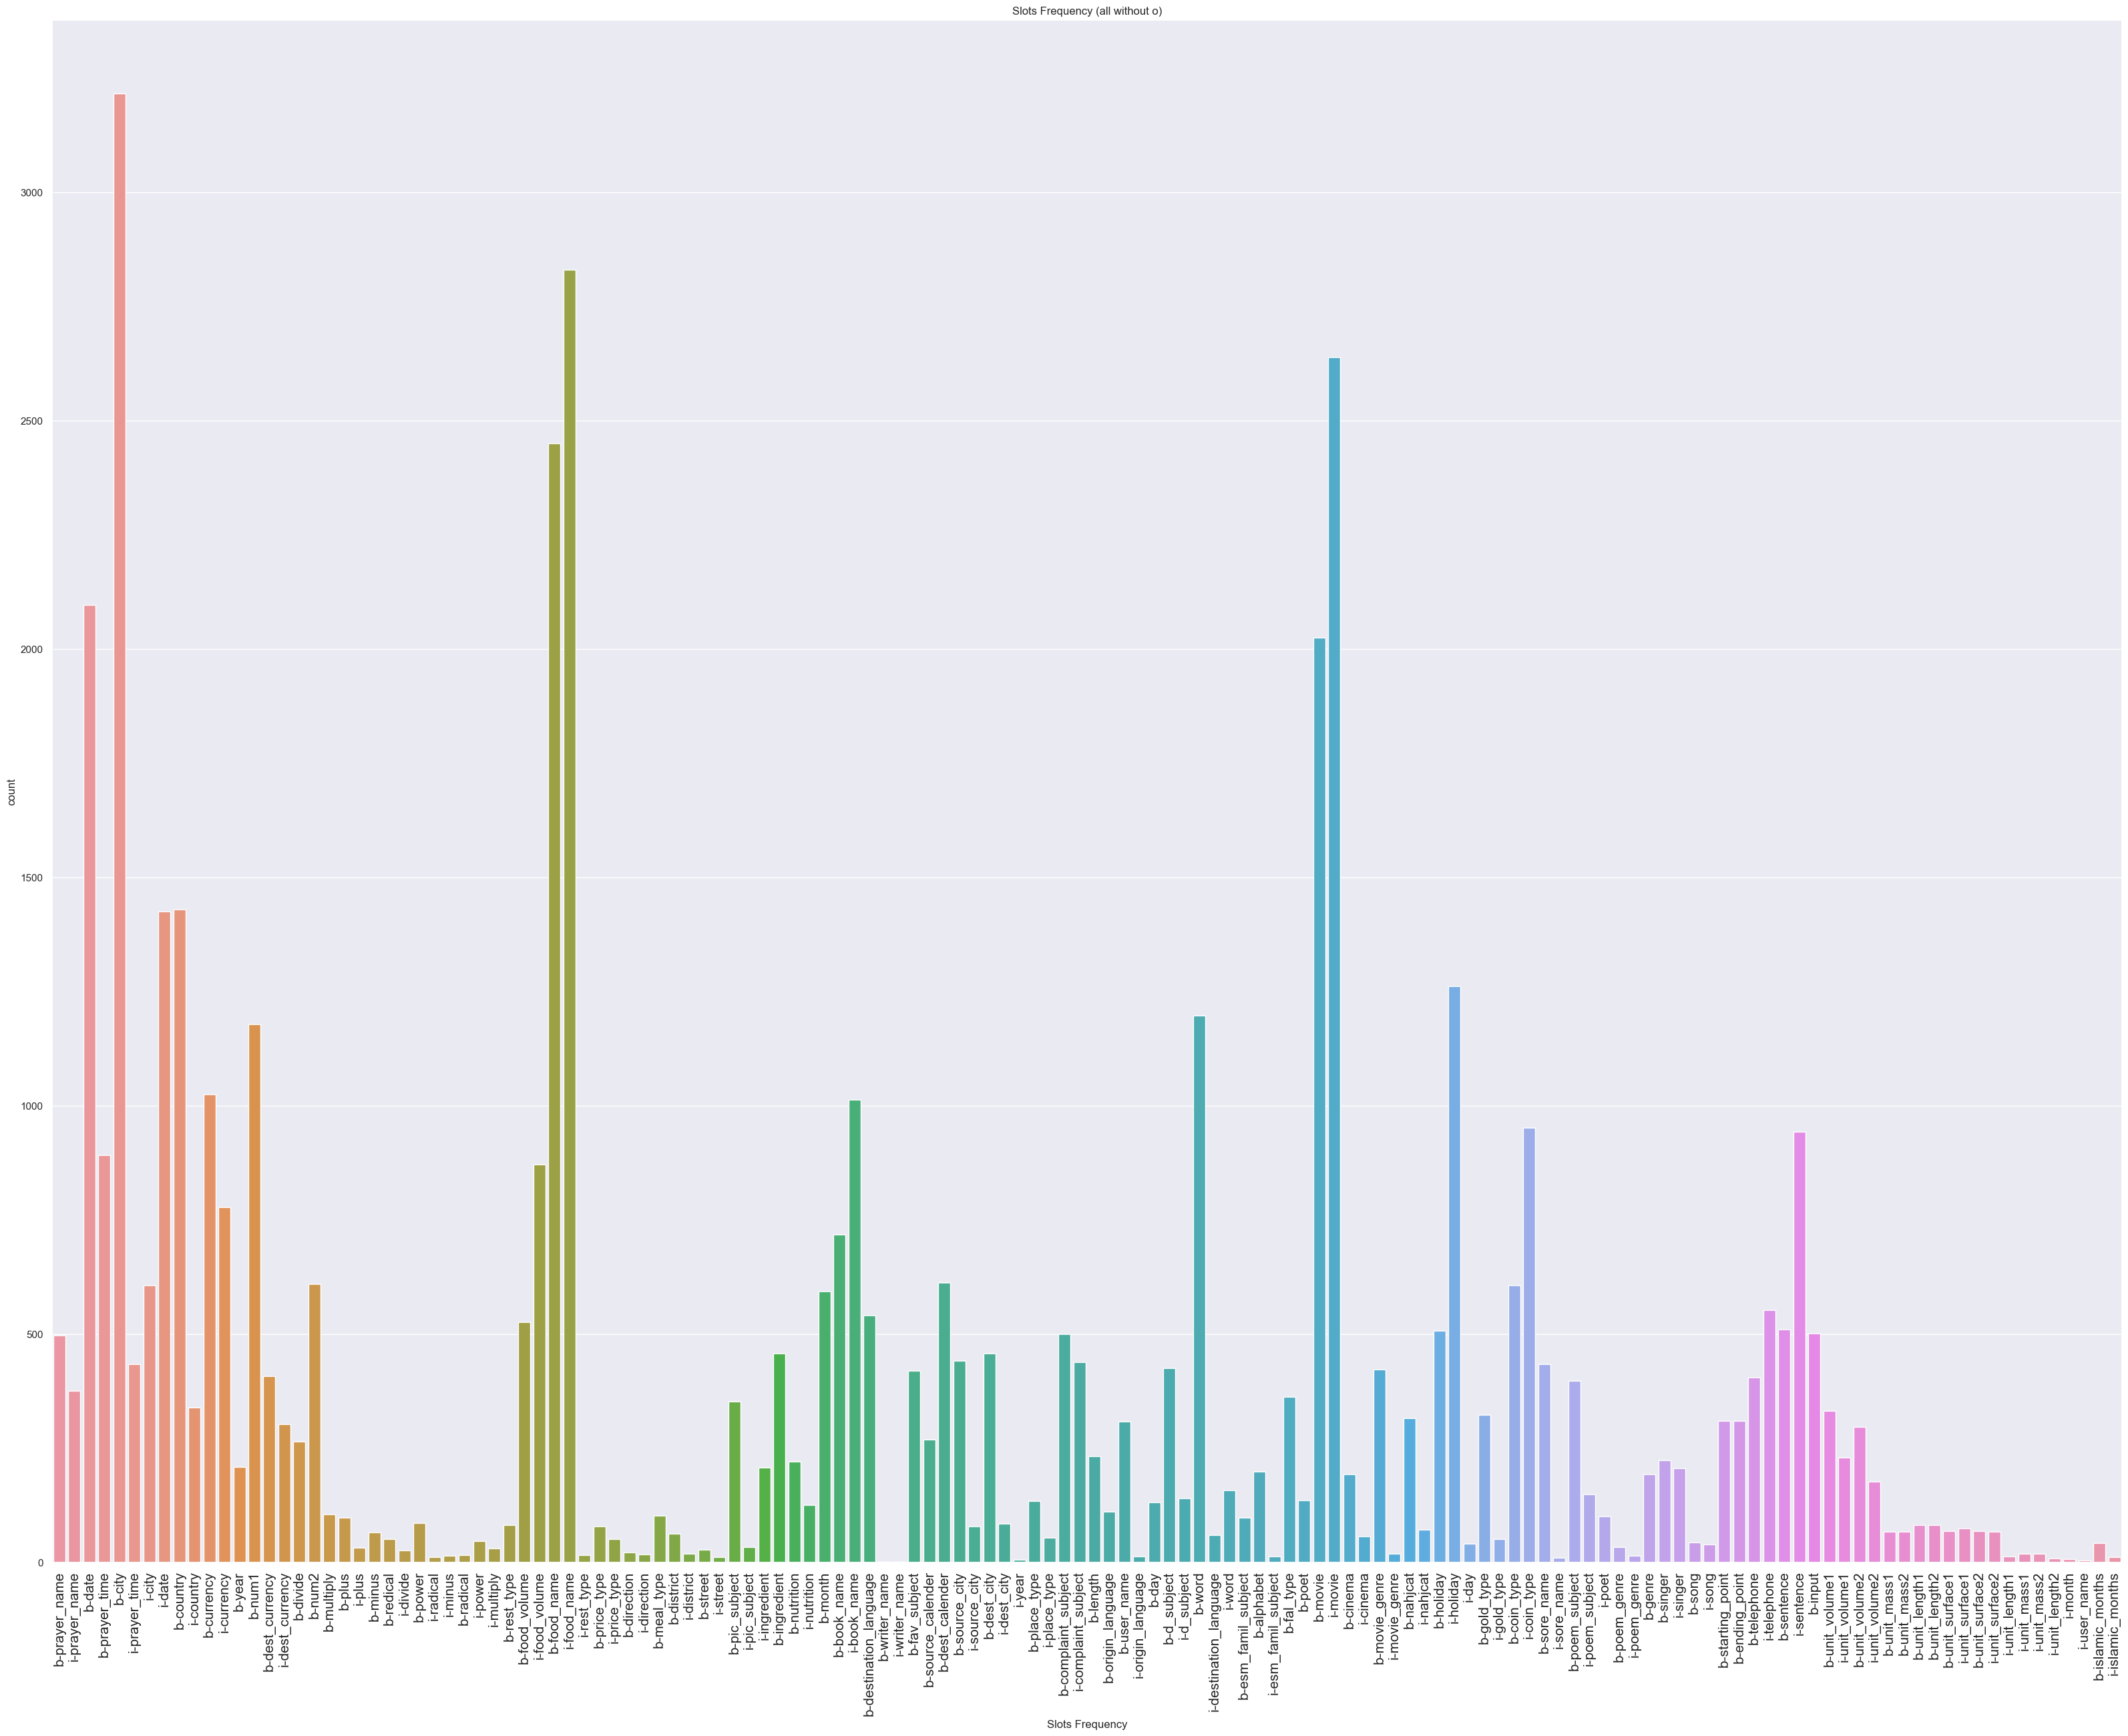

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
dff = pd.DataFrame(pd.Series(all_slots),columns=['Slots Frequency'])
dff.drop(dff[dff['Slots Frequency'] == 'o'].index,inplace=True)
sns.set(rc={'figure.figsize':(40,30)})  #,font_scale=1
g = sns.countplot(data=dff,x='Slots Frequency')
g.set_title('Slots Frequency (all without o)')
g.set_xticklabels(labels=dff['Slots Frequency'].unique() ,rotation = 90, fontsize=15)
plt.savefig('pictures/slots_frequency.png',bbox_inches='tight')#,pad_inches=0)
plt.show()

## text

In [53]:
dict(pd.Series([len(i.split()) for i in df['text']]).value_counts())

{6: 6682,
 7: 6618,
 8: 6310,
 5: 6293,
 9: 5628,
 4: 5425,
 3: 4365,
 10: 3815,
 2: 3175,
 11: 2581,
 12: 1993,
 13: 1670,
 1: 1275,
 14: 1270,
 15: 915,
 16: 593,
 17: 461,
 18: 347,
 19: 274,
 20: 187,
 21: 165,
 22: 106,
 23: 101,
 24: 69,
 25: 64,
 27: 51,
 26: 48,
 28: 37,
 30: 32,
 29: 29,
 34: 17,
 31: 17,
 32: 16,
 37: 15,
 39: 14,
 35: 13,
 33: 13,
 36: 13,
 38: 12,
 46: 12,
 41: 10,
 40: 9,
 43: 7,
 44: 7,
 49: 6,
 48: 6,
 47: 6,
 50: 5,
 42: 5,
 45: 5,
 51: 4,
 53: 4,
 52: 3,
 58: 3,
 68: 3,
 55: 3,
 64: 3,
 77: 2,
 70: 2,
 56: 2,
 60: 2,
 69: 2,
 76: 1,
 54: 1,
 113: 1,
 141: 1,
 63: 1,
 88: 1,
 96: 1,
 78: 1,
 87: 1,
 86: 1,
 73: 1,
 65: 1,
 57: 1,
 61: 1}

FileNotFoundError: [Errno 2] No such file or directory: 'pictures/length_of_texts.png'

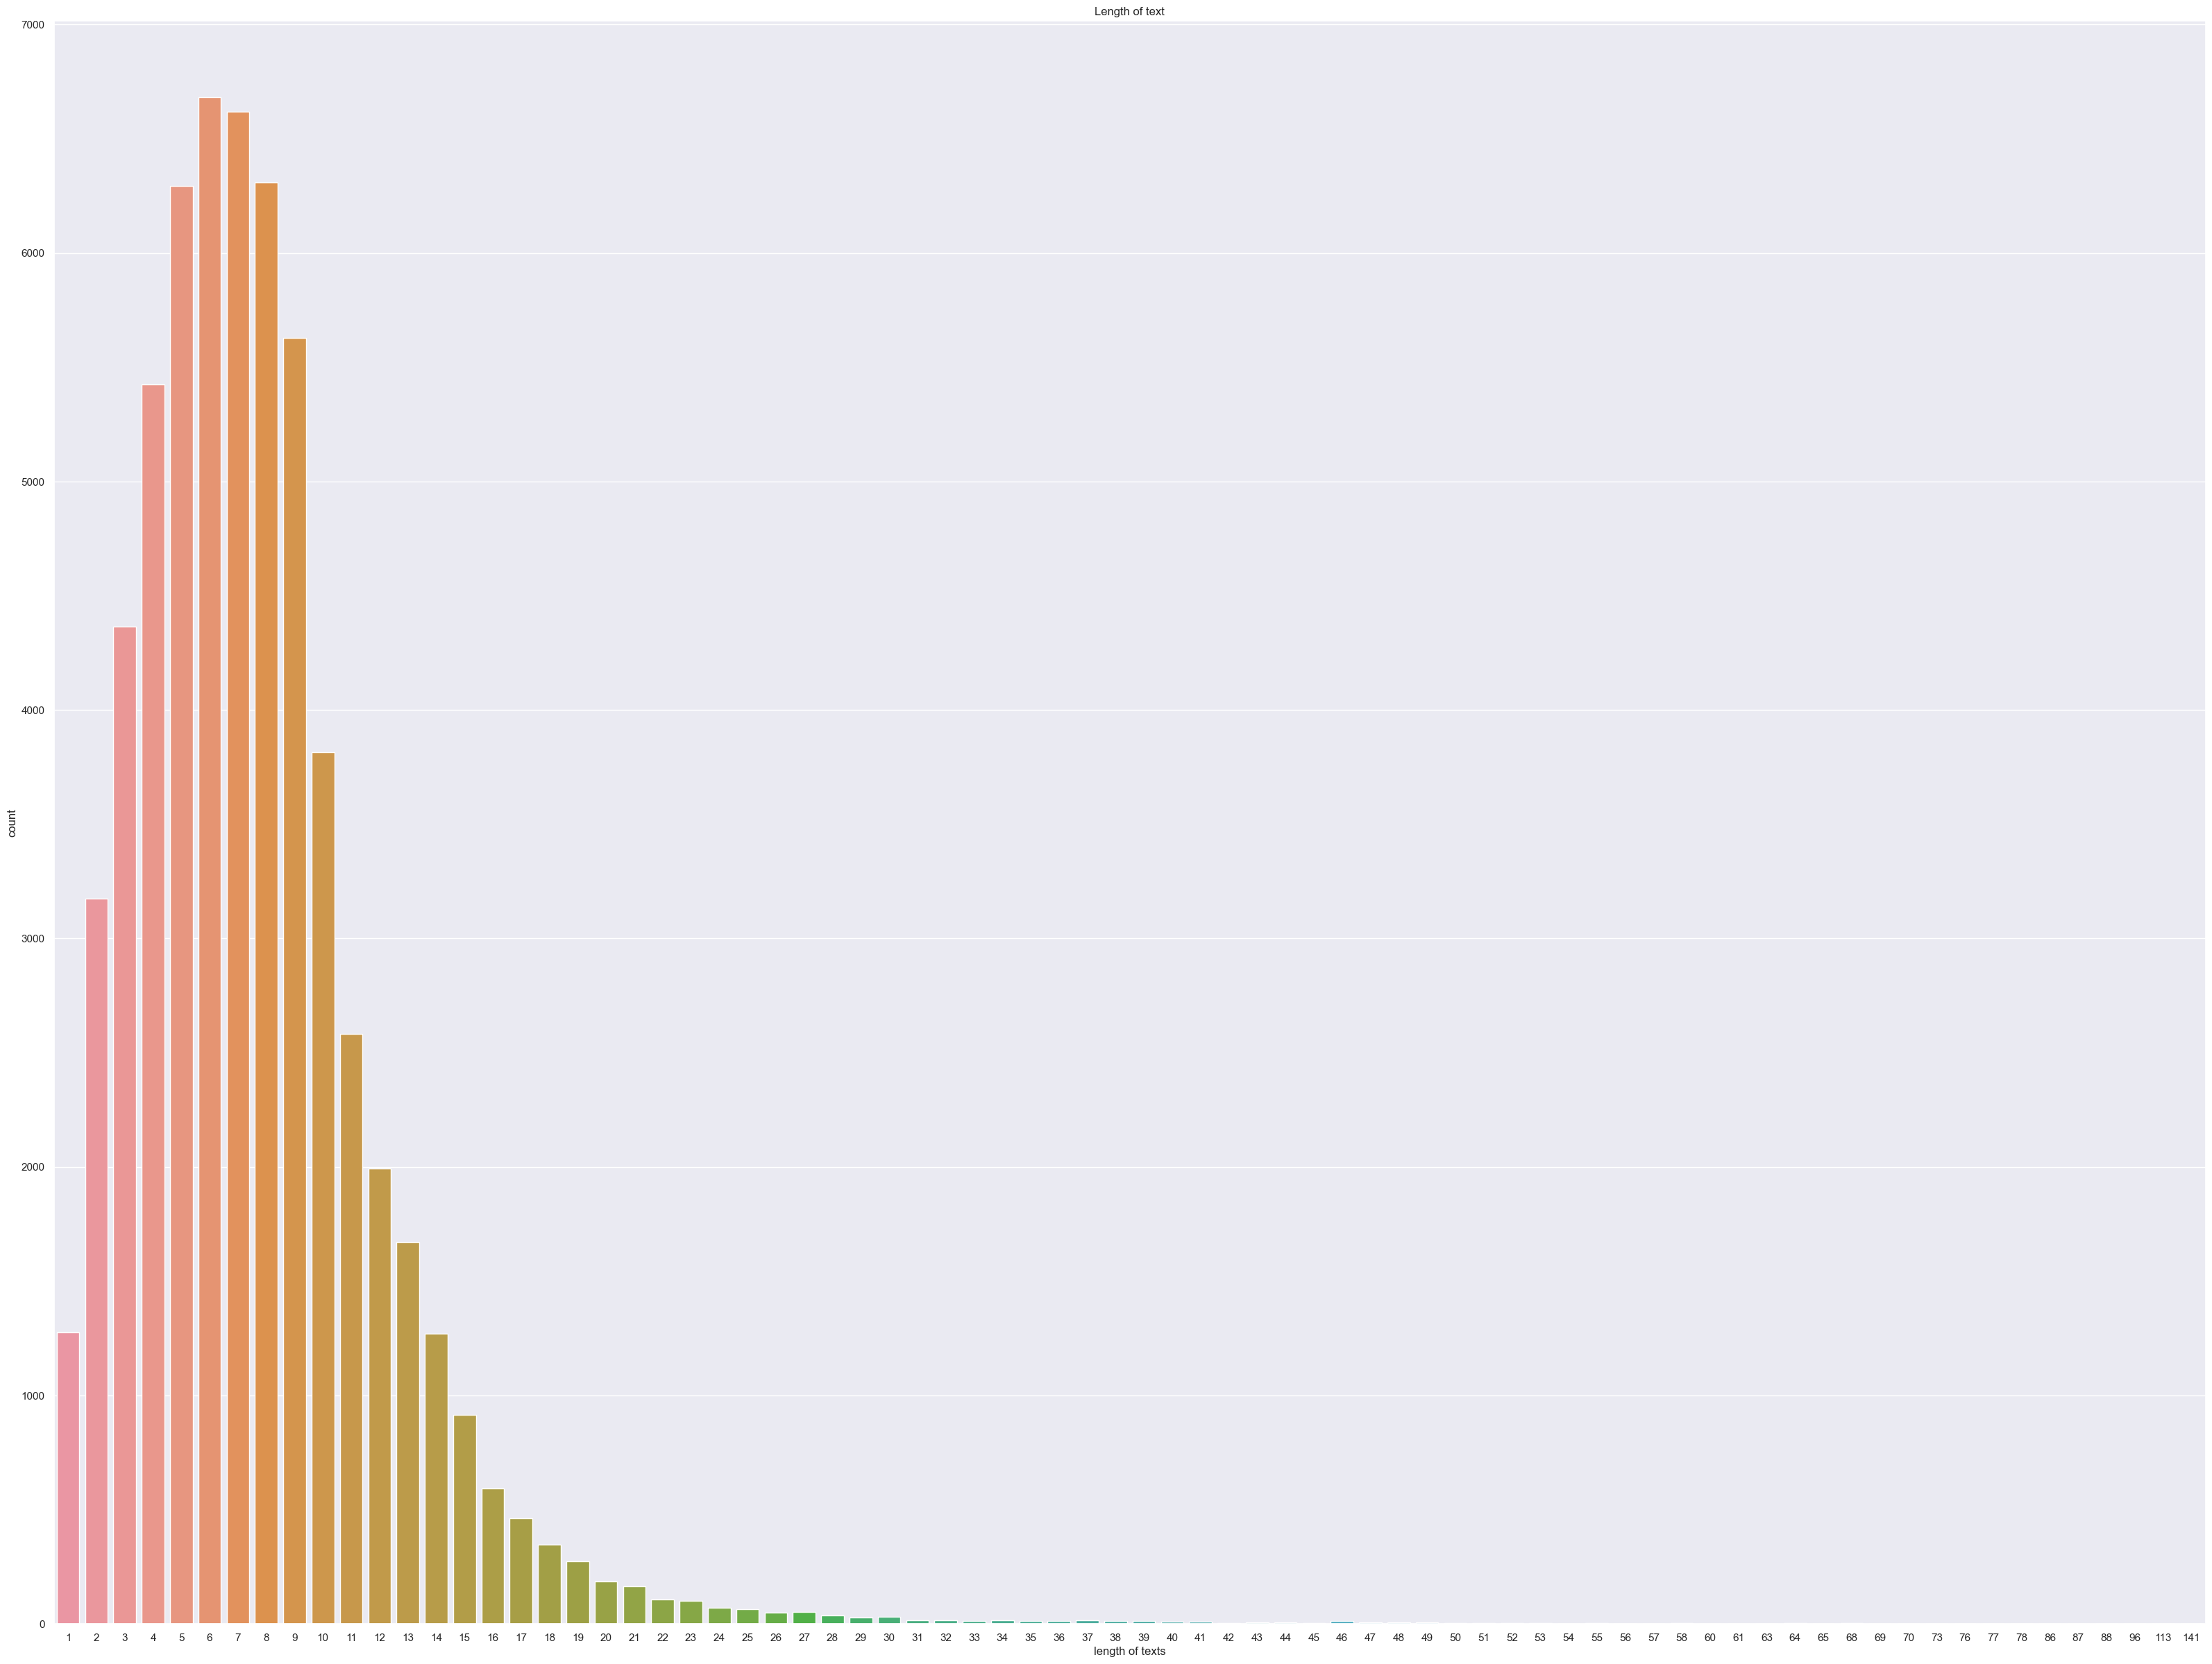

In [54]:
import seaborn as sns
g = sns.countplot(data=pd.DataFrame(pd.Series([len(i.split()) for i in df['text']]),columns=['length of texts']),x='length of texts')
g.set_title('Length of text')
plt.savefig('pictures/length_of_texts.png',bbox_inches='tight')#,pad_inches=0)
plt.show()

In [55]:
pd.Series([len(i.split()) for i in df['text']]).describe(percentiles=[.25,.5,.75,.9,.99])

count    60834.000000
mean         7.653237
std          4.781622
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
90%         13.000000
99%         23.000000
max        141.000000
dtype: float64

# Split Dataset

## Train/Test/Valid

In [56]:
from sklearn.model_selection import train_test_split
pattern_list = list(set(df["pattern_id"].values))

train_patterns, valid_test_patterns = train_test_split(pattern_list, test_size=0.20, random_state=42, shuffle = True)
valid_patterns, test_patterns = train_test_split(valid_test_patterns, test_size=0.50, random_state=42, shuffle = True)

In [57]:
len(pattern_list)

45929

In [58]:
print(f"train patterns = {len(train_patterns)}")
print(f"valid patterns = {len(valid_patterns)}")
print(f"test patterns = {len(test_patterns)}")

train patterns = 36743
valid patterns = 4593
test patterns = 4593


In [59]:
train_df = df[df["pattern_id"].isin(train_patterns)]
valid_df = df[df["pattern_id"].isin(valid_patterns)]
test_df = df[df["pattern_id"].isin(test_patterns)]

In [60]:
print(f"train size = {len(train_df)}")
print(f"valid size = {len(valid_df)}")
print(f"test size = {len(test_df)}")

train size = 48670
valid size = 6123
test size = 6041


In [61]:
train_text = train_df["text"].values
train_intent_label = train_df["intent"].values
train_slot_label = train_df["slots"].values

valid_text = valid_df["text"].values
valid_intent_label = valid_df["intent"].values
valid_slot_label = valid_df["slots"].values

test_text = test_df["text"].values
test_intent_label = test_df["intent"].values
test_slot_label = test_df["slots"].values

In [62]:
import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(), slot_label_dataset[i].split()):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

In [63]:
train_df = process_dataset(train_text, train_intent_label, train_slot_label)
valid_df = process_dataset(valid_text, valid_intent_label, valid_slot_label)
test_df = process_dataset(test_text, test_intent_label, test_slot_label)

In [67]:
train_df

,text,intent_label,slot_tokens,slot_labels
0,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,adie,"[بعد, نمازم, میخوام, دعای, توسل, رو, بخونم, بی...","[o, o, o, b-prayer_name, i-prayer_name, o, o, ..."
1,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,adie,"[لطفا, حرز, حضرت, زهرا, رو, برام, بیار, میخوام...","[o, b-prayer_name, i-prayer_name, i-prayer_nam..."
2,دعای عشرات رو بلدی؟,adie,"[دعای, عشرات, رو, بلدی؟]","[o, b-prayer_name, o, o]"
3,انقدر حالم بده میشه بیای دعای عرفه رو باهم بخونیم,adie,"[انقدر, حالم, بده, میشه, بیای, دعای, عرفه, رو,...","[o, o, o, o, o, b-prayer_name, i-prayer_name, ..."
4,خواندن دعای یستشیر در شرایط فعلی توصیه شده است...,adie,"[خواندن, دعای, یستشیر, در, شرایط, فعلی, توصیه,...","[o, o, b-prayer_name, o, o, o, o, o, o, o, o]"
...,...,...,...,...
48665,چقد بدم خطم وصل شه,shop_chatbot,"[چقد, بدم, خطم, وصل, شه]","[o, o, o, o, o]"
48666,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی...,shop_chatbot,"[قبضمو, دیدم, خیلی, زیاد, اومد, صورتحسابشو, نش...","[o, o, o, o, o, o, o, o, o, o, o]"
48667,میگی قبضم چنده,shop_chatbot,"[میگی, قبضم, چنده]","[o, o, o]"
48668,قبض این ماهو میخوام,shop_chatbot,"[قبض, این, ماهو, میخوام]","[o, o, o, o]"


## K-Fold

In [68]:
len(df)

60834

In [69]:
from sklearn.model_selection import KFold, GroupKFold, train_test_split

FOLD = 2  # 9     #done 0 1 2 3 4 5 7 8
NUMBER_FOLDS = 10
DATE = '14030410'


gkf = GroupKFold(n_splits=NUMBER_FOLDS)#, shuffle=True, random_state=42)   # is not randomized at all random_state=None
# kf = KFold(n_splits=10, shuffle=True, random_state=43)  # kf.get_n_splits()
# result = next(gkf.split(df, df.intent, df.pattern_id ))
# print(result)
# pd.merge(df.iloc[result[0]],df.iloc[result[1]],on=['pattern_id'])
print(gkf.get_n_splits(df, df.intent, df.pattern_id ))

train_valid_index = list(gkf.split(df, df.intent, df.pattern_id ))[FOLD][0]
from sklearn.model_selection import train_test_split
train_index, valid_index = train_test_split(train_valid_index, test_size=0.10, random_state=42, shuffle = True)

test_index = list(gkf.split(df, df.intent, df.pattern_id ))[FOLD][1]
print('train+valid length:',len(train_valid_index),train_valid_index)
print('test length:',len(test_index),test_index)

10
train+valid length: 54750 [    0     1     2 ... 60831 60832 60833]
test length: 6084 [   26    35    64 ... 60796 60811 60821]


In [70]:
train_df = df.iloc[train_index]
valid_df = df.iloc[valid_index]
test_df = df.iloc[test_index]

In [71]:
train_text = train_df["text"].values
train_intent_label = train_df["intent"].values
train_slot_label = train_df["slots"].values

valid_text = valid_df["text"].values
valid_intent_label = valid_df["intent"].values
valid_slot_label = valid_df["slots"].values

test_text = test_df["text"].values
test_intent_label = test_df["intent"].values
test_slot_label = test_df["slots"].values

In [72]:
import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(), slot_label_dataset[i].split()):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

train_df = process_dataset(train_text, train_intent_label, train_slot_label)
valid_df = process_dataset(valid_text, valid_intent_label, valid_slot_label)
test_df = process_dataset(test_text, test_intent_label, test_slot_label)

# observing folds for conflicts

In [73]:
# Fold 0
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   19    33    34 ... 36064 36074 36075]

# Fold 1
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   47    48    49 ... 36055 36065 36076]

# Fold 2
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   69    70    71 ... 36056 36066 36077]

# Fold 3
# train+valid length: 32476 [    0     1     2 ... 36082 36083 36084]
# test length: 3609 [   15    16    17 ... 36067 36072 36078]

# Fold 4
# train+valid length: 32476 [    0     1     9 ... 36082 36083 36084]
# test length: 3609 [    2     3     4 ... 36059 36068 36079]

# Fold 5
# train+valid length: 32477 [    0     1     2 ... 36082 36083 36084]
# test length: 3608 [  107   108   109 ... 36060 36069 36080]

# Fold 6
# train+valid length: 32477 [    0     1     2 ... 36082 36083 36084]
# test length: 3608 [   30    31    32 ... 36070 36071 36081]

# Fold 7
# train+valid length: 32477 [    2     3     4 ... 36081 36083 36084]
# test length: 3608 [    0     1     9 ... 36061 36073 36082]

# Fold 8
# train+valid length: 32477 [    0     1     2 ... 36081 36082 36084]
# test length: 3608 [   39    40    41 ... 36052 36062 36083]

# Fold 9
# train+valid length: 32477 [    0     1     2 ... 36081 36082 36083]
# test length: 3608 [   13    14    36 ... 36053 36063 36084]

In [74]:
train_df = df.iloc[train_index]
valid_df = df.iloc[valid_index]
test_df = df.iloc[test_index]

In [75]:
train_text = train_df["text"]
train_intent_label = train_df["intent"]
train_slot_label = train_df["slots"]

valid_text = valid_df["text"]
valid_intent_label = valid_df["intent"]
valid_slot_label = valid_df["slots"]

test_text = test_df["text"]
test_intent_label = test_df["intent"]
test_slot_label = test_df["slots"]

In [76]:
# from sklearn.model_selection import train_test_split
# train_text, valid_text, train_intent_label, valid_intent_label, train_slot_label, valid_slot_label  = train_test_split(df['text'], df['intent'], df['slots'], 
#                                                                     test_size=0.15,
#                                                                     shuffle = True,
#                                                                     random_state = 42)#,
#                                                                     # stratify=df['intent'])

# train_text, valid_test_text, train_labels, valid_test_labels = train_test_split(df['text'], df['intent'], df['slots'] 
#                                                                     test_size=0.15,
#                                                                     shuffle = True,
#                                                                     random_state = 42,
#                                                                     stratify=df['intent'])

In [77]:
# print(train_text[:2])
# print(train_intent_label[:2])
# print(train_slot_label[:2])

In [78]:
train_text = train_text.values
train_intent_label = train_intent_label.values
train_slot_label = train_slot_label.values

valid_text = valid_text.values
valid_intent_label = valid_intent_label.values
valid_slot_label = valid_slot_label.values

test_text = test_text.values
test_intent_label = test_intent_label.values
test_slot_label = test_slot_label.values

In [79]:
import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(), slot_label_dataset[i].split()):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

train_df = process_dataset(train_text, train_intent_label, train_slot_label)
valid_df = process_dataset(valid_text, valid_intent_label, valid_slot_label)
test_df = process_dataset(test_text, test_intent_label, test_slot_label)

In [80]:
# Check that if number of tokens in sentences is equal to its slots number or not
for i in range(len(train_df)):
    slots = train_df['slot_labels'][i]
    tokens = train_df['slot_tokens'][i]
    assert len(slots) == len(tokens), f"sentence length doesn't match to slots length i = {i}, tokens={tokens} slots = {slots}"

# Tokenization

In [24]:
# Load the BERT tokenizer
from transformers import AutoTokenizer
model_name = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


7.65974632166413
141


<Axes: >

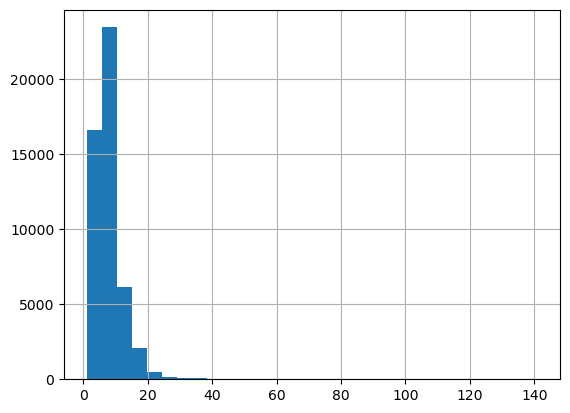

In [25]:
import numpy as np
seq_len = [len(i.split()) for i in train_df['text']]
print(np.mean(seq_len))
print(np.max(seq_len))
pd.Series(seq_len).hist(bins = 30)

### label2id & id2label

In [82]:
import json
intent_id2label = dict([(i,v) for i,v in enumerate(sorted(df.intent.unique()))])
intent_label2id = dict([(v,k) for k,v in intent_id2label.items()])
print(len(intent_label2id))
with open('intent_label2id.json', 'w') as f:
    json.dump(intent_label2id, f)
intent_id2label

178


{0: 'AI_human',
 1: 'adie',
 2: 'another_question',
 3: 'answer_my_question',
 4: 'appraisal_bad',
 5: 'appraisal_good',
 6: 'appraisal_noproblem',
 7: 'are_u_there',
 8: 'ask_azan',
 9: 'ask_bot_personality',
 10: 'ask_bot_socialmedia',
 11: 'ask_bot_to _joke',
 12: 'ask_bot_to_say_memento',
 13: 'ask_botage',
 14: 'ask_botdream',
 15: 'ask_bothhobby',
 16: 'ask_botjob',
 17: 'ask_botlanguage',
 18: 'ask_botname',
 19: 'ask_botparents',
 20: 'ask_capital',
 21: 'ask_currency',
 22: 'ask_date',
 23: 'ask_favdrink',
 24: 'ask_favfood',
 25: 'ask_favplace',
 26: 'ask_game',
 27: 'ask_gender',
 28: 'ask_how_day',
 29: 'ask_howbuilt',
 30: 'ask_howdoing',
 31: 'ask_if_bot_excecise',
 32: 'ask_if_botbusy',
 33: 'ask_isbot',
 34: 'ask_job_experience',
 35: 'ask_math',
 36: 'ask_news',
 37: 'ask_restaurant',
 38: 'ask_sad',
 39: 'ask_scare',
 40: 'ask_sendpic',
 41: 'ask_siblings',
 42: 'ask_smile',
 43: 'ask_sure',
 44: 'ask_time',
 45: 'ask_weather',
 46: 'ask_what_to_cook',
 47: 'ask_where

In [83]:
slot_label = []
[slot_label.extend(i.split()) for i in train_slot_label]
[slot_label.extend(i.split()) for i in valid_slot_label]
[slot_label.extend(i.split()) for i in test_slot_label]
slot_label2id = dict([(y,x) for x,y in enumerate(sorted(set(slot_label)))])  
slot_id2label = dict([(y,x) for x,y in slot_label2id.items()])
print(len(slot_label2id))
with open('slot_label2id.json', 'w') as f:
    json.dump(slot_label2id, f)
slot_label2id

139


{'b-alphabet': 0,
 'b-book_name': 1,
 'b-cinema': 2,
 'b-city': 3,
 'b-coin_type': 4,
 'b-complaint_subject': 5,
 'b-country': 6,
 'b-currency': 7,
 'b-d_subject': 8,
 'b-date': 9,
 'b-day': 10,
 'b-dest_calender': 11,
 'b-dest_city': 12,
 'b-dest_currency': 13,
 'b-destination_language': 14,
 'b-direction': 15,
 'b-district': 16,
 'b-divide': 17,
 'b-ending_point': 18,
 'b-esm_famil_subject': 19,
 'b-fal_type': 20,
 'b-fav_subject': 21,
 'b-food_name': 22,
 'b-food_volume': 23,
 'b-genre': 24,
 'b-gold_type': 25,
 'b-holiday': 26,
 'b-ingredient': 27,
 'b-input': 28,
 'b-islamic_months': 29,
 'b-length': 30,
 'b-meal_type': 31,
 'b-minus': 32,
 'b-month': 33,
 'b-movie': 34,
 'b-movie_genre': 35,
 'b-multiply': 36,
 'b-nahjcat': 37,
 'b-num1': 38,
 'b-num2': 39,
 'b-nutrition': 40,
 'b-origin_language': 41,
 'b-pic_subject': 42,
 'b-place_type': 43,
 'b-plus': 44,
 'b-poem_genre': 45,
 'b-poem_subject': 46,
 'b-poet': 47,
 'b-power': 48,
 'b-prayer_name': 49,
 'b-prayer_time': 50,
 'b

In [28]:
if pd.Series([len(i.split()) for i in df.text]).describe()['min'] < 1:
    print(pd.Series([len(i.split()) for i in df.text]).describe())
    df["Sentence"]=df["text"].str.split()
    df["WordsCount"]=df["Sentence"].apply(lambda x: len(x))
    df=df[(df["WordsCount"]>= 1)]# &(df["WordsCount"]<=8)]
    df = df.drop(['Sentence','WordsCount'],axis=1)
print(pd.Series([len(i.split()) for i in df.text]).describe())

count    60834.000000
mean         7.653237
std          4.781622
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max        141.000000
dtype: float64


In [29]:
# df = df.reset_index(drop=True)

In [30]:
# input_text = "HuggingFace Transformers is great!"
# tokenized_inputs = tokenizer(input_text, padding="max_length", max_length=20, return_tensors="pt")
# word_ids = tokenized_inputs.word_ids()
# print(word_ids)

### Tokenize_and_align_slot_labels

In [31]:
MAX_SEQ_LEN = 64

def tokenize_and_align_labels(examples, slot_label2id=slot_label2id, intent_label2id=intent_label2id):
    tokenized_inputs = tokenizer(examples["slot_tokens"],truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                               is_split_into_words=True, return_token_type_ids=False)
                                
    slot_labels = []
    intent_label = []
    for i, label in enumerate(examples["slot_labels"]):
        word_ids = tokenized_inputs.word_ids()
        previous_word_id = None
        label_ids = []
        for word_id in word_ids:  # Set the special tokens to 0.
            if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
                label_ids.append(-100)
            elif word_id != previous_word_id: # We set the label for the first token of each word.
                label_ids.append(slot_label2id[examples["slot_labels"][word_id]])
            else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
                # label_ids.append(label[word_idx] if label_all_tokens else -100)
                label_ids.append(-100)
            previous_word_id = word_id

        slot_labels.append(label_ids)
        intent_label.append(intent_label2id[examples["intent_label"]])
    tokenized_inputs["slot_labels"] = slot_labels[0]
    tokenized_inputs["intent_label"] = intent_label[0]
    # x, y_slot, y_intent
    return tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], tokenized_inputs['slot_labels'], tokenized_inputs['intent_label']

In [32]:
train_df.iloc[5]

text                 خواهش میکنم کاری نکردم
intent_label                      urwelcome
slot_tokens     [خواهش, میکنم, کاری, نکردم]
slot_labels                    [o, o, o, o]
Name: 5, dtype: object

In [33]:
from tqdm import tqdm

tokenized_train = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(train_df))):
    tokenized_train['input_ids'].append(tokenize_and_align_labels(train_df.iloc[i])[0])
    tokenized_train['attention_mask'].append(tokenize_and_align_labels(train_df.iloc[i])[1])
    tokenized_train['slot_labels'].append(tokenize_and_align_labels(train_df.iloc[i])[2])
    tokenized_train['intent_label'].append(tokenize_and_align_labels(train_df.iloc[i])[3])

tokenized_valid = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(valid_df))):
    tokenized_valid['input_ids'].append(tokenize_and_align_labels(valid_df.iloc[i])[0])
    tokenized_valid['attention_mask'].append(tokenize_and_align_labels(valid_df.iloc[i])[1])
    tokenized_valid['slot_labels'].append(tokenize_and_align_labels(valid_df.iloc[i])[2])
    tokenized_valid['intent_label'].append(tokenize_and_align_labels(valid_df.iloc[i])[3])

tokenized_test = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(test_df))):
    tokenized_test['input_ids'].append(tokenize_and_align_labels(test_df.iloc[i])[0])
    tokenized_test['attention_mask'].append(tokenize_and_align_labels(test_df.iloc[i])[1])
    tokenized_test['slot_labels'].append(tokenize_and_align_labels(test_df.iloc[i])[2])
    tokenized_test['intent_label'].append(tokenize_and_align_labels(test_df.iloc[i])[3])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6084/6084 [00:08<00:00, 680.79it/s]


In [34]:
train_df.iloc[2126]

text                 کون همه رو مالیدی
intent_label                 offensive
slot_tokens     [کون, همه, رو, مالیدی]
slot_labels               [o, o, o, o]
Name: 2126, dtype: object

In [73]:
k = 1
print(len(tokenized_train['input_ids'])) # all of train 
print(train_df.text[k])
print(len(tokenized_train['input_ids'][k]),tokenized_train['input_ids'][k])
print(len(tokenized_train['attention_mask'][k]),tokenized_train['attention_mask'][k])
print(len(tokenized_train['slot_labels'][k]),tokenized_train['slot_labels'][k])
print((tokenized_train['intent_label'][k]),tokenized_train['intent_label'][k])
print([slot_id2label[i] for i in tokenized_train['slot_labels'][k] if i != -100]) 

48670
لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم
64 [0, 61752, 29484, 1469, 9748, 163646, 3085, 1359, 5150, 2547, 3058, 232747, 41160, 900, 376, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
64 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
64 [-100, 138, 49, -100, 114, 114, 138, 138, -100, 138, -100, 138, 138, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
1 1
['o', 'b-prayer_name', 'i-prayer_name', 'i-prayer_name', 'o', 'o', 'o', 'o', 'o']


In [35]:
# check length for correct alligning
for i in range(len(tokenized_train['input_ids'])):
    if len(tokenized_train['input_ids'][i]) == len(tokenized_train['slot_labels'][i]):
        continue
    else:
        print(i, tokenized_train['input_ids'][i], tokenized_train['slot_labels'][i])

### Convert to Tensors

Before feeding the data to the model, **integer sequences** should be cobverted into tensors.  

In [36]:
tokenized_train.keys()

dict_keys(['input_ids', 'attention_mask', 'slot_labels', 'intent_label'])

In [37]:
# for train set
train_input_ids = torch.tensor(tokenized_train['input_ids'])
train_attention_mask = torch.tensor(tokenized_train['attention_mask'])
train_label_intent = torch.tensor(tokenized_train['intent_label'])
train_label_slot = torch.tensor(tokenized_train['slot_labels'])

# for validation set
valid_input_ids = torch.tensor(tokenized_valid['input_ids'])
valid_attention_mask = torch.tensor(tokenized_valid['attention_mask'])
valid_label_intent = torch.tensor(tokenized_valid['intent_label'])
valid_label_slot = torch.tensor(tokenized_valid['slot_labels'])

# # for test set
test_input_ids = torch.tensor(tokenized_test['input_ids'])
test_attention_mask = torch.tensor(tokenized_test['attention_mask'])
test_label_intent = torch.tensor(tokenized_test['intent_label'])
test_label_slot = torch.tensor(tokenized_test['slot_labels'])

### DataLoaders

We create DataLoaders for train and validation sets for **automatic mini-batch processing**. The `DataLoader` class provides the Python iterable which is memory efficient. 

The `TensorDataset` wraps tensor such that each sample will be retrieved by indexing tensors along the first dimension. The `RandomSampler` class helps **shuffling** the train set; while in validation set, `SequentialSampler` is enough. 

In [38]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
BATCH_SIZE = 128

# wrap tensors
train_data = TensorDataset(train_input_ids, train_attention_mask, train_label_intent, train_label_slot)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# wrap tensors
valid_data = TensorDataset(valid_input_ids, valid_attention_mask, valid_label_intent, valid_label_slot)
# sampler for sampling the data during training
valid_sampler = SequentialSampler(valid_data)
# dataLoader for validation set
valid_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size=BATCH_SIZE)

# wrap tensors
test_data = TensorDataset(test_input_ids, test_attention_mask, test_label_intent, test_label_slot)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

In [39]:
len(train_dataloader)

385

In [40]:
# ch_iterator = iter(train_dataloader)  # output of dataloader is iterator with 3 tensor that i defined
# one = next(ch_iterator)
# print('intent_label.size(batch_size, number of class)',one[2].shape)
# print('slot_label.size(batch_size,sequence_length)  ',one[3].shape)
# print(one)

# Model

### Import BERT Model

We import BERT Pretrained model from the [Hugging Face](https://huggingface.co/) `transformers` python package. Click [here](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertmodel#transformers.BertModel) for more details on the BERT Model.

In [41]:
import transformers

transformers.__version__

'4.29.2'

In [42]:
# import BERT-base pretrained model
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("xlm-roberta-large")  # config.update({'output_hidden_states':True})
bert = AutoModel.from_pretrained("xlm-roberta-large",output_hidden_states=True) 

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequence

In [43]:
# freeze all the parameters for 2 epoch
# for param in bert.parameters():
#     param.requires_grad = True  # False=freezing True=Not freezing

### Define Model Architecture

As usual, for defining the network architecture, we define a class inheriting from `torch.nn.Module`. Remember to overwrite `__init__` and `forward` fucntions for making the network architecture, and the forward pass, respectively. As you may know, the `__init__` function is called once when instantiating an object from the class, and `forward` function is called whenever you call the object for making the predictions.

In [44]:
# AutoModel  with  output_hidden_states=True
# bert(one[0], one[1]).keys()   # odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [45]:
config.hidden_size

1024

In [46]:
config.output_hidden_states

False

In [47]:
import torch
import torch.nn as nn
from torch.cuda import amp
from torch.cuda.amp import autocast

class JointIntentAndSlotFillingModel(nn.Module):

    def __init__(self, bert, config, intent_labels_num, slot_labels_num):
        super(JointIntentAndSlotFillingModel,self).__init__()
        self.bert = bert
        self.fc1 = nn.Linear(config.hidden_size,config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.intent_classifier = nn.Linear(config.hidden_size, intent_labels_num)
        self.fc2 = nn.Linear(config.hidden_size,config.hidden_size)
        self.slot_classifier = nn.Linear(config.hidden_size, slot_labels_num)
        # self.softmax_intent = nn.LogSoftmax(dim=1)
        # self.softmax_slot = nn.LogSoftmax(dim=2)


    # @amp.autocast()
    def forward(self, input_ids, attention_mask):
        # two outputs from BERT
        outputs = self.bert(input_ids, attention_mask)
        
        cls_token = outputs[1]   # cls_token is pooled_output     # torch.Size([8, 1024])
        dense_for_intent = self.fc1(cls_token)
        intent_logits = self.intent_classifier(self.dropout(dense_for_intent))      # torch.Size([8, 60])
 
        last_hidden_state = outputs[0]                            # torch.Size([8, 64, 1024])     
        dense_for_slot = self.fc2(last_hidden_state)
        slot_logits = self.slot_classifier(self.dropout(dense_for_slot))  # torch.Size([8, 64, 109])
        
        return intent_logits, slot_logits
        # intent_classes = self.softmax_intent(intent_logits)                         # torch.Size([8, 60])
        # slot_classes = self.softmax_slot(slot_logits)                             # torch.Size([8, 109, 64])
        # return intent_classes, slot_classes

You have defined the `BERT_Arch` class. Now, it is time to instantiate an object from the class and sent it to GPU.

In [48]:
# pass the pre-trained BERT to our define architecture
model = JointIntentAndSlotFillingModel(bert, config,
                                       intent_labels_num=len(intent_label2id),
                                       slot_labels_num=len(slot_label2id))

# push the model to GPU
model = model.to('cuda')

In [49]:
sum([p.numel() for p in model.parameters()])  # for 6 kernel Conv1d + last 4 hidden layer with NLLLOSS:  657420290
                                              # for 4 kernel Conv1d + last 4 hidden layer with NLLLOSS:  610229250

562314557

In [50]:
# # load model from before
# PATH = 'saved_weights.pt'
# model.load_state_dict(torch.load(PATH, map_location='cuda'), strict=True)

In [51]:
# model

# Training

### Optimizer

We use `AdamW` optimizer from `transformers` package. If you are interested for more details of the *Decoupled Weight Decay Regularization* algorithm, implemented in the class, please refer to [this paper](https://arxiv.org/abs/1711.05101). 

In [52]:
import warnings

# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
LEARNING_RATE = 5e-5  # 5e-3  5e-5better  5e-6
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
len(train_dataloader) # = number of steps in 1 epoch = 186-->193-->229

385

In [54]:
# scheduler
from transformers import get_linear_schedule_with_warmup
EPOCHS = 40 #60
total_step =  len(train_dataloader) * EPOCHS
num_warmup_steps = 0.1 * len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_step)

### Loss function

As the dataset is imbalance, we prefer to find Class Weights and feed them to the loss function for a fair error computation.

In [55]:
#compute the class weights
import numpy as np 
from sklearn.utils.class_weight import compute_class_weight

class_wts_intents = compute_class_weight(class_weight ='balanced', classes = np.unique(train_intent_label), y=train_intent_label)
# print(class_wts)

# convert class weights to tensor
weights_intents = torch.tensor(class_wts_intents,dtype=torch.float)
weights_intents = weights_intents.to(device)

In [56]:
all_slots = []
for i in train_slot_label: all_slots.extend(i.split())

class_wts_slots = compute_class_weight(class_weight ='balanced', classes = np.unique(all_slots), y=all_slots)
weights_slots= torch.tensor(class_wts_slots,dtype=torch.float)
weights_slots = weights_slots.to(device)


In [57]:
# loss function
# loss_fn_intent = nn.NLLLoss() #(weight=weights) 
loss_fn_intent  = nn.CrossEntropyLoss(weight=weights_intents)
# loss_fn_slot = nn.CrossEntropyLoss()
def loss_fn_slot(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss() #weight=weights_slots)
    active_loss = mask.view(-1) == 1
    # print('output.shape:',output.shape)
    active_logits = output.view(-1, num_labels)  # torch.Size([batch_size, 109])
    # print('target.shape:', target.shape, 'active_labels:',active_loss.shape, 'active_logits:',active_logits.shape )
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target))
    loss = lfn(active_logits, active_labels)
    return loss

### Train Function

We fine-Tune our customized BERT architecture on the small supervised spam classificatiopn dataset. We review the train set for `epochs` times. You may refer to the Section **3-5. Start Model Training** for the main function of the training phase. In every epoch, we feed mini-batches to the network. With the frozen BERT parameters, we update the two dense layers defined on the top of the BERT model for our downstream task. The following `train()` function is in charge of computing the **average loss** and making the **predictions** for every epoch during the training.  


In [58]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [59]:
# function to train the model
# from tqdm.notebook import tqdm

def train():
    model.train()
    
    total_preds_intent= []
    total_preds_slot = []
    batch_loss = []

    for batch in train_dataloader:  #enumerate(train_dataloader)

        batch = [r.to(device) for r in batch]
        sent_id, mask, intent_label, slot_labels = batch

        model.zero_grad()  
        
        # preds = model(sent_id, mask)
        intent_preds, slot_preds = model(sent_id, mask)
        # loss = cross_entropy(preds, labels)
        loss_intent = loss_fn_intent(intent_preds, intent_label)
        loss_slot = loss_fn_slot(slot_preds, slot_labels, mask, len(slot_label2id))
        # loss_slot = loss_fn_slot(slot_preds, slot_labels)
        loss = (loss_slot + loss_intent)/2
        # print('loss:', loss_intent, loss_slot, loss)
        
        batch_loss.append(loss.item())
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        # preds=preds.detach().cpu().numpy()
        # total_preds.append(preds)
        intent_preds=intent_preds.detach().cpu().numpy()
        total_preds_intent.append(intent_preds)
        slot_preds=slot_preds.detach().cpu().numpy()
        total_preds_slot.append(slot_preds)
        
    epoch_loss_train = np.mean(batch_loss)
    # total_preds  = np.concatenate(total_preds, axis=0)
    total_preds_intent  = np.concatenate(total_preds_intent, axis=0)
    total_preds_slot  = np.concatenate(total_preds_slot, axis=0)
    return epoch_loss_train, total_preds_intent, total_preds_slot

### Evaluate Function

In [60]:
def evaluate(valid_dataloader=valid_dataloader):
    # print("\nEvaluating...") 
    model.eval()

    batch_loss = 0
    # total_preds = []
    total_preds_intent= []
    total_preds_slot = []
    
    for step,batch in enumerate(valid_dataloader): ##enumerate(loop)
        # if step % 50 == 0 and not step == 0:
        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, intent_label, slot_labels = batch

        # deactivate autograd
        with torch.no_grad():
            # preds = model(sent_id, mask)
            intent_preds, slot_preds = model(sent_id, mask)
            # loss = cross_entropy(preds, labels)
            loss_intent = loss_fn_intent(intent_preds, intent_label)
            loss_slot = loss_fn_slot(slot_preds, slot_labels, mask, len(slot_label2id)) 
            # loss_slot = loss_fn_slot(slot_preds, slot_labels)
            loss = (loss_slot + loss_intent)/2
            
            batch_loss = batch_loss + loss.item()
            # preds = preds.detach().cpu().numpy()
            # total_preds.append(preds)
            intent_preds=intent_preds.detach().cpu().numpy()
            total_preds_intent.append(intent_preds)
            slot_preds=slot_preds.detach().cpu().numpy()
            total_preds_slot.append(slot_preds)
            
    epoch_loss_valid = batch_loss / len(valid_dataloader) 
    # total_preds  = np.concatenate(total_preds, axis=0)
    total_preds_intent  = np.concatenate(total_preds_intent, axis=0)
    total_preds_slot  = np.concatenate(total_preds_slot, axis=0)
    
    return epoch_loss_valid, total_preds_intent, total_preds_slot

In [61]:
def delete_100(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != -100:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new

In [62]:
# functions for phrasal evaluation
slotname = list(i[2:] for i in list(slot_id2label.values()))

def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

pair_bi = []
for i in slotname[74:]:
    pair_bi.append(find_indices(slotname,i))
    
pair_bi_dict = dict([(i[0],i[1]) for i in pair_bi if len(i)==2])   
# len(pair_bi)
# pair_bi
####################################################################
# my_list = [i.item() for i in valid_label_slot[0] if i != -100 ]
def i_to_200(alist):
    alist_new = alist.copy()
    for i,token in enumerate(alist_new):
        if token in pair_bi_dict.keys():  #range(74):
    # for i in pair_bi:
    #     if len(i) == 2:
    #         if i[0] in alist_new:
                j = 1
                k = token
                if len(alist_new) == (i+j):
                    continue
                while alist_new[i+j] == pair_bi_dict[token]:    #alist_new.index(i[0]) == i[1]   or alist_new[i+j]
                    alist_new[i+j] = -200    #alist_new.index(i[0])
                    k += 200 
                    j += 1
                    if len(alist_new) == (i+j):
                        break
                alist_new[i] = k
    return alist_new #, alist     

# i_to_200(my_list)   
####################################################################
def delete_200(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != -200:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new
####################################################################
def delete_134(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != 134:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new
#########################################################################
# functions for token evaluation

def fscore_micro_without_o(y_true_slot , y_pred_slot):
    classification_report_without_o = pd.DataFrame(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True)).transpose()[:-4]
    return sum(classification_report_without_o['f1-score']*classification_report_without_o['support']) / sum(classification_report_without_o['support'])

In [63]:
len(intent_label2id),len(slot_label2id)

(178, 139)

### Phase 2 Results - 14030409

In [102]:
DATE = "14030409"

In [103]:
# %%capture captured_output
# All intents with oos (800 sample)

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

# slot token level
f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []
f1_micro_without_o = []


# slot phrase level
f1_macro_phrasal_slot = []
f1_micro_phrasal_slot = []
precision_micro_phrasal_slot = []
recall_micro_phrasal_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    
    # token-level
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    f1_micro_without_o.append(fscore_micro_without_o(y_true_slot, y_pred_slot))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)) 
    
    # phrase-level micro:
    # recall_strict
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
    # precision_strict
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
    p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
    r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
    precision_micro_phrasal_slot.append(r)
    recall_micro_phrasal_slot.append(p)
    f1_micro_phrasal_slot.append((2*p*r)/(p+r))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                      'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,#'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro Token':f1_macro_slot,  'Slot F1 Micro Token':f1_micro_slot, 'Slot F1 Micro Without O Token':f1_micro_without_o,
                      #'Slot F1 Macro Phrasal':f1_macro_phrasal_slot,
                      'Slot F1 Micro Phrasal':f1_micro_phrasal_slot, 'Slot Precision Micro Phrasal':precision_micro_phrasal_slot, 'Slot Recall Micro Phrasal':recall_micro_phrasal_slot})
    df_results.index += 1; df_results.index.name='epoch'
    
    # df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
    #                    'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
    #                   'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    # df_results.index += 1; df_results.index.name = 'epoch'
    
    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        # torch.save(model.state_dict(), f'models/xlmlarge_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.pt')
        # torch.save(model.state_dict(), f'models/xlmlarge_177intent(2offensiveAs1)_145slot_FOLD.pt')
        torch.save(model.state_dict(), f'models/nlu_xlmlarge_14030409.pt')

# %%writefile log.txt
# print(captured_output.stdout)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.270688,2.378681,0.181978,0.238935,0.044840,0.911939,0.140778,0.910732,0.929179,0.893003
2,1.539376,0.749573,0.701766,0.764658,0.253305,0.952367,0.532148,0.941236,0.957235,0.925764
3,0.491984,0.453167,0.781347,0.819860,0.440160,0.974221,0.777038,0.973465,0.977680,0.969286
4,0.309336,0.269129,0.835035,0.888127,0.599329,0.984172,0.873764,0.984575,0.985871,0.983282
5,0.232664,0.315589,0.837252,0.868365,0.683569,0.985738,0.897915,0.986346,0.986787,0.985906
6,0.175725,0.280118,0.840176,0.883390,0.726148,0.988783,0.921784,0.988657,0.989242,0.988073
7,0.135386,0.261080,0.850194,0.878818,0.788585,0.991078,0.938091,0.991253,0.991563,0.990944
8,0.100757,0.250135,0.848509,0.881267,0.835729,0.992365,0.948284,0.992479,0.992567,0.992390
9,0.080548,0.247929,0.854795,0.896946,0.801881,0.992236,0.946725,0.992413,0.992590,0.992235


Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [4:07:21<00:00, 371.04s/it]


In [104]:
display(df_results)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.270688,2.378681,0.181978,0.238935,0.044840,0.911939,0.140778,0.910732,0.929179,0.893003
2,1.539376,0.749573,0.701766,0.764658,0.253305,0.952367,0.532148,0.941236,0.957235,0.925764
3,0.491984,0.453167,0.781347,0.819860,0.440160,0.974221,0.777038,0.973465,0.977680,0.969286
4,0.309336,0.269129,0.835035,0.888127,0.599329,0.984172,0.873764,0.984575,0.985871,0.983282
5,0.232664,0.315589,0.837252,0.868365,0.683569,0.985738,0.897915,0.986346,0.986787,0.985906
6,0.175725,0.280118,0.840176,0.883390,0.726148,0.988783,0.921784,0.988657,0.989242,0.988073
7,0.135386,0.261080,0.850194,0.878818,0.788585,0.991078,0.938091,0.991253,0.991563,0.990944
8,0.100757,0.250135,0.848509,0.881267,0.835729,0.992365,0.948284,0.992479,0.992567,0.992390
9,0.080548,0.247929,0.854795,0.896946,0.801881,0.992236,0.946725,0.992413,0.992590,0.992235


### Phase 2 Results - 14030405

In [78]:
DATE = "14030405"

In [79]:
# %%capture captured_output
# All intents with oos (800 sample)

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

# slot token level
f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []
f1_micro_without_o = []


# slot phrase level
f1_macro_phrasal_slot = []
f1_micro_phrasal_slot = []
precision_micro_phrasal_slot = []
recall_micro_phrasal_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    
    # token-level
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    f1_micro_without_o.append(fscore_micro_without_o(y_true_slot, y_pred_slot))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)) 
    
    # phrase-level micro:
    # recall_strict
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
    # precision_strict
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
    p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
    r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
    precision_micro_phrasal_slot.append(r)
    recall_micro_phrasal_slot.append(p)
    f1_micro_phrasal_slot.append((2*p*r)/(p+r))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                      'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,#'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro Token':f1_macro_slot,  'Slot F1 Micro Token':f1_micro_slot, 'Slot F1 Micro Without O Token':f1_micro_without_o,
                      #'Slot F1 Macro Phrasal':f1_macro_phrasal_slot,
                      'Slot F1 Micro Phrasal':f1_micro_phrasal_slot, 'Slot Precision Micro Phrasal':precision_micro_phrasal_slot, 'Slot Recall Micro Phrasal':recall_micro_phrasal_slot})
    df_results.index += 1; df_results.index.name='epoch'
    
    # df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
    #                    'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
    #                   'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    # df_results.index += 1; df_results.index.name = 'epoch'
    
    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        # torch.save(model.state_dict(), f'models/xlmlarge_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.pt')
        # torch.save(model.state_dict(), f'models/xlmlarge_177intent(2offensiveAs1)_145slot_FOLD.pt')
        torch.save(model.state_dict(), f'models/nlu_xlmlarge_14030405.pt')

# %%writefile log.txt
# print(captured_output.stdout)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.383758,2.727874,0.063195,0.101788,0.018487,0.892359,0.065727,0.904580,0.925203,0.884856
2,2.033498,1.119167,0.647094,0.733451,0.186096,0.940700,0.419158,0.929122,0.947571,0.911378
3,0.745196,0.441373,0.803932,0.835078,0.387824,0.966852,0.713655,0.962341,0.970337,0.954476
4,0.350571,0.399827,0.804958,0.814946,0.541910,0.980634,0.851721,0.979500,0.982458,0.976561
5,0.248047,0.289256,0.836751,0.876792,0.653635,0.985607,0.896460,0.985312,0.986072,0.984553
6,0.209198,0.302153,0.835939,0.878402,0.693408,0.985080,0.899542,0.984801,0.986733,0.982877
7,0.176098,0.279627,0.842711,0.869544,0.743662,0.988895,0.925398,0.988897,0.989312,0.988484
8,0.164471,0.259013,0.852809,0.884361,0.736449,0.989295,0.926934,0.989615,0.990193,0.989038
9,0.112331,0.229244,0.864638,0.894186,0.787894,0.991213,0.942584,0.990694,0.991185,0.990203


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [6:07:45<00:00, 367.75s/it]


In [80]:
display(df_results)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.383758,2.727874,0.063195,0.101788,0.018487,0.892359,0.065727,0.904580,0.925203,0.884856
2,2.033498,1.119167,0.647094,0.733451,0.186096,0.940700,0.419158,0.929122,0.947571,0.911378
3,0.745196,0.441373,0.803932,0.835078,0.387824,0.966852,0.713655,0.962341,0.970337,0.954476
4,0.350571,0.399827,0.804958,0.814946,0.541910,0.980634,0.851721,0.979500,0.982458,0.976561
5,0.248047,0.289256,0.836751,0.876792,0.653635,0.985607,0.896460,0.985312,0.986072,0.984553
6,0.209198,0.302153,0.835939,0.878402,0.693408,0.985080,0.899542,0.984801,0.986733,0.982877
7,0.176098,0.279627,0.842711,0.869544,0.743662,0.988895,0.925398,0.988897,0.989312,0.988484
8,0.164471,0.259013,0.852809,0.884361,0.736449,0.989295,0.926934,0.989615,0.990193,0.989038
9,0.112331,0.229244,0.864638,0.894186,0.787894,0.991213,0.942584,0.990694,0.991185,0.990203


### Phase 1 Results

In [358]:
print(f'models/xlmlarge_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.pt')

NameError: name 'DATE' is not defined

#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################
#############################################################################################################

In [359]:
# %%capture captured_output
# All intents with oos (800 sample)

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

# slot token level
f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []
f1_micro_without_o = []


# slot phrase level
f1_macro_phrasal_slot = []
f1_micro_phrasal_slot = []
precision_micro_phrasal_slot = []
recall_micro_phrasal_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    
    # token-level
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    f1_micro_without_o.append(fscore_micro_without_o(y_true_slot, y_pred_slot))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)) 
    
    # phrase-level micro:
    # recall_strict
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
    # precision_strict
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
    p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
    r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
    precision_micro_phrasal_slot.append(r)
    recall_micro_phrasal_slot.append(p)
    f1_micro_phrasal_slot.append((2*p*r)/(p+r))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                      'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,#'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro Token':f1_macro_slot,  'Slot F1 Micro Token':f1_micro_slot, 'Slot F1 Micro Without O Token':f1_micro_without_o,
                      #'Slot F1 Macro Phrasal':f1_macro_phrasal_slot,
                      'Slot F1 Micro Phrasal':f1_micro_phrasal_slot, 'Slot Precision Micro Phrasal':precision_micro_phrasal_slot, 'Slot Recall Micro Phrasal':recall_micro_phrasal_slot})
    df_results.index += 1; df_results.index.name='epoch'
    
    # df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
    #                    'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
    #                   'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    # df_results.index += 1; df_results.index.name = 'epoch'
    
    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        # torch.save(model.state_dict(), f'models/xlmlarge_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.pt')
        torch.save(model.state_dict(), f'models/xlmlarge_177intent(2offensiveAs1)_145slot_FOLD.pt')

# %%writefile log.txt
# print(captured_output.stdout)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.450503,2.667614,0.071389,0.104608,0.013524,0.893109,0.031206,0.908332,0.924217,0.892984


NameError: name 'DATE' is not defined

In [1178]:
display(df_results)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.608477,2.803363,0.000491,0.009236,0.007800,0.907726,0.000000,0.921868,0.936458,0.907726
2,2.451059,1.766603,0.384941,0.409483,0.086644,0.940107,0.297742,0.936824,0.949630,0.924358
3,1.229594,0.633378,0.765683,0.794335,0.203814,0.959351,0.508662,0.954834,0.965172,0.944715
4,0.485446,0.332803,0.843377,0.847906,0.373538,0.975289,0.735281,0.974205,0.978914,0.969542
5,0.277769,0.240840,0.856086,0.834667,0.474930,0.981490,0.813062,0.981156,0.984411,0.977923
6,0.206632,0.251810,0.851153,0.854988,0.557993,0.985532,0.857301,0.985690,0.987348,0.984038
7,0.185450,0.258026,0.852357,0.839286,0.612253,0.986818,0.873591,0.986964,0.988343,0.985588
8,0.131834,0.203524,0.881684,0.883929,0.717736,0.991044,0.915624,0.990748,0.991945,0.989553
9,0.099643,0.193911,0.893115,0.904249,0.741448,0.991549,0.922654,0.991477,0.992229,0.990727


In [1179]:
print(y_true_slot_p_recall[40:80],"\n", y_pred_slot_p_recall[40:80])
print(y_true_slot_p_precision[40:80],"\n", y_pred_slot_p_precision[40:80])

[55, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 69, 131, 21, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131] 
 [55, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 69, 131, 21, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]
[55, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 69, 131, 21, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131] 
 [55, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 69, 131, 21, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]


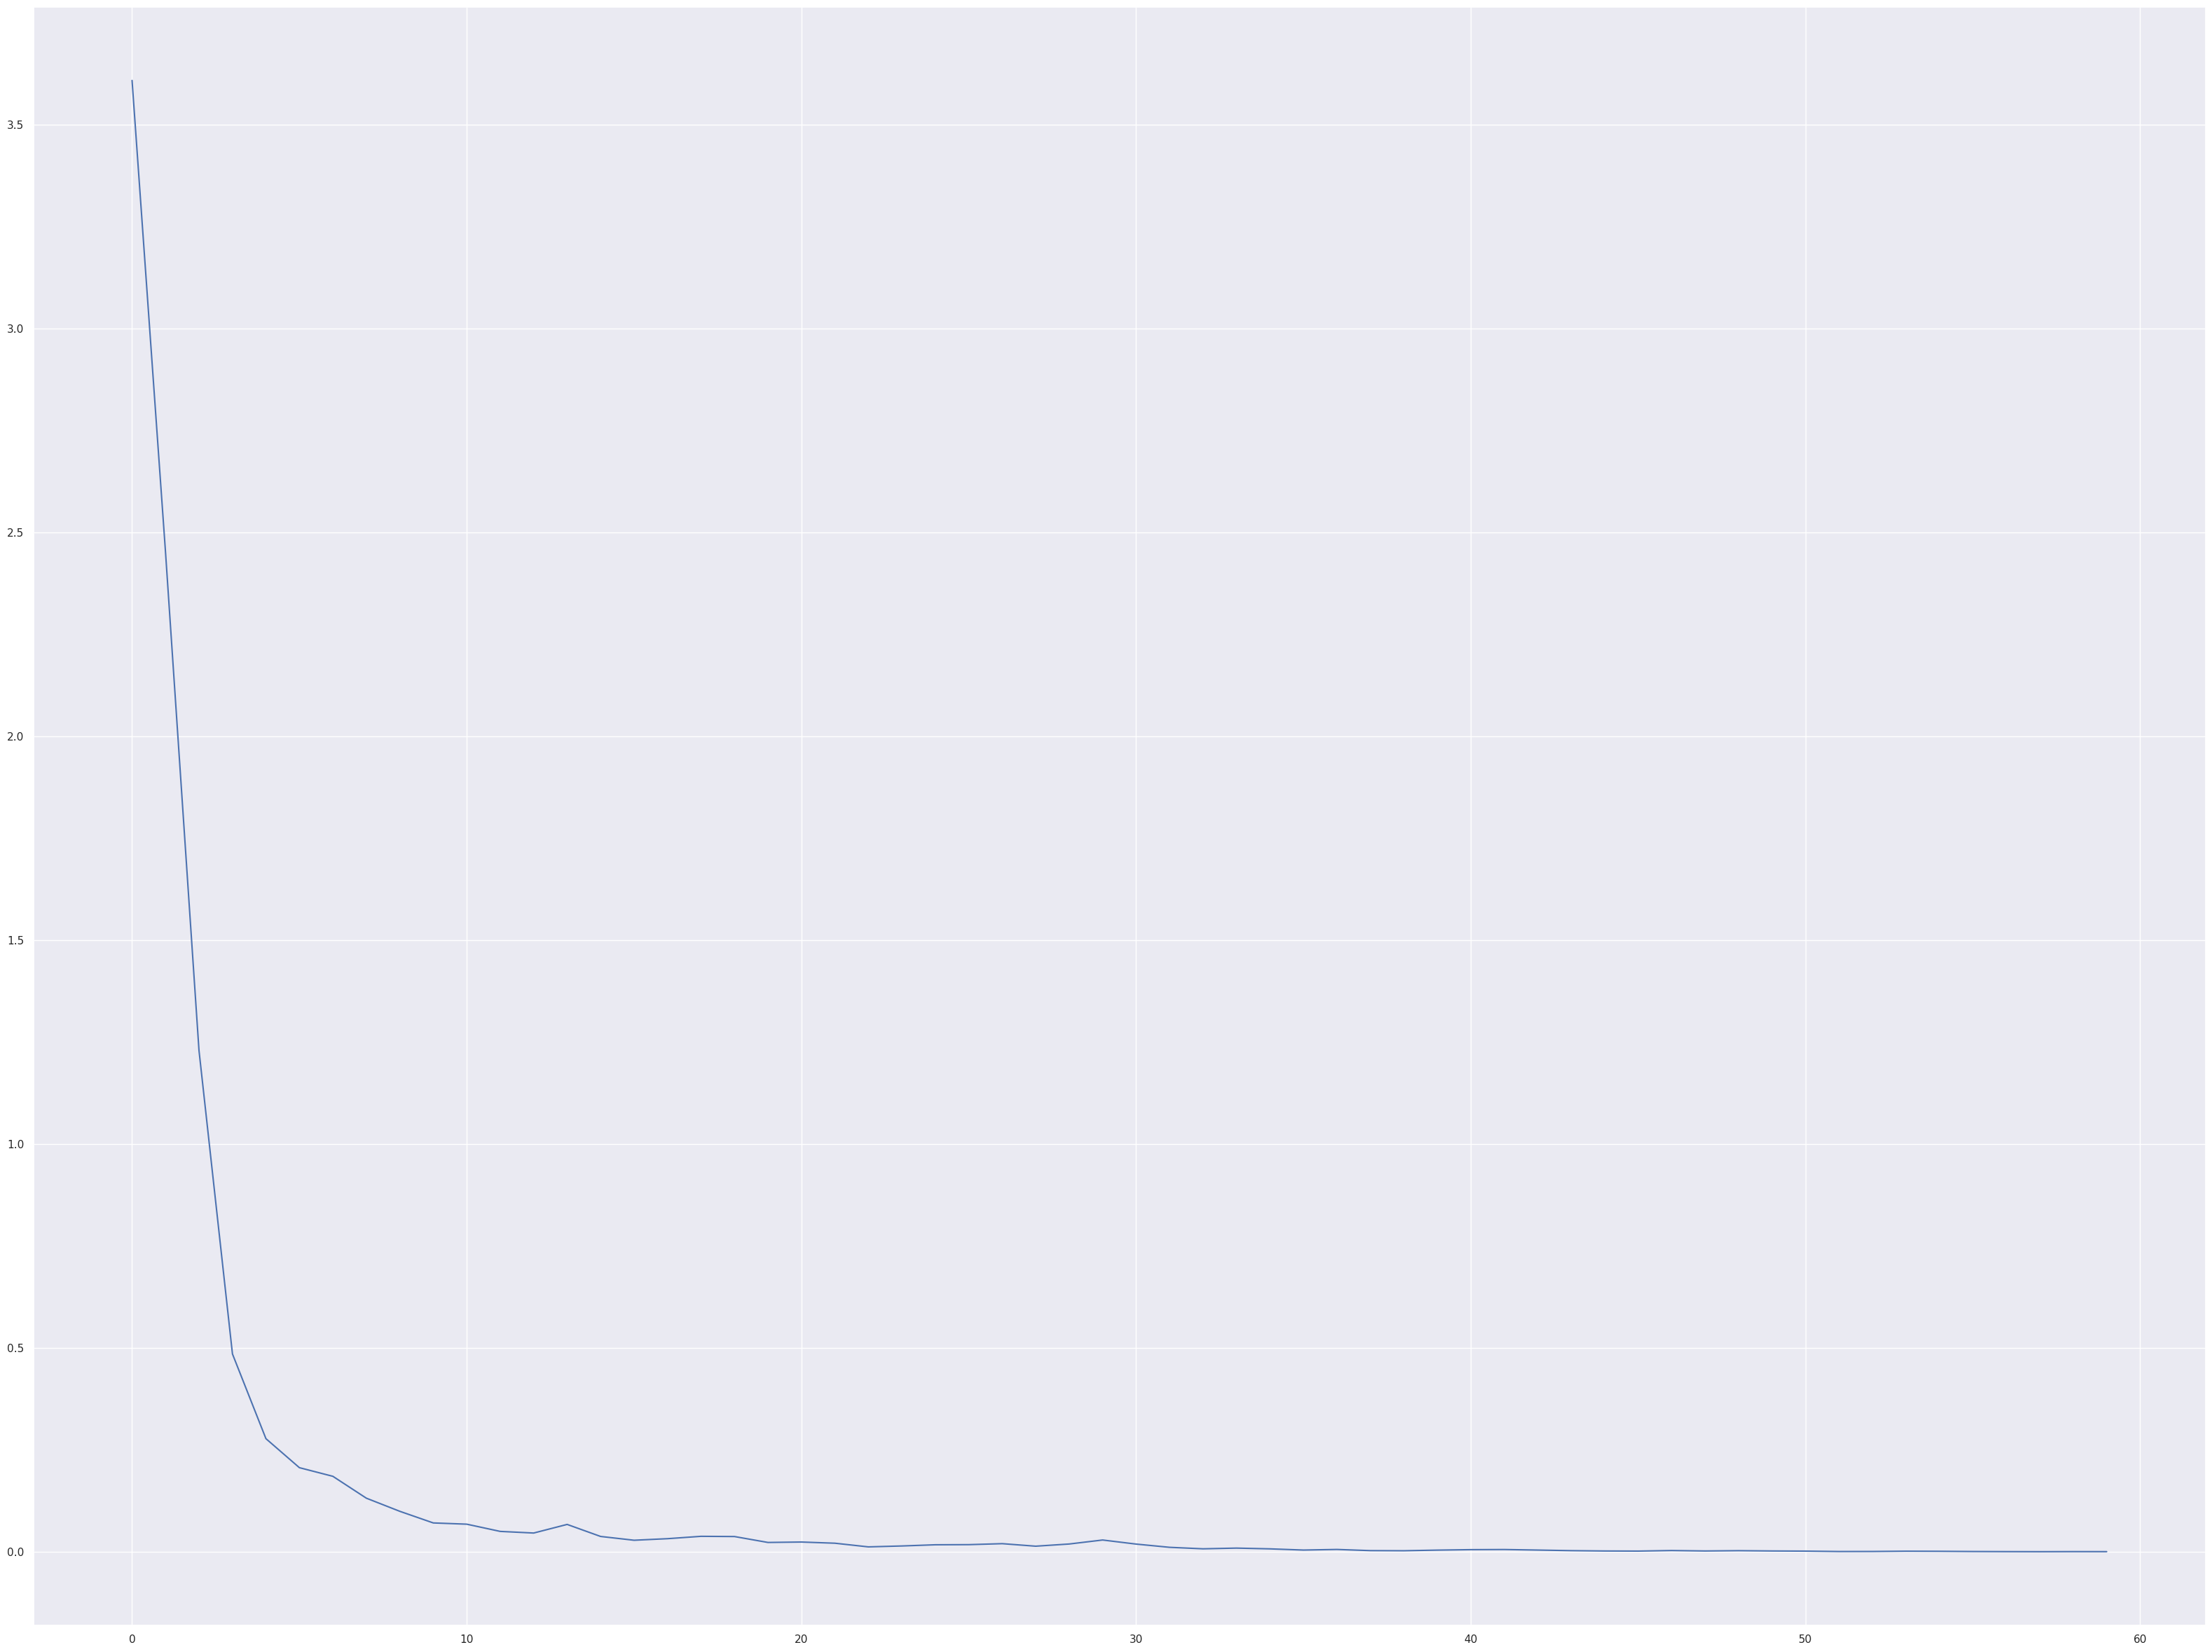

In [1180]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

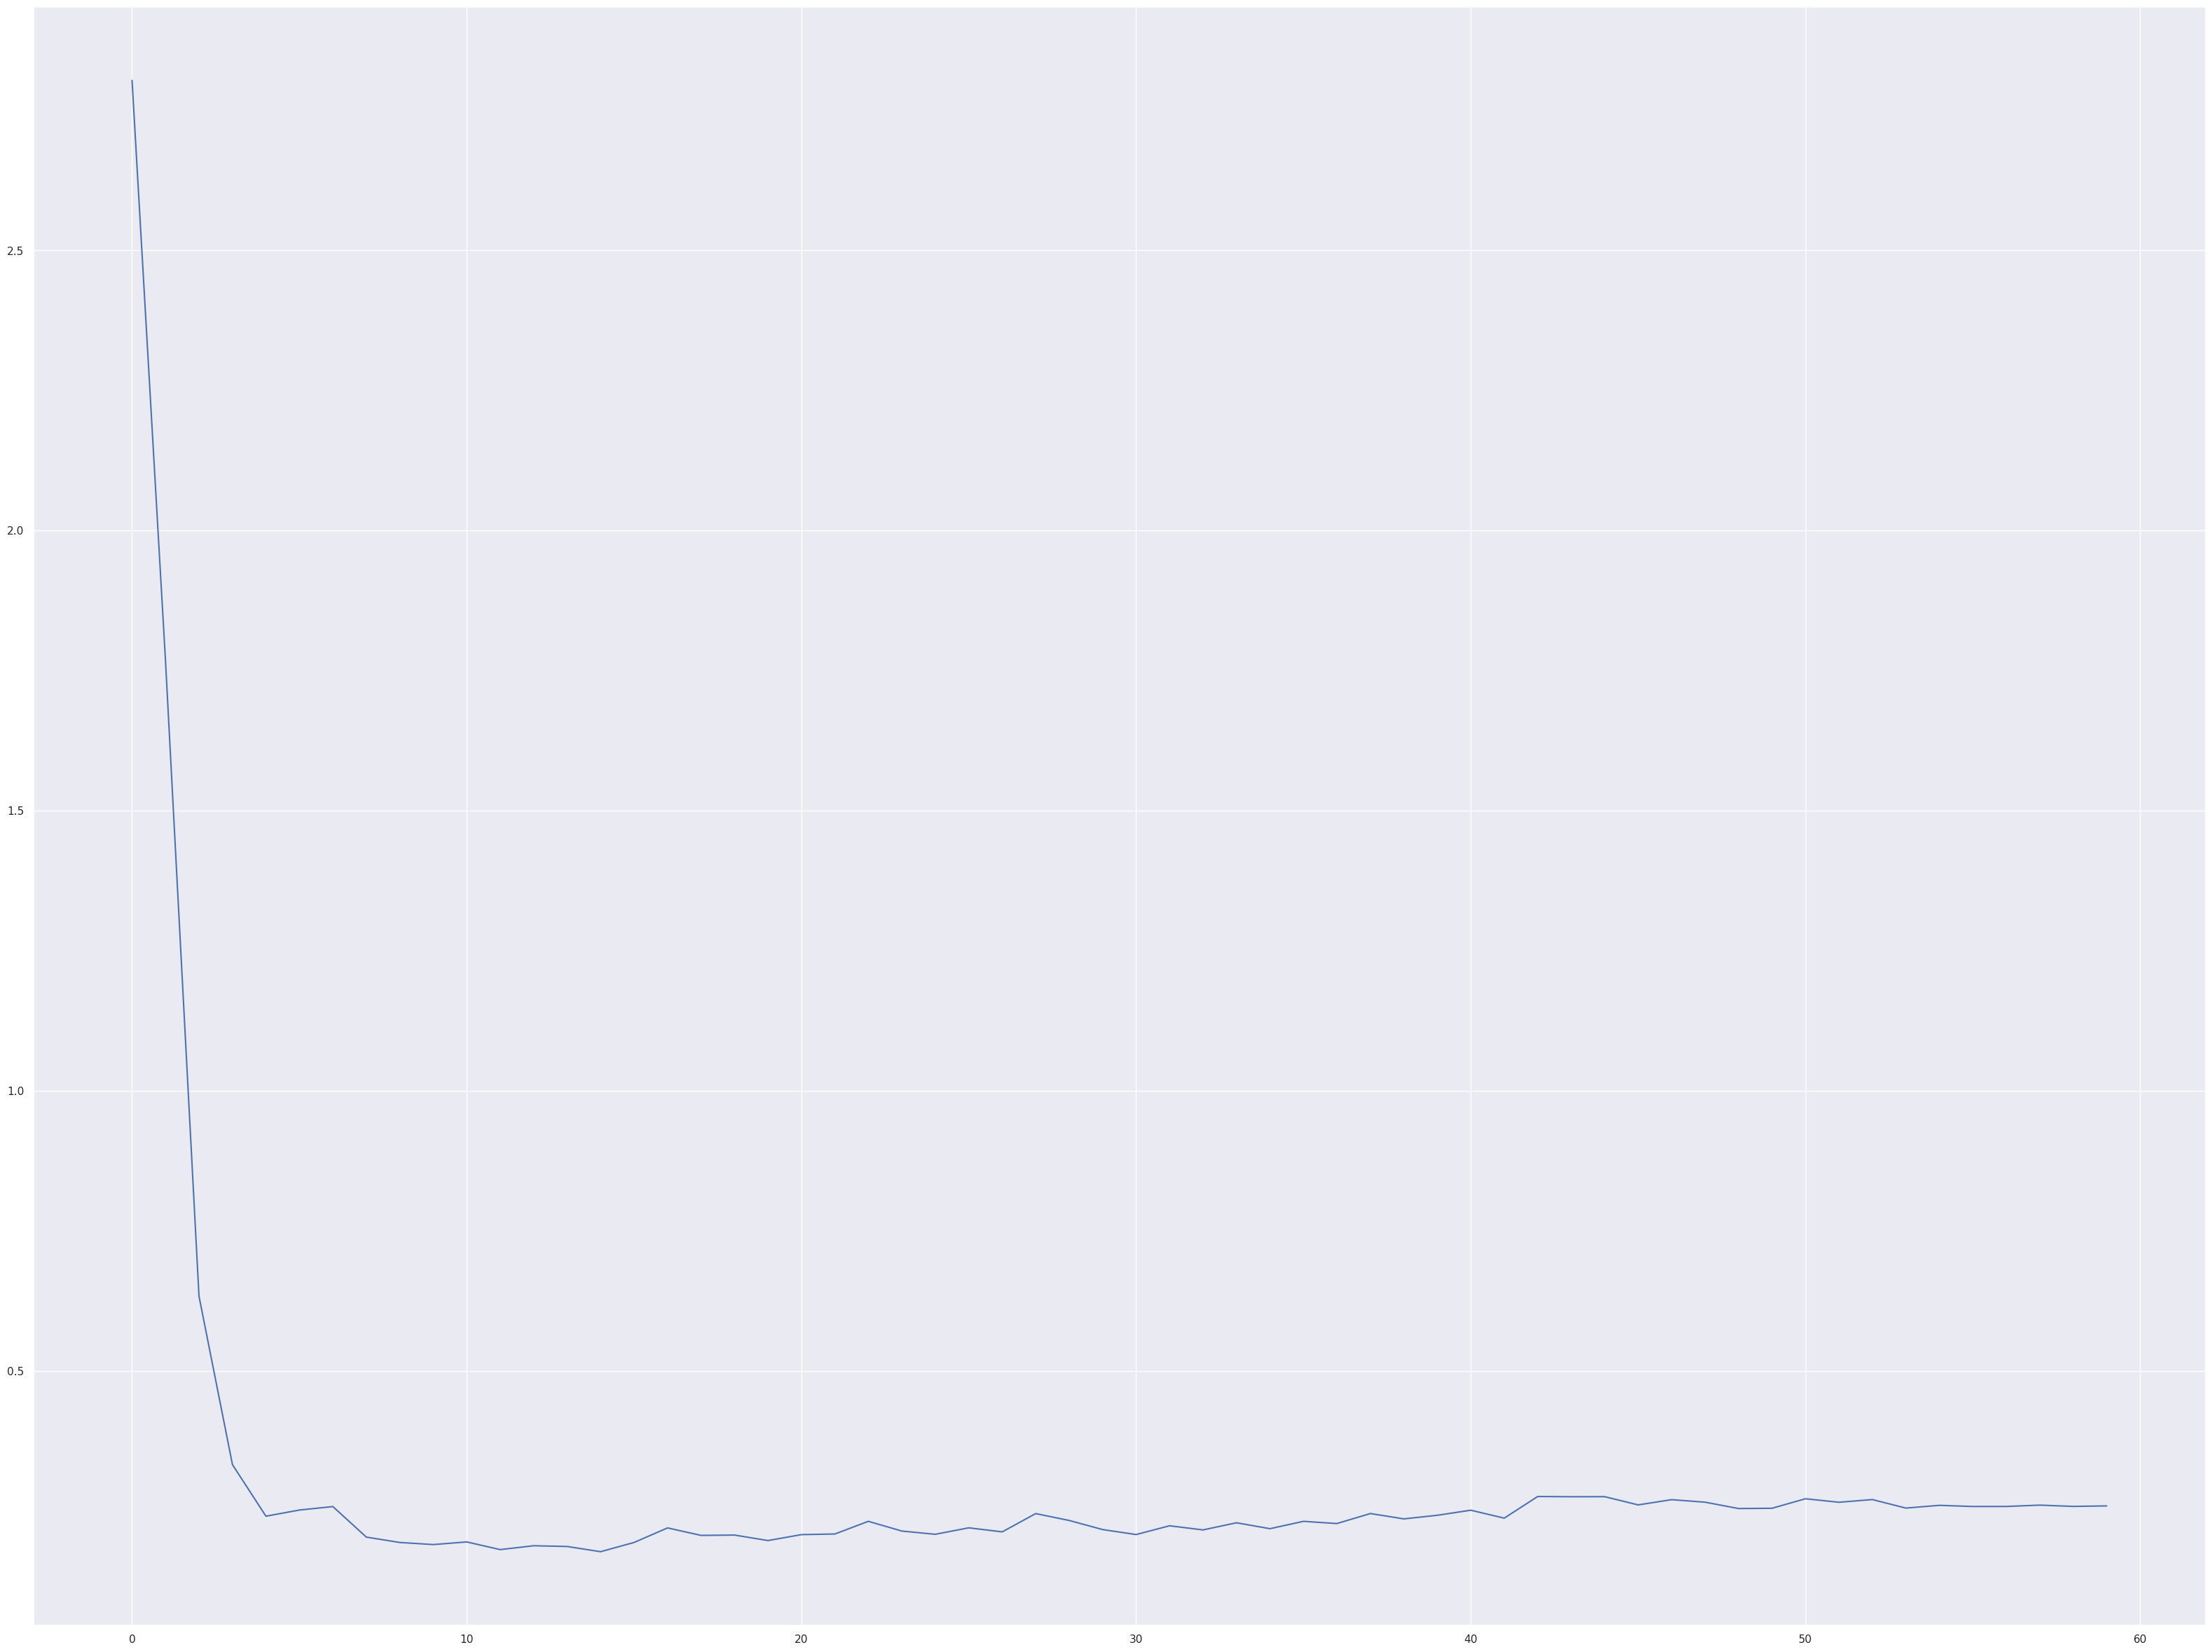

In [1181]:
plt.plot(valid_losses)

In [1182]:
# torch.save(model.state_dict(), 'models/xlmlarge_149intent_133slot_pytorch_weights_88.pt')

### Load Saved Model

In [64]:
# load weights of best model
# path = 'models/xlmlarge_174intent(with_oos_800)_133slot_0723.pt'
# path = 'models/xlmlarge_175intent(800oos_2offensive)_133slot_0730.pt'
# path = f'models/xlmlarge_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.pt'

# path = f'models/nlu_xlmlarge_14030405.pt'

# path = f'models/3Folds/nlu_xlmlarge_14030406_Fold2.pt'
path = f'models/10Folds/nlu_xlmlarge_14030410_Fold{FOLD}.pt'


print(path)
model.load_state_dict(torch.load(path))

models/10Folds/nlu_xlmlarge_14030410_Fold2.pt


<All keys matched successfully>

# 3-Fold Training for Refining Offensive Part

In [19]:
from sklearn.model_selection import KFold, GroupKFold, train_test_split

FOLD = 2  # 9     #done 0 1 2 3 4 5 7 8
NUMBER_FOLDS = 3
DATE = '14030406'


gkf = GroupKFold(n_splits=NUMBER_FOLDS)#, shuffle=True, random_state=42)   # is not randomized at all random_state=None
# kf = KFold(n_splits=10, shuffle=True, random_state=43)  # kf.get_n_splits()
# result = next(gkf.split(df, df.intent, df.pattern_id ))
# print(result)
# pd.merge(df.iloc[result[0]],df.iloc[result[1]],on=['pattern_id'])
print(gkf.get_n_splits(df, df.intent, df.pattern_id ))

train_valid_index = list(gkf.split(df, df.intent, df.pattern_id ))[FOLD][0]
from sklearn.model_selection import train_test_split
train_index, valid_index = train_test_split(train_valid_index, test_size=0.10, random_state=42, shuffle = True)

test_index = list(gkf.split(df, df.intent, df.pattern_id ))[FOLD][1]
print('train+valid length:',len(train_valid_index),train_valid_index)
print('test length:',len(test_index),test_index)

3
train+valid length: 40899 [    0     3     4 ... 61344 61345 61347]
test length: 20449 [    1     2     5 ... 61341 61343 61346]


In [20]:
train_df = df.iloc[train_index]
valid_df = df.iloc[valid_index]
test_df = df.iloc[test_index]

train_text = train_df["text"]
train_intent_label = train_df["intent"]
train_slot_label = train_df["slots"]

valid_text = valid_df["text"]
valid_intent_label = valid_df["intent"]
valid_slot_label = valid_df["slots"]

test_text = test_df["text"]
test_intent_label = test_df["intent"]
test_slot_label = test_df["slots"]

train_text = train_text.values
train_intent_label = train_intent_label.values
train_slot_label = train_slot_label.values

valid_text = valid_text.values
valid_intent_label = valid_intent_label.values
valid_slot_label = valid_slot_label.values

test_text = test_text.values
test_intent_label = test_intent_label.values
test_slot_label = test_slot_label.values

import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(), slot_label_dataset[i].split()):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

train_df = process_dataset(train_text, train_intent_label, train_slot_label)
valid_df = process_dataset(valid_text, valid_intent_label, valid_slot_label)
test_df = process_dataset(test_text, test_intent_label, test_slot_label)

# Check that if number of tokens in sentences is equal to its slots number or not
for i in range(len(train_df)):
    slots = train_df['slot_labels'][i]
    tokens = train_df['slot_tokens'][i]
    assert len(slots) == len(tokens), f"sentence length doesn't match to slots length i = {i}, tokens={tokens} slots = {slots}"

In [21]:
# Load the BERT tokenizer
from transformers import AutoTokenizer
model_name = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

intent_id2label = dict([(i,v) for i,v in enumerate(sorted(df.intent.unique()))])
intent_label2id = dict([(v,k) for k,v in intent_id2label.items()])

slot_label = []
[slot_label.extend(i.split()) for i in train_slot_label]
[slot_label.extend(i.split()) for i in valid_slot_label]
[slot_label.extend(i.split()) for i in test_slot_label]
slot_label2id = dict([(y,x) for x,y in enumerate(sorted(set(slot_label)))])  
slot_id2label = dict([(y,x) for x,y in slot_label2id.items()])

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
MAX_SEQ_LEN = 64

def tokenize_and_align_labels(examples, slot_label2id=slot_label2id, intent_label2id=intent_label2id):
    tokenized_inputs = tokenizer(examples["slot_tokens"],truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                               is_split_into_words=True, return_token_type_ids=False)
                                
    slot_labels = []
    intent_label = []
    for i, label in enumerate(examples["slot_labels"]):
        word_ids = tokenized_inputs.word_ids()
        previous_word_id = None
        label_ids = []
        for word_id in word_ids:  # Set the special tokens to 0.
            if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
                label_ids.append(-100)
            elif word_id != previous_word_id: # We set the label for the first token of each word.
                label_ids.append(slot_label2id[examples["slot_labels"][word_id]])
            else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
                # label_ids.append(label[word_idx] if label_all_tokens else -100)
                label_ids.append(-100)
            previous_word_id = word_id

        slot_labels.append(label_ids)
        intent_label.append(intent_label2id[examples["intent_label"]])
    tokenized_inputs["slot_labels"] = slot_labels[0]
    tokenized_inputs["intent_label"] = intent_label[0]
    # x, y_slot, y_intent
    return tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], tokenized_inputs['slot_labels'], tokenized_inputs['intent_label']

from tqdm import tqdm

tokenized_train = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(train_df))):
    tokenized_train['input_ids'].append(tokenize_and_align_labels(train_df.iloc[i])[0])
    tokenized_train['attention_mask'].append(tokenize_and_align_labels(train_df.iloc[i])[1])
    tokenized_train['slot_labels'].append(tokenize_and_align_labels(train_df.iloc[i])[2])
    tokenized_train['intent_label'].append(tokenize_and_align_labels(train_df.iloc[i])[3])

tokenized_valid = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(valid_df))):
    tokenized_valid['input_ids'].append(tokenize_and_align_labels(valid_df.iloc[i])[0])
    tokenized_valid['attention_mask'].append(tokenize_and_align_labels(valid_df.iloc[i])[1])
    tokenized_valid['slot_labels'].append(tokenize_and_align_labels(valid_df.iloc[i])[2])
    tokenized_valid['intent_label'].append(tokenize_and_align_labels(valid_df.iloc[i])[3])

tokenized_test = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(test_df))):
    tokenized_test['input_ids'].append(tokenize_and_align_labels(test_df.iloc[i])[0])
    tokenized_test['attention_mask'].append(tokenize_and_align_labels(test_df.iloc[i])[1])
    tokenized_test['slot_labels'].append(tokenize_and_align_labels(test_df.iloc[i])[2])
    tokenized_test['intent_label'].append(tokenize_and_align_labels(test_df.iloc[i])[3])

# check length for correct alligning
for i in range(len(tokenized_train['input_ids'])):
    if len(tokenized_train['input_ids'][i]) == len(tokenized_train['slot_labels'][i]):
        continue
    else:
        print(i, tokenized_train['input_ids'][i], tokenized_train['slot_labels'][i])

# for train set
train_input_ids = torch.tensor(tokenized_train['input_ids'])
train_attention_mask = torch.tensor(tokenized_train['attention_mask'])
train_label_intent = torch.tensor(tokenized_train['intent_label'])
train_label_slot = torch.tensor(tokenized_train['slot_labels'])

# for validation set
valid_input_ids = torch.tensor(tokenized_valid['input_ids'])
valid_attention_mask = torch.tensor(tokenized_valid['attention_mask'])
valid_label_intent = torch.tensor(tokenized_valid['intent_label'])
valid_label_slot = torch.tensor(tokenized_valid['slot_labels'])

# # for test set
test_input_ids = torch.tensor(tokenized_test['input_ids'])
test_attention_mask = torch.tensor(tokenized_test['attention_mask'])
test_label_intent = torch.tensor(tokenized_test['intent_label'])
test_label_slot = torch.tensor(tokenized_test['slot_labels'])

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
BATCH_SIZE = 128

# wrap tensors
train_data = TensorDataset(train_input_ids, train_attention_mask, train_label_intent, train_label_slot)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# wrap tensors
valid_data = TensorDataset(valid_input_ids, valid_attention_mask, valid_label_intent, valid_label_slot)
# sampler for sampling the data during training
valid_sampler = SequentialSampler(valid_data)
# dataLoader for validation set
valid_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size=BATCH_SIZE)

# wrap tensors
test_data = TensorDataset(test_input_ids, test_attention_mask, test_label_intent, test_label_slot)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20449/20449 [00:39<00:00, 518.02it/s]


In [23]:
# import BERT-base pretrained model
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig

config = AutoConfig.from_pretrained("xlm-roberta-large")  # config.update({'output_hidden_states':True})
bert = AutoModel.from_pretrained("xlm-roberta-large",output_hidden_states=True) 

import torch
import torch.nn as nn
from torch.cuda import amp
from torch.cuda.amp import autocast

class JointIntentAndSlotFillingModel(nn.Module):

    def __init__(self, bert, config, intent_labels_num, slot_labels_num):
        super(JointIntentAndSlotFillingModel,self).__init__()
        self.bert = bert
        self.fc1 = nn.Linear(config.hidden_size,config.hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.intent_classifier = nn.Linear(config.hidden_size, intent_labels_num)
        self.fc2 = nn.Linear(config.hidden_size,config.hidden_size)
        self.slot_classifier = nn.Linear(config.hidden_size, slot_labels_num)
        # self.softmax_intent = nn.LogSoftmax(dim=1)
        # self.softmax_slot = nn.LogSoftmax(dim=2)


    # @amp.autocast()
    def forward(self, input_ids, attention_mask):
        # two outputs from BERT
        outputs = self.bert(input_ids, attention_mask)
        
        cls_token = outputs[1]   # cls_token is pooled_output     # torch.Size([8, 1024])
        dense_for_intent = self.fc1(cls_token)
        intent_logits = self.intent_classifier(self.dropout(dense_for_intent))      # torch.Size([8, 60])
 
        last_hidden_state = outputs[0]                            # torch.Size([8, 64, 1024])     
        dense_for_slot = self.fc2(last_hidden_state)
        slot_logits = self.slot_classifier(self.dropout(dense_for_slot))  # torch.Size([8, 64, 109])
        
        return intent_logits, slot_logits
        # intent_classes = self.softmax_intent(intent_logits)                         # torch.Size([8, 60])
        # slot_classes = self.softmax_slot(slot_logits)                             # torch.Size([8, 109, 64])
        # return intent_classes, slot_classes

# pass the pre-trained BERT to our define architecture
model = JointIntentAndSlotFillingModel(bert, config,
                                       intent_labels_num=len(intent_label2id),
                                       slot_labels_num=len(slot_label2id))

# push the model to GPU
model = model.to('cuda')

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import warnings

# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
LEARNING_RATE = 5e-5  # 5e-3  5e-5better  5e-6
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

# scheduler
from transformers import get_linear_schedule_with_warmup
EPOCHS = 60
total_step =  len(train_dataloader) * EPOCHS
num_warmup_steps = 0.1 * len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_step)

#compute the class weights
import numpy as np 
from sklearn.utils.class_weight import compute_class_weight

class_wts_intents = compute_class_weight(class_weight ='balanced', classes = np.unique(train_intent_label), y=train_intent_label)
# print(class_wts)

# convert class weights to tensor
weights_intents = torch.tensor(class_wts_intents,dtype=torch.float)
weights_intents = weights_intents.to(device)

all_slots = []
for i in train_slot_label: all_slots.extend(i.split())

class_wts_slots = compute_class_weight(class_weight ='balanced', classes = np.unique(all_slots), y=all_slots)
weights_slots= torch.tensor(class_wts_slots,dtype=torch.float)
weights_slots = weights_slots.to(device)

# loss function
# loss_fn_intent = nn.NLLLoss() #(weight=weights) 
loss_fn_intent  = nn.CrossEntropyLoss(weight=weights_intents)
# loss_fn_slot = nn.CrossEntropyLoss()
def loss_fn_slot(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss() #weight=weights_slots)
    active_loss = mask.view(-1) == 1
    # print('output.shape:',output.shape)
    active_logits = output.view(-1, num_labels)  # torch.Size([batch_size, 109])
    # print('target.shape:', target.shape, 'active_labels:',active_loss.shape, 'active_logits:',active_logits.shape )
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target))
    loss = lfn(active_logits, active_labels)
    return loss

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# function to train the model
# from tqdm.notebook import tqdm

def train():
    model.train()
    
    total_preds_intent= []
    total_preds_slot = []
    batch_loss = []

    for batch in train_dataloader:  #enumerate(train_dataloader)

        batch = [r.to(device) for r in batch]
        sent_id, mask, intent_label, slot_labels = batch

        model.zero_grad()  
        
        # preds = model(sent_id, mask)
        intent_preds, slot_preds = model(sent_id, mask)
        # loss = cross_entropy(preds, labels)
        loss_intent = loss_fn_intent(intent_preds, intent_label)
        loss_slot = loss_fn_slot(slot_preds, slot_labels, mask, len(slot_label2id))
        # loss_slot = loss_fn_slot(slot_preds, slot_labels)
        loss = (loss_slot + loss_intent)/2
        # print('loss:', loss_intent, loss_slot, loss)
        
        batch_loss.append(loss.item())
        loss.backward()
        
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        # preds=preds.detach().cpu().numpy()
        # total_preds.append(preds)
        intent_preds=intent_preds.detach().cpu().numpy()
        total_preds_intent.append(intent_preds)
        slot_preds=slot_preds.detach().cpu().numpy()
        total_preds_slot.append(slot_preds)
        
    epoch_loss_train = np.mean(batch_loss)
    # total_preds  = np.concatenate(total_preds, axis=0)
    total_preds_intent  = np.concatenate(total_preds_intent, axis=0)
    total_preds_slot  = np.concatenate(total_preds_slot, axis=0)
    return epoch_loss_train, total_preds_intent, total_preds_slot

def evaluate(valid_dataloader=valid_dataloader):
    # print("\nEvaluating...") 
    model.eval()

    batch_loss = 0
    # total_preds = []
    total_preds_intent= []
    total_preds_slot = []
    
    for step,batch in enumerate(valid_dataloader): ##enumerate(loop)
        # if step % 50 == 0 and not step == 0:
        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valid_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, intent_label, slot_labels = batch

        # deactivate autograd
        with torch.no_grad():
            # preds = model(sent_id, mask)
            intent_preds, slot_preds = model(sent_id, mask)
            # loss = cross_entropy(preds, labels)
            loss_intent = loss_fn_intent(intent_preds, intent_label)
            loss_slot = loss_fn_slot(slot_preds, slot_labels, mask, len(slot_label2id)) 
            # loss_slot = loss_fn_slot(slot_preds, slot_labels)
            loss = (loss_slot + loss_intent)/2
            
            batch_loss = batch_loss + loss.item()
            # preds = preds.detach().cpu().numpy()
            # total_preds.append(preds)
            intent_preds=intent_preds.detach().cpu().numpy()
            total_preds_intent.append(intent_preds)
            slot_preds=slot_preds.detach().cpu().numpy()
            total_preds_slot.append(slot_preds)
            
    epoch_loss_valid = batch_loss / len(valid_dataloader) 
    # total_preds  = np.concatenate(total_preds, axis=0)
    total_preds_intent  = np.concatenate(total_preds_intent, axis=0)
    total_preds_slot  = np.concatenate(total_preds_slot, axis=0)
    
    return epoch_loss_valid, total_preds_intent, total_preds_slot

def delete_100(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != -100:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new

# functions for phrasal evaluation
slotname = list(i[2:] for i in list(slot_id2label.values()))

def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

pair_bi = []
for i in slotname[74:]:
    pair_bi.append(find_indices(slotname,i))
    
pair_bi_dict = dict([(i[0],i[1]) for i in pair_bi if len(i)==2])   
# len(pair_bi)
# pair_bi
####################################################################
# my_list = [i.item() for i in valid_label_slot[0] if i != -100 ]
def i_to_200(alist):
    alist_new = alist.copy()
    for i,token in enumerate(alist_new):
        if token in pair_bi_dict.keys():  #range(74):
    # for i in pair_bi:
    #     if len(i) == 2:
    #         if i[0] in alist_new:
                j = 1
                k = token
                if len(alist_new) == (i+j):
                    continue
                while alist_new[i+j] == pair_bi_dict[token]:    #alist_new.index(i[0]) == i[1]   or alist_new[i+j]
                    alist_new[i+j] = -200    #alist_new.index(i[0])
                    k += 200 
                    j += 1
                    if len(alist_new) == (i+j):
                        break
                alist_new[i] = k
    return alist_new #, alist     

# i_to_200(my_list)   
####################################################################
def delete_200(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != -200:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new
####################################################################
def delete_134(first_list, second_list):
    first_list_new = []
    second_list_new = []
    for value_first, value_second in zip(first_list, second_list):
        if value_first != 134:
            first_list_new.append(value_first)
            second_list_new.append(value_second)
    return first_list_new, second_list_new
#########################################################################
# functions for token evaluation

def fscore_micro_without_o(y_true_slot , y_pred_slot):
    classification_report_without_o = pd.DataFrame(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True)).transpose()[:-4]
    return sum(classification_report_without_o['f1-score']*classification_report_without_o['support']) / sum(classification_report_without_o['support'])

In [ ]:
# %%capture captured_output
# All intents with oos (800 sample)

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

# slot token level
f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []
f1_micro_without_o = []


# slot phrase level
f1_macro_phrasal_slot = []
f1_micro_phrasal_slot = []
precision_micro_phrasal_slot = []
recall_micro_phrasal_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    
    # token-level
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    f1_micro_without_o.append(fscore_micro_without_o(y_true_slot, y_pred_slot))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)) 
    
    # phrase-level micro:
    # recall_strict
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
    y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
    # precision_strict
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
    y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
    p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
    r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
    precision_micro_phrasal_slot.append(r)
    recall_micro_phrasal_slot.append(p)
    f1_micro_phrasal_slot.append((2*p*r)/(p+r))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                      'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,#'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro Token':f1_macro_slot,  'Slot F1 Micro Token':f1_micro_slot, 'Slot F1 Micro Without O Token':f1_micro_without_o,
                      #'Slot F1 Macro Phrasal':f1_macro_phrasal_slot,
                      'Slot F1 Micro Phrasal':f1_micro_phrasal_slot, 'Slot Precision Micro Phrasal':precision_micro_phrasal_slot, 'Slot Recall Micro Phrasal':recall_micro_phrasal_slot})
    df_results.index += 1; df_results.index.name='epoch'
    
    # df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
    #                    'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
    #                   'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    # df_results.index += 1; df_results.index.name = 'epoch'
    
    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        # torch.save(model.state_dict(), f'models/xlmlarge_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.pt')
        # torch.save(model.state_dict(), f'models/xlmlarge_177intent(2offensiveAs1)_145slot_FOLD.pt')
        torch.save(model.state_dict(), f'models/3Folds/nlu_xlmlarge_14030406_Fold{FOLD}.pt')

# %%writefile log.txt
# print(captured_output.stdout)

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Slot F1 Macro Token,Slot F1 Micro Token,Slot F1 Micro Without O Token,Slot F1 Micro Phrasal,Slot Precision Micro Phrasal,Slot Recall Micro Phrasal
epoch,,,,,,,,,,
1,3.539658,2.819028,0.026961,0.055012,0.0073,0.889787,0.0,0.907613,0.926168,0.889787


Epochs:   2%|██                                                                                                                          | 1/60 [04:36<4:31:26, 276.03s/it]

# Inference

In [82]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

## evaluate on valid dataset - 14030409

In [118]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(valid_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = valid_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = valid_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'fscore_micro_without_o:',fscore_micro_without_o(y_true_slot, y_pred_slot))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:',(2*p*r)/(p+r))
print( 'precision_micro_phrasal_slot:',p)
print( 'recall_micro_phrasal_slot:',r)

Intent:
f1_score_macro: 0.9220386714812183
f1_score_micro: 0.9590070227012902
accuracy_score: 0.9590070227012902
f1_weighted_average: 0.9597786704240436
precision_macro: 0.9149759114508003
recall_macro: 0.9365935904227565
Slot token-level:
f1_score_macro: 0.9243146888906856
f1_score_micro: 0.9959894481738049
fscore_micro_without_o: 0.9746533988373558
accuracy_score: 0.9959894481738049
Slot phrase-level:
f1_micro_phrasal_slot: 0.9961604571734713
precision_micro_phrasal_slot: 0.996293898327789
recall_micro_phrasal_slot: 0.9960270517599268


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## evaluate on test dataset - 14030409

In [105]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro')*100, 2))
print( 'f1_score_micro:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro')*100, 2))
print( 'accuracy_score:', round(accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent)*100, 2))
print( 'f1_weighted_average:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted')*100, 2))
print( 'precision_macro:', round(precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))
print( 'recall_macro:', round(recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:', round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro')*100, 2))
print( 'f1_score_micro:', round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro')*100, 2))
print( 'fscore_micro_without_o:', round(fscore_micro_without_o(y_true_slot, y_pred_slot)*100, 2))
print( 'accuracy_score:', round(accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)*100, 2))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:', round((2*p*r)/(p+r)*100, 2))
print( 'precision_micro_phrasal_slot:', round(p*100, 2))
print( 'recall_micro_phrasal_slot:', round(r*100, 2))

Intent:
f1_score_macro: 92.33
f1_score_micro: 96.39
accuracy_score: 96.39
f1_weighted_average: 96.4
precision_macro: 91.69
recall_macro: 93.72
Slot token-level:
f1_score_macro: 85.88
f1_score_micro: 99.56
fscore_micro_without_o: 97.01
accuracy_score: 99.56
Slot phrase-level:
f1_micro_phrasal_slot: 99.58
precision_micro_phrasal_slot: 99.59
recall_micro_phrasal_slot: 99.58


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

## evaluate on validation dataset - 14030405


In [83]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(valid_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = valid_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = valid_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
# print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
print('Slot:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))

Intent:
f1_score_macro: 0.8659351023997052
f1_score_micro: 0.8993396682235465
accuracy_score: 0.8993396682235465
f1_weighted_average: 0.90885895989817
precision_macro: 0.8409840273369025
recall_macro: 0.9211264226300733
Slot:
f1_score_macro: 0.9059747535685027
f1_score_micro: 0.992455851982973
accuracy_score: 0.992455851982973
f1_weighted_average: 0.9923833538176228
precision_macro: 0.9033898143203564
recall_macro: 0.9213638605140163


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(valid_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = valid_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = valid_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'fscore_micro_without_o:',fscore_micro_without_o(y_true_slot, y_pred_slot))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:',(2*p*r)/(p+r))
print( 'precision_micro_phrasal_slot:',p)
print( 'recall_micro_phrasal_slot:',r)

Intent:
f1_score_macro: 0.8659351023997052
f1_score_micro: 0.8993396682235465
accuracy_score: 0.8993396682235465
f1_weighted_average: 0.90885895989817
precision_macro: 0.8409840273369025
recall_macro: 0.9211264226300733
Slot token-level:
f1_score_macro: 0.9059747535685027
f1_score_micro: 0.992455851982973


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

fscore_micro_without_o: 0.9540139194306462
accuracy_score: 0.992455851982973
Slot phrase-level:
f1_micro_phrasal_slot: 0.9924956196899071
precision_micro_phrasal_slot: 0.9925503074651209
recall_micro_phrasal_slot: 0.9924409379407616


In [704]:
len(test_dataloader)*128

3712

## evaluate on test dataset - 14030405

In [109]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:',round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro')*100, 2))
print( 'f1_score_micro:',round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro')*100, 2))
print( 'accuracy_score:',round(accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent)*100, 2))
print( 'f1_weighted_average:',round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted')*100, 2))
print( 'precision_macro:', round(precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))
print( 'recall_macro:', round(recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
# print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
print('Slot:')
print( 'f1_score_macro:',round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro')*100, 2))
print( 'f1_score_micro:',round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro')*100, 2))
print( 'accuracy_score:',round(accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)*100, 2))
print( 'f1_weighted_average:',round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='weighted')*100, 2))
print( 'precision_macro:', round(precision_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro')*100, 2))
print( 'recall_macro:', round(recall_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro')*100, 2))

Intent:
f1_score_macro: 85.98
f1_score_micro: 89.46
accuracy_score: 89.46
f1_weighted_average: 90.69
precision_macro: 83.28
recall_macro: 92.16
Slot:
f1_score_macro: 87.69
f1_score_micro: 99.32
accuracy_score: 99.32
f1_weighted_average: 99.33
precision_macro: 87.3
recall_macro: 89.28


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro')*100, 2))
print( 'f1_score_micro:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro')*100, 2))
print( 'accuracy_score:', round(accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent)*100, 2))
print( 'f1_weighted_average:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted')*100, 2))
print( 'precision_macro:', round(precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))
print( 'recall_macro:', round(recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:', round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro')*100, 2))
print( 'f1_score_micro:', round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro')*100, 2))
print( 'fscore_micro_without_o:', round(fscore_micro_without_o(y_true_slot, y_pred_slot)*100, 2))
print( 'accuracy_score:', round(accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)*100, 2))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:', round((2*p*r)/(p+r)*100, 2))
print( 'precision_micro_phrasal_slot:', round(p*100, 2))
print( 'recall_micro_phrasal_slot:', round(r*100, 2))

Intent:
f1_score_macro: 85.98
f1_score_micro: 89.46
accuracy_score: 89.46
f1_weighted_average: 90.69
precision_macro: 83.28
recall_macro: 92.16
Slot token-level:
f1_score_macro: 87.69
f1_score_micro: 99.32


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

fscore_micro_without_o: 95.88
accuracy_score: 99.32
Slot phrase-level:
f1_micro_phrasal_slot: 99.33
precision_micro_phrasal_slot: 99.33
recall_micro_phrasal_slot: 99.34


## 10 Folds Evaluation - 14030410

In [65]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report

valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro')*100, 2))
print( 'f1_score_micro:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro')*100, 2))
print( 'accuracy_score:', round(accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent)*100, 2))
print( 'f1_weighted_average:', round(f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted')*100, 2))
print( 'precision_macro:', round(precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))
print( 'recall_macro:', round(recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro')*100, 2))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())

# token-level
print('Slot token-level:')
print( 'f1_score_macro:', round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro')*100, 2))
print( 'f1_score_micro:', round(f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro')*100, 2))
print( 'fscore_micro_without_o:', round(fscore_micro_without_o(y_true_slot, y_pred_slot)*100, 2))
print( 'accuracy_score:', round(accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot)*100, 2))


# phrase-level micro:
# recall_strict
y_true_slot_p_recall, y_pred_slot_p_recall = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  
y_true_slot_p_recall, y_pred_slot_p_recall = delete_134(i_to_200(y_true_slot_p_recall), i_to_200(y_pred_slot_p_recall))  
# precision_strict
y_pred_slot_p_precision, y_true_slot_p_precision = delete_200(i_to_200(y_pred_slot), i_to_200(y_true_slot))  
y_pred_slot_p_precision, y_true_slot_p_precision = delete_134(i_to_200(y_pred_slot_p_precision), i_to_200(y_true_slot_p_precision))
p = precision_score(y_true=y_true_slot_p_precision, y_pred=y_pred_slot_p_precision, average = 'micro')
r = recall_score(y_true=y_true_slot_p_recall, y_pred=y_pred_slot_p_recall, average = 'micro')
print('Slot phrase-level:')
print( 'f1_micro_phrasal_slot:', round((2*p*r)/(p+r)*100, 2))
print( 'precision_micro_phrasal_slot:', round(p*100, 2))
print( 'recall_micro_phrasal_slot:', round(r*100, 2))

Intent:
f1_score_macro: 93.47
f1_score_micro: 96.25
accuracy_score: 96.25
f1_weighted_average: 96.3
precision_macro: 92.69
recall_macro: 94.75
Slot token-level:
f1_score_macro: 90.16
f1_score_micro: 99.56
fscore_micro_without_o: 97.15
accuracy_score: 99.56
Slot phrase-level:
f1_micro_phrasal_slot: 99.59
precision_micro_phrasal_slot: 99.59
recall_micro_phrasal_slot: 99.59


/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

# Classification reports

## intent confusion matrix

In [1186]:
# sorted([intent_label2id[i] for i in test_df['intent_label'].unique()])

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true=y_true_intent , y_pred=y_pred_intent 
                            # ,labels = range(len(intent_id2label)) 
                            ,target_names =[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])],
                            digits=4))

                             precision    recall  f1-score   support

                   AI_human     1.0000    1.0000    1.0000        13
                       adie     0.9600    1.0000    0.9796        48
           another_question     1.0000    1.0000    1.0000         8
         answer_my_question     1.0000    0.9091    0.9524        11
              appraisal_bad     0.7000    0.7778    0.7368        18
             appraisal_good     0.7368    0.7000    0.7179        20
        appraisal_noproblem     0.7500    0.9000    0.8182        10
                are_u_there     0.6667    0.7500    0.7059         8
                   ask_azan     1.0000    1.0000    1.0000        93
        ask_bot_personality     0.9091    0.8333    0.8696        12
        ask_bot_socialmedia     1.0000    0.9444    0.9714        18
           ask_bot_to _joke     0.8889    1.0000    0.9412         8
     ask_bot_to_say_memento     1.0000    1.0000    1.0000        15
                 ask_botage     1

In [107]:
intent_classification_report = classification_report(y_true=y_true_intent , y_pred=y_pred_intent 
                            # ,labels = range(len(intent_id2label)) 
                            ,target_names =[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] ,output_dict=True , digits=4)

df_intent_classification_report = pd.DataFrame(intent_classification_report).transpose()
df_intent_classification_report

,precision,recall,f1-score,support
AI_human,1.000000,1.000000,1.000000,13.000000
adie,0.960000,1.000000,0.979592,48.000000
another_question,1.000000,1.000000,1.000000,8.000000
answer_my_question,1.000000,0.909091,0.952381,11.000000
appraisal_bad,0.700000,0.777778,0.736842,18.000000
...,...,...,...,...
word_meaning,1.000000,1.000000,1.000000,57.000000
zekr,1.000000,1.000000,1.000000,7.000000
accuracy,0.963913,0.963913,0.963913,0.963913
macro avg,0.916946,0.937168,0.923261,6041.000000


In [1189]:
# df_intent_classification_report.to_excel('reports/intent_classification_report_for_just_intent_with_slots_0704.xlsx')
# print(f'reports/intent_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.xlsx')
# df_intent_classification_report.to_excel(f'reports/intent_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.xlsx')

reports/intent_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_0813_FOLD10.xlsx


In [108]:
df_intent_classification_report = pd.DataFrame(intent_classification_report).transpose()
# df_intent_classification_report.to_excel(f'report/intent_classification_report_14030405.xlsx')
df_intent_classification_report.to_excel(f'report/intent_classification_report_14030409.xlsx')

## confusion matrix

In [119]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
len(confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent ))

178

In [120]:
train_df.intent_label.value_counts()

intent_label
offensive            9424
oos                  8026
user_introduce        775
ask_azan              729
city_population       645
                     ... 
tehran_metro_info      44
call_disconnected      44
user_ask_season        40
high_five              36
dialog_hold_on         33
Name: count, Length: 178, dtype: int64

In [121]:
labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])]
len(labels)

178

In [122]:
cm = confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent )
df_intent_confusion_matrix = pd.DataFrame(cm,columns=labels, index=labels)
# print(f'reports/intent_confusion_matrix_{DATE}_FOLD{FOLD+1}.xlsx')
# df_intent_confusion_matrix .to_excel(f'reports/intent_confusion_matrix_{DATE}_FOLD{FOLD+1}.xlsx')     

In [123]:
len(df_intent_confusion_matrix.columns)

178

In [124]:
len(df_intent_confusion_matrix)

178

In [126]:
confusion_list = []
for i in range(len(df_intent_confusion_matrix)):
    for j in range(len(df_intent_confusion_matrix.columns)):
        if i == j :
            continue
        if df_intent_confusion_matrix.iloc[i][j] != 0 :
            confusion_list.append([df_intent_confusion_matrix.index[i], df_intent_confusion_matrix.columns[j], df_intent_confusion_matrix.iloc[i][j]])
            
confusion_matrix_limited = pd.DataFrame(confusion_list, columns=['gold','pred','mismatch counts']).sort_values(['mismatch counts'],ascending=False)
# print(f'reports/intent_confusion_matrix_limited_{DATE}_FOLD{FOLD+1}.xlsx')
confusion_matrix_limited.to_excel(f'report/intent_confusion_matrix_14030409.xlsx')  
confusion_matrix_limited

/tmp/ipykernel_17684/1175800167.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df_intent_confusion_matrix.iloc[i][j] != 0 :
/tmp/ipykernel_17684/1175800167.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confusion_list.append([df_intent_confusion_matrix.index[i], df_intent_confusion_matrix.columns[j], df_intent_confusion_matrix.iloc[i][j]])


,gold,pred,mismatch counts
52,get_recipe,ask_what_to_cook,8
38,city_sightseeing,where_to_go,8
80,offensive,oos,7
64,movie_score,movie_info,5
53,get_recipe,get_ingredients,5
...,...,...,...
62,movie_score,find_cinama,1
63,movie_score,movie_genre,1
65,movie_score,movie_show_time,1
66,nice_to_meet_you,happybot,1


In [1203]:
# confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent , labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])])

In [1204]:
# [intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] 

In [1205]:
# cm = confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent , labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] )

In [1206]:
# disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_true_intent , y_pred=y_pred_intent) , display_labels=[intent_id2label[int(i)] for i in (list(classification_report(y_true=y_true_intent , y_pred=y_pred_intent, output_dict=True).keys())[:-3])] )
# disp.plot()
# plt.show()

## slot confusion matrix

In [115]:
# xlm-large with 133 slot label
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true_slot , y_pred=y_pred_slot
                            # ,labels = range(len(slot_label2id))
                            ,target_names =[slot_id2label[int(i)] for i in (list(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True).keys())[:-3])],
                            digits=4))

                        precision    recall  f1-score   support

            b-alphabet     0.9231    1.0000    0.9600        12
           b-book_name     0.9855    0.9855    0.9855        69
              b-cinema     0.8636    0.8261    0.8444        23
                b-city     0.9688    0.9964    0.9824       280
           b-coin_type     1.0000    1.0000    1.0000        61
   b-complaint_subject     0.9787    1.0000    0.9892        46
             b-country     1.0000    1.0000    1.0000       126
            b-currency     0.9466    0.9920    0.9688       125
           b-d_subject     0.9767    1.0000    0.9882        42
                b-date     0.9537    0.9493    0.9515       217
                 b-day     0.4286    0.6000    0.5000         5
       b-dest_calender     1.0000    0.9437    0.9710        71
           b-dest_city     1.0000    1.0000    1.0000        33
       b-dest_currency     0.8889    0.8649    0.8767        37
b-destination_language     0.9811    0.

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

In [116]:
slot_classification_report = classification_report(y_true=y_true_slot , y_pred=y_pred_slot
                            # ,labels = range(len(slot_label2id))
                            ,target_names =[slot_id2label[int(i)] for i in (list(classification_report(y_true=y_true_slot , y_pred=y_pred_slot, output_dict=True).keys())[:-3])] ,output_dict=True, digits=4 )

df_slot_classification_report = pd.DataFrame(slot_classification_report).transpose()
df_slot_classification_report

/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/NLU/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

,precision,recall,f1-score,support
b-alphabet,0.923077,1.000000,0.960000,12.00000
b-book_name,0.985507,0.985507,0.985507,69.00000
b-cinema,0.863636,0.826087,0.844444,23.00000
b-city,0.968750,0.996429,0.982394,280.00000
b-coin_type,1.000000,1.000000,1.000000,61.00000
...,...,...,...,...
i-year,0.000000,0.000000,0.000000,2.00000
o,0.999294,0.998126,0.998710,41096.00000
accuracy,0.995570,0.995570,0.995570,0.99557
macro avg,0.857565,0.863990,0.858781,46053.00000


In [1209]:
# print(f'reports/slot_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.xlsx')
# df_slot_classification_report.to_excel(f'reports/slot_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_{DATE}_FOLD{FOLD+1}.xlsx')

reports/slot_classification_report_for_175intent(800oos_2offensiveAs1)_132slot_0813_FOLD10.xlsx


In [117]:
df_slot_classification_report.to_excel(f'report/slot_classification_report_14030409.xlsx')

## test on intents with slots

In [122]:
test_df = df[df["pattern_id"].isin(test_patterns)]
test_df = test_df [ test_df['pattern_id']< 2_000_000]

test_text = test_df["text"]
test_intent_label = test_df["intent"]
test_slot_label = test_df["slots"]

test_text = test_text.values
test_intent_label = test_intent_label.values
test_slot_label = test_slot_label.values
#############################################################################

import pandas as pd
import numpy as np

def process_dataset(text_dataset, intent_label_dataset, slot_label_dataset):
    output_dataset = list()
    for i in range(len(intent_label_dataset)):
        slot_tokens = []
        slot_labels = []

        for token, token_label in zip(text_dataset[i].split(" "), slot_label_dataset[i].split(" ")):
            slot_tokens.append(token)
            slot_labels.append(token_label)

        output_dataset.append({"text": text_dataset[i],
                               "intent_label": intent_label_dataset[i],
                               "slot_tokens": slot_tokens,
                               "slot_labels": slot_labels})

    return pd.DataFrame(output_dataset)

test_df = process_dataset(test_text, test_intent_label, test_slot_label)
#############################################################################

MAX_SEQ_LEN = 64

def tokenize_and_align_labels(examples, slot_label2id=slot_label2id, intent_label2id=intent_label2id):
    tokenized_inputs = tokenizer(examples["slot_tokens"],truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                               is_split_into_words=True, return_token_type_ids=False)
                                
    slot_labels = []
    intent_label = []
    for i, label in enumerate(examples["slot_labels"]):
        word_ids = tokenized_inputs.word_ids()
        previous_word_id = None
        label_ids = []
        for word_id in word_ids:  # Set the special tokens to 0.
            if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
                label_ids.append(-100)
            elif word_id != previous_word_id: # We set the label for the first token of each word.
                label_ids.append(slot_label2id[examples["slot_labels"][word_id]])
            else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
                # label_ids.append(label[word_idx] if label_all_tokens else -100)
                label_ids.append(-100)
            previous_word_id = word_id

        slot_labels.append(label_ids)
        intent_label.append(intent_label2id[examples["intent_label"]])
    tokenized_inputs["slot_labels"] = slot_labels[0]
    tokenized_inputs["intent_label"] = intent_label[0]
    # x, y_slot, y_intent
    return tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'], tokenized_inputs['slot_labels'], tokenized_inputs['intent_label']

tokenized_test = {'input_ids':[], 'attention_mask':[], 'slot_labels':[], 'intent_label':[]}
for i in tqdm(range(len(test_df))):
    tokenized_test['input_ids'].append(tokenize_and_align_labels(test_df.iloc[i])[0])
    tokenized_test['attention_mask'].append(tokenize_and_align_labels(test_df.iloc[i])[1])
    tokenized_test['slot_labels'].append(tokenize_and_align_labels(test_df.iloc[i])[2])
    tokenized_test['intent_label'].append(tokenize_and_align_labels(test_df.iloc[i])[3])
#############################################################################

# # for test set
test_input_ids = torch.tensor(tokenized_test['input_ids'])
test_attention_mask = torch.tensor(tokenized_test['attention_mask'])
test_label_intent = torch.tensor(tokenized_test['intent_label'])
test_label_slot = torch.tensor(tokenized_test['slot_labels'])
#############################################################################

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 128
test_data = TensorDataset(test_input_ids, test_attention_mask, test_label_intent, test_label_slot)
test_sampler = SequentialSampler(test_data)
test_dataloader_just_intents_with_slots = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

  0%|          | 0/663 [00:00<?, ?it/s]

In [ ]:
len(test_dataloader)

In [124]:
len(test_dataloader_just_intents_with_slots)

6

In [125]:
valid_loss, preds_intent_valid, preds_slot_valid = evaluate(test_dataloader_just_intents_with_slots)

y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
y_true_intent = test_label_intent
print('Intent:')
print( 'f1_score_macro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))
print( 'f1_weighted_average:',f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_intent, y_pred=y_pred_intent, average = 'macro'))

y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
y_true_slot = test_label_slot.view(-1)
y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())  # for words
# y_true_slot_w, y_pred_slot_w = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
y_true_slot_p, y_pred_slot_p = delete_200(i_to_200(y_true_slot), i_to_200(y_pred_slot))  # for phrases
# print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
print('Slot:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot, y_pred=y_pred_slot, average = 'macro'),end="\n\n")
print('Slot Phrasal:')
print( 'f1_score_macro:',f1_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average='macro'))
print( 'f1_score_micro:',f1_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average='micro'))
print( 'accuracy_score:',accuracy_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p))
print( 'f1_weighted_average:',f1_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average='weighted'))
print( 'precision_macro:', precision_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average = 'macro'))
print( 'recall_macro:', recall_score(y_true=y_true_slot_p, y_pred=y_pred_slot_p, average = 'macro'))

Intent:
f1_score_macro: 0.8893049767837956
f1_score_micro: 0.9773755656108597
accuracy_score: 0.9773755656108597
f1_weighted_average: 0.9797157913577533
precision_macro: 0.9002809653603304
recall_macro: 0.8829628201558025
Slot:
f1_score_macro: 0.8865567019992026
f1_score_micro: 0.9911004992402865
accuracy_score: 0.9911004992402865
f1_weighted_average: 0.9923401763355857
precision_macro: 0.8883744124717279
recall_macro: 0.8872771569589497


/home/momtazichitchat/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/momtazichitchat/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/momtazichitchat/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
train_df

,text,intent_label,slot_tokens,slot_labels
0,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,adie,"[بعد, نمازم, میخوام, دعای, توسل, رو, بخونم, بی...","[o, o, o, b-prayer_name, i-prayer_name, o, o, ..."
1,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,adie,"[لطفا, حرز, حضرت, زهرا, رو, برام, بیار, میخوام...","[o, b-prayer_name, i-prayer_name, i-prayer_nam..."
2,دعای عشرات رو بلدی؟,adie,"[دعای, عشرات, رو, بلدی؟]","[o, b-prayer_name, o, o]"
3,انقدر حالم بده میشه بیای دعای عرفه رو باهم بخونیم,adie,"[انقدر, حالم, بده, میشه, بیای, دعای, عرفه, رو,...","[o, o, o, o, o, b-prayer_name, i-prayer_name, ..."
4,خواندن دعای یستشیر در شرایط فعلی توصیه شده است...,adie,"[خواندن, دعای, یستشیر, در, شرایط, فعلی, توصیه,...","[o, o, b-prayer_name, o, o, o, o, o, o, o, o]"
...,...,...,...,...
48665,چقد بدم خطم وصل شه,shop_chatbot,"[چقد, بدم, خطم, وصل, شه]","[o, o, o, o, o]"
48666,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی...,shop_chatbot,"[قبضمو, دیدم, خیلی, زیاد, اومد, صورتحسابشو, نش...","[o, o, o, o, o, o, o, o, o, o, o]"
48667,میگی قبضم چنده,shop_chatbot,"[میگی, قبضم, چنده]","[o, o, o]"
48668,قبض این ماهو میخوام,shop_chatbot,"[قبض, این, ماهو, میخوام]","[o, o, o, o]"


In [128]:
test_df

,text,intent_label,slot_tokens,slot_labels
0,لطفا سحر رو بیار بخونم,adie,"[لطفا, سحر, رو, بیار, بخونم]","[o, b-prayer_name, o, o, o]"
1,ادعیه ای هست که برای دشواری‌ها توصیه شده به‌نا...,adie,"[ادعیه, ای, هست, که, برای, دشواری‌ها, توصیه, ش...","[o, o, o, o, o, o, o, o, o, o, b-prayer_name, ..."
2,دعای ام داوود رو می گن این روزا بخونیم. برایم ...,adie,"[دعای, ام, داوود, رو, می, گن, این, روزا, بخونی...","[o, b-prayer_name, i-prayer_name, o, o, o, o, ..."
3,امشب هوس کردم حرز امام سجاد رو بخونم برام بیار,adie,"[امشب, هوس, کردم, حرز, امام, سجاد, رو, بخونم, ...","[o, o, o, b-prayer_name, i-prayer_name, i-pray..."
4,دعای مجیر رو میتوونی بخوونی واسم؟,adie,"[دعای, مجیر, رو, میتوونی, بخوونی, واسم؟]","[o, b-prayer_name, o, o, o, o]"
...,...,...,...,...
6036,سیم عادی بده,shop_chatbot,"[سیم, عادی, بده]","[o, o, o]"
6037,رو این خط بسته یه ساله فعال کن,shop_chatbot,"[رو, این, خط, بسته, یه, ساله, فعال, کن]","[o, o, o, o, o, o, o, o]"
6038,میان دورمو نشون بده,shop_chatbot,"[میان, دورمو, نشون, بده]","[o, o, o, o]"
6039,میان دوره خطمو بگو,shop_chatbot,"[میان, دوره, خطمو, بگو]","[o, o, o, o]"


# Buliding output

In [26]:
valid_df

,text,intent_label,slot_tokens,slot_labels
0,برگردان عبارت هفته شلوغ به بلوچی چه می شود؟,translate_it,"[برگردان, عبارت, هفته, شلوغ, به, بلوچی, چه, می...","[o, o, b-sentence, i-sentence, o, b-destinatio..."
1,دلم می‌خواد تکه تکه اش کنم از اخوندها دیوث تر ...,offensive,"[دلم, می‌خواد, تکه, تکه, اش, کنم, از, اخوندها,...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
2,محمدعلی شاه چند سال سلطنت کرد؟,oos,"[محمدعلی, شاه, چند, سال, سلطنت, کرد؟]","[o, o, o, o, o, o]"
3,تقسیم 75 بر 309371 را ارسال کنید,ask_math,"[تقسیم, 75, بر, 309371, را, ارسال, کنید]","[b-divide, b-num1, o, b-num2, o, o, o]"
4,خط پرتاب آزاد چند متر است,oos,"[خط, پرتاب, آزاد, چند, متر, است]","[o, o, o, o, o, o]"
...,...,...,...,...
4085,مناسبت های دوشنبه را بگو,todate_is,"[مناسبت, های, دوشنبه, را, بگو]","[o, o, b-date, o, o]"
4086,سلام یارهمیشگی,hello,"[سلام, یارهمیشگی]","[o, o]"
4087,در شهر سئول دفتر مرکزی کدام شرکت خودرو سازی است؟,oos,"[در, شهر, سئول, دفتر, مرکزی, کدام, شرکت, خودرو...","[o, o, o, o, o, o, o, o, o, o]"
4088,یه عدد تصادفی میگی,tasadofi,"[یه, عدد, تصادفی, میگی]","[o, o, o, o]"


In [181]:
input_sample = ['هوای مشهد چجوریه'
                ,'قرمه سبزی مامان‌پز میخوام، چیکار کنم؟'
                ,'خیلی گاوی به خدا'
                ,'یک بلیط میخوام'
                ,'بات دیوونه'
                ,'کارت به کارت به علی']
# input_sample = df['text'][230:234]

In [27]:
input_sample = test_df[test_df.intent_label == 'offensive']['text'].to_list() #'esm_famil' 'translate_it' 'sheer'  'ask_math'

In [28]:
input_slots = test_df[test_df.intent_label == 'ask_math']['slot_labels'].to_list()

In [29]:
def sent_to_slots(astring: str):
    tokenized_inputs = tokenizer(astring.split(), #return_special_tokens_mask =True, #is_split_into_words=True, return_tensors='pt').to('cuda')
                                  truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                                  is_split_into_words=True, return_token_type_ids=False, return_tensors='pt').to('cuda')
    intent_prob, slot_prob = model(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
    intent_pred = np.argmax(intent_prob.detach().cpu().numpy(), axis = 1)
    slot_pred = np.argmax(slot_prob.detach().cpu().numpy(), axis = 2)
    
    word_ids = tokenized_inputs.word_ids()
    # print(len(word_ids),word_ids)
    # print(len(slot_pred_n[0]),slot_pred_n[0])
    previous_word_id = None
    label_ids = []
    for i,word_id in enumerate(word_ids):  # Set the special tokens to 0.
        if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
            continue
        elif word_id == previous_word_id: # We set the label for the first token of each word.
            continue
        else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
            # label_ids.append(label[word_idx] if label_all_tokens else -100)
            # print(i)
            label_ids.append(slot_id2label[slot_pred[0][i]])
        previous_word_id = word_id
    # print(astring)
    # print(label_ids)
    # print(intent_id2label[intent_pred[0]])
    return astring  , label_ids , intent_id2label[intent_pred[0]] 

In [30]:
offensive_test = pd.DataFrame([sent_to_slots(i) for i in tqdm(input_sample)] , columns=['text','slots','intent'])#.to_excel('ask_math_samples.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4101/4101 [01:34<00:00, 43.60it/s]


In [31]:
offensive_test

,text,slots,intent
0,آشغال,[o],offensive
1,آویزون,[o],user_compassion
2,از آدم به دور,"[o, o, o, o]",user_lonely
3,استفراغ,[o],offensive
4,اعصاب خوردکن,"[o, o]",user_angry
...,...,...,...
4096,امثال کساني که طرفدار رژيم هستند همان بي غيرت ...,"[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",offensive
4097,لعنت بر نظام,"[o, o, o]",offensive
4098,حکومتي در مغزهاي متوهم و پوچ گرا و پهن دار و م...,"[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",offensive
4099,کاملا دستشون براي مردم رو شده,"[o, o, o, o, o, o]",offensive


In [32]:
offensive_test[offensive_test["intent"] != "offensive"]#.to_excel("./report/offensive_wrong_test_14030405.xlsx")

,text,slots,intent
1,آویزون,[o],user_compassion
2,از آدم به دور,"[o, o, o, o]",user_lonely
4,اعصاب خوردکن,"[o, o]",user_angry
28,بچه صیغه‌ای,"[o, o]",cleverbot
31,برو بابا ببینم,"[o, o, o]",goodbye
...,...,...,...
4024,فیلتر و مسدودسازی اخیر تلگرام نیز نه توسط دول...,"[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",oos
4070,اگر سپاه نبود ، امروز باید برای سفر به اهواز ...,"[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",oos
4071,در دوران انتخابات ریاست جمهوری ، برای امکان تم...,"[o, o, o, o, o, o, o, o, o, o, o, o, o]",oos
4083,از اسم سپاه معلومه ايران و مردم براشون مهم نيس...,"[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ...",oos


In [33]:
offensive_test[offensive_test["intent"] != "offensive"].to_excel("./models/3Folds/offensive_wrong/offensive_wrong_test_14030406_fold1.xlsx")

In [137]:
input_sample = test_df[test_df.intent_label == 'offensive']['text'].to_list() #'esm_famil' 'translate_it' 'sheer'  'ask_math'
input_slots = test_df[test_df.intent_label == 'ask_math']['slot_labels'].to_list()
offensive_test = pd.DataFrame([sent_to_slots(i) for i in input_sample] , columns=['text','slots','intent'])
offensive_test[offensive_test["intent"] != "offensive"].to_excel("./report/offensive_wrong_test_14030405.xlsx")

In [173]:
pd.concat([pd.DataFrame([sent_to_slots(i) for i in input_sample] , columns=['text','slots','intent']), df[df.intent == 'ask_math']['slots'].reset_index(drop=True), df[df.intent == 'ask_math']['intent'].reset_index(drop=True)],axis=1).to_excel('reports/ask_math_samples.xlsx')

In [130]:
train_df

,text,intent_label,slot_tokens,slot_labels
0,بعد نمازم میخوام دعای توسل رو بخونم بیار برام,adie,"[بعد, نمازم, میخوام, دعای, توسل, رو, بخونم, بی...","[o, o, o, b-prayer_name, i-prayer_name, o, o, ..."
1,لطفا حرز حضرت زهرا رو برام بیار میخوام بخونم,adie,"[لطفا, حرز, حضرت, زهرا, رو, برام, بیار, میخوام...","[o, b-prayer_name, i-prayer_name, i-prayer_nam..."
2,دعای عشرات رو بلدی؟,adie,"[دعای, عشرات, رو, بلدی؟]","[o, b-prayer_name, o, o]"
3,انقدر حالم بده میشه بیای دعای عرفه رو باهم بخونیم,adie,"[انقدر, حالم, بده, میشه, بیای, دعای, عرفه, رو,...","[o, o, o, o, o, b-prayer_name, i-prayer_name, ..."
4,خواندن دعای یستشیر در شرایط فعلی توصیه شده است...,adie,"[خواندن, دعای, یستشیر, در, شرایط, فعلی, توصیه,...","[o, o, b-prayer_name, o, o, o, o, o, o, o, o]"
...,...,...,...,...
49122,صورتحسابمو رد کن بیاد,shop_chatbot,"[صورتحسابمو, رد, کن, بیاد]","[o, o, o, o]"
49123,قبضمو دیدم خیلی زیاد اومد صورتحسابشو نشون میدی...,shop_chatbot,"[قبضمو, دیدم, خیلی, زیاد, اومد, صورتحسابشو, نش...","[o, o, o, o, o, o, o, o, o, o, o]"
49124,میگی قبضم چنده,shop_chatbot,"[میگی, قبضم, چنده]","[o, o, o]"
49125,قبض این ماهو میخوام,shop_chatbot,"[قبض, این, ماهو, میخوام]","[o, o, o, o]"


In [133]:
train_df[train_df["intent_label"]=="crazybot"]

,text,intent_label,slot_tokens,slot_labels
24485,دیوانه,crazybot,[دیوانه],[o]
24486,چه بات دیوونه ای هستی,crazybot,"[چه, بات, دیوونه, ای, هستی]","[o, o, o, o, o]"
24487,چه دیوانه هستی,crazybot,"[چه, دیوانه, هستی]","[o, o, o]"
24488,چه بات کم عقلی هستی,crazybot,"[چه, بات, کم, عقلی, هستی]","[o, o, o, o, o]"
24489,خل و چل به نظر می‌رسی,crazybot,"[خل, و, چل, به, نظر, می‌رسی]","[o, o, o, o, o, o]"
...,...,...,...,...
24573,تو هم انگار گولی به خدا,crazybot,"[تو, هم, انگار, گولی, به, خدا]","[o, o, o, o, o, o]"
24574,چرا گول بازی درمیاری,crazybot,"[چرا, گول, بازی, درمیاری]","[o, o, o, o]"
24575,اسکول بازی در نیار دیگه,crazybot,"[اسکول, بازی, در, نیار, دیگه]","[o, o, o, o, o]"
24576,اسکول,crazybot,[اسکول],[o]


In [136]:
train_df[train_df["intent_label"]=="goodbye"].to_excel("./report/train_goodbye.xlsx")
train_df[train_df["intent_label"]=="crazybot"].to_excel("./report/train_crazybot.xlsx")
train_df[train_df["intent_label"]=="user_oh"].to_excel("./report/train_user_oh.xlsx")

# Old Results

In [140]:
# All intents 
# dataset = df_with_slots + df_without_slots + df_offensive_general + df_oos

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    # print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))

    
    # f1_weighted_average.append( f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    # precision.append( precision_score(y_true, y_pred, average = 'macro'))
    # recall.append( recall_score(y_true, y_pred, average = 'macro'))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                       'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    df_results.index += 1; df_results.index.name='epoch'
    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), 'models/xlmlarge_174intent(with_oos)_135slot_pytorch_weights_0709.pt')

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Intent Accuracy,Slot F1 Macro,Slot F1 Micro,Slot Accuracy
epoch,,,,,,,,
1,3.050600,2.334823,0.156286,0.719820,0.719820,0.009564,0.970589,0.970589
2,1.879603,0.527558,0.536680,0.870021,0.870021,0.062682,0.976511,0.976511
3,0.834439,0.416132,0.665734,0.880010,0.880010,0.159333,0.982151,0.982151
4,0.469004,0.246260,0.720601,0.911560,0.911560,0.214941,0.983921,0.983921
5,0.367903,0.237077,0.688807,0.913510,0.913510,0.241546,0.984533,0.984533
6,0.343668,0.325434,0.703094,0.873432,0.873432,0.237077,0.983971,0.983971
7,0.336704,0.196335,0.743758,0.928249,0.928249,0.390487,0.988189,0.988189
8,0.288221,0.191017,0.744650,0.930442,0.930442,0.413859,0.989810,0.989810
9,0.218367,0.177891,0.785060,0.937142,0.937142,0.476653,0.991398,0.991398


In [275]:
# All intents 
# dataset = df_with_slots + df_without_slots + df_offensive_general

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    # print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))

    
    # f1_weighted_average.append( f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    # precision.append( precision_score(y_true, y_pred, average = 'macro'))
    # recall.append( recall_score(y_true, y_pred, average = 'macro'))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                       'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})
    df_results.index += 1; df_results.index.name='epoch'
    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), 'models/xlmlarge_173intent_135slot_pytorch_weights_0709.pt')

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Intent Accuracy,Slot F1 Macro,Slot F1 Micro,Slot Accuracy
epoch,,,,,,,,
1,3.718788,2.812969,0.001190,0.027767,0.027767,0.008741,0.878470,0.878470
2,2.776191,2.304294,0.125189,0.171429,0.171429,0.064461,0.913937,0.913937
3,1.978951,1.356099,0.567014,0.604829,0.604829,0.162618,0.936555,0.936555
4,1.049511,0.725425,0.731621,0.713481,0.713481,0.298793,0.957042,0.957042
5,0.563657,0.518604,0.783940,0.739638,0.739638,0.478509,0.977016,0.977016
6,0.370295,0.397557,0.812546,0.826559,0.826559,0.540801,0.979659,0.979659
7,0.270012,0.409924,0.823877,0.811268,0.811268,0.613689,0.984653,0.984653
8,0.232310,0.446965,0.816422,0.789135,0.789135,0.624586,0.982229,0.982229
9,0.224563,0.410338,0.827561,0.813280,0.813280,0.725393,0.988104,0.988104


In [66]:
# Only intents with slots

from sklearn import metrics
from IPython.display import display,clear_output
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

# number of training epochs
epochs = EPOCHS

# set initial loss to infinite
best_valid_loss = float('inf')
best_f1_macro_slot = 0

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

f1_macro_intent = []
f1_micro_intent = []
accuracy_intent = []

f1_macro_slot = []
f1_micro_slot = []
accuracy_slot = []

f1_micro_average = []
f1_weighted_average = []
precision = []
recall = []
accuracy = []
    
for epoch in tqdm(range(epochs), desc="Epochs"):
         
    # train_loss, preds_train  = train()
    # valid_loss, preds_valid = evaluate()
    train_loss, preds_intent_train, preds_slot_train  = train()
    valid_loss, preds_intent_valid, preds_slot_valid = evaluate()
    
    # y_pred_train = np.argmax(preds_train, axis = 1)
    y_pred_intent_train = np.argmax(preds_intent_train, axis = 1)
    y_pred_slot_train = np.argmax(preds_slot_train, axis = 2)

    # y_pred = np.argmax(preds_valid, axis = 1)
    y_pred_intent = np.argmax(preds_intent_valid, axis = 1)
    y_true_intent = valid_label_intent
    f1_macro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='macro'))
    f1_micro_intent.append( f1_score(y_true=y_true_intent, y_pred=y_pred_intent, average='micro'))
    accuracy_intent.append( accuracy_score(y_true=y_true_intent, y_pred=y_pred_intent))

    y_pred_slot = np.argmax(preds_slot_valid, axis = 2).flatten()
    y_true_slot = valid_label_slot.view(-1)
    y_true_slot, y_pred_slot = delete_100(y_true_slot.tolist(), y_pred_slot.tolist())
    # print('y_true_slot: ',[slot_id2label[i] for i in y_true_slot[:100]], '\ny_pred_slot: ' ,[slot_id2label[i] for i in y_pred_slot[:100]])
    f1_macro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='macro'))
    f1_micro_slot.append( f1_score(y_true=y_true_slot, y_pred=y_pred_slot, average='micro'))
    accuracy_slot.append( accuracy_score(y_true=y_true_slot, y_pred=y_pred_slot))

    
    # f1_weighted_average.append( f1_score(y_true=y_true, y_pred=y_pred, average='weighted'))
    # precision.append( precision_score(y_true, y_pred, average = 'macro'))
    # recall.append( recall_score(y_true, y_pred, average = 'macro'))

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    df_results = pd.DataFrame({'Training Loss': train_losses,  'Validation Loss': valid_losses,
                       'Intent F1 Macro':f1_macro_intent,'Intent F1 Micro':f1_micro_intent,'Intent Accuracy':accuracy_intent,
                      'Slot F1 Macro':f1_macro_slot,'Slot F1 Micro':f1_micro_slot,'Slot Accuracy':accuracy_slot})

    clear_output(wait=True)
    display(df_results)
 
    if f1_macro_slot[-1] > best_f1_macro_slot:
        best_f1_macro_slot = f1_macro_slot[-1]
        torch.save(model.state_dict(), 'models/xlmlarge_29intent_95slot_pytorch_weights.bin')

,Training Loss,Validation Loss,Intent F1 Macro,Intent F1 Micro,Intent Accuracy,Slot F1 Macro,Slot F1 Micro,Slot Accuracy
0,3.859654,3.518995,0.009437,0.038226,0.038226,0.011012,0.579704,0.579704
1,2.742961,2.419253,0.030108,0.100917,0.100917,0.011612,0.753277,0.753277
2,2.342875,2.165537,0.242021,0.350153,0.350153,0.011612,0.753277,0.753277
3,1.936880,1.322985,0.915191,0.944954,0.944954,0.063229,0.826850,0.826850
4,1.027503,0.548981,0.983286,0.990826,0.990826,0.151993,0.866173,0.866173
5,0.473379,0.300512,0.987230,0.993884,0.993884,0.202806,0.886258,0.886258
6,0.296295,0.212209,0.999019,0.998471,0.998471,0.309300,0.916490,0.916490
7,0.227295,0.172826,1.000000,1.000000,1.000000,0.329355,0.920085,0.920085
8,0.185162,0.151522,0.996392,0.996942,0.996942,0.355970,0.927273,0.927273
9,0.152249,0.137516,0.986660,0.993884,0.993884,0.405697,0.933192,0.933192


In [154]:
input_sample = ['هوای مشهد چجوریه','قرمه سبزی مامان‌پز میخوام، چیکار کنم؟','خیلی گاوی به خدا','آویزون','در شهر بندرانزلی رستوران های خوب رو نام ببر	','چند تا کد آوای انتظار محلی بهم بده','من باید اذان مغرب علی آباد کتول باشم','یک بلیط از مشهد له تهران','بیمم تموم شده چیکار کنم','سهام فماد کی باز میشه؟','یک کارت به کارت میخوام بکنم به احمد','میخوام بیممو تمدید کنم']
# input_sample = df['text'][230:234]

In [155]:
def sent_to_slots(astring: str):
    tokenized_inputs = tokenizer(astring.split(), #return_special_tokens_mask =True, #is_split_into_words=True, return_tensors='pt').to('cuda')
                                  truncation=True, padding="max_length", max_length=MAX_SEQ_LEN,
                                  is_split_into_words=True, return_token_type_ids=False, return_tensors='pt').to('cuda')
    intent_prob, slot_prob = model(tokenized_inputs['input_ids'], tokenized_inputs['attention_mask'])
    intent_pred = np.argmax(intent_prob.detach().cpu().numpy(), axis = 1)
    slot_pred = np.argmax(slot_prob.detach().cpu().numpy(), axis = 2)
    
    word_ids = tokenized_inputs.word_ids()
    # print(len(word_ids),word_ids)
    # print(len(slot_pred_n[0]),slot_pred_n[0])
    previous_word_id = None
    label_ids = []
    for i,word_id in enumerate(word_ids):  # Set the special tokens to 0.
        if word_id is None: # Special tokens have a word id "None". We set the label to -100 so they are automatically ignored in the loss function.
            continue
        elif word_id == previous_word_id: # We set the label for the first token of each word.
            continue
        else:  # For the other tokens in a word, we set the label to either the current label or -100, depending on the label_all_tokens flag.
            # label_ids.append(label[word_idx] if label_all_tokens else -100)
            # print(i)
            label_ids.append(slot_id2label[slot_pred[0][i]])
        previous_word_id = word_id
    # print(astring)
    # print(label_ids)
    # print(intent_id2label[intent_pred[0]])
    return astring  , label_ids ,  intent_id2label[intent_pred[0]] 

    

In [156]:
pd.DataFrame([sent_to_slots(i) for i in input_sample] , columns=['text','slots','intent'])

,text,slots,intent
0,هوای مشهد چجوریه,"[o, b-city, o]",ask_weather
1,قرمه سبزی مامان‌پز میخوام، چیکار کنم؟,"[o, o, o, o, o, o]",offensive
2,خیلی گاوی به خدا,"[o, o, o, o]",offensive
3,آویزون,[o],offensive
4,در شهر بندرانزلی رستوران های خوب رو نام ببر\t,"[o, o, b-city, o, o, o, o, o, o]",ask_restaurant
5,چند تا کد آوای انتظار محلی بهم بده,"[o, o, o, o, o, o, o, o]",avaye_entezar_chatbot
6,من باید اذان مغرب علی آباد کتول باشم,"[o, o, b-prayer_time, i-prayer_time, b-city, i-city, i-city, o]",ask_azan
7,یک بلیط از مشهد له تهران,"[o, o, o, o, o, o]",airplane
8,بیمم تموم شده چیکار کنم,"[o, o, o, o, o]",user_needs_help
9,سهام فماد کی باز میشه؟,"[o, o, o, o, o]",stock_market
